In [104]:
# test in evaluation metrics
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from treeinterpreter import treeinterpreter as ti


import xgboost
import shap
shap.initjs()
from sklearn.feature_extraction.text import TfidfVectorizer

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

roc_curve
#%matplotlib inline

<function sklearn.metrics._ranking.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)>

In [2]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(1e-4,1,11, endpoint=True)
min_samples_leafs = np.linspace(1e-4,0.5,10, endpoint=True)
est_list = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
learning_rate_list = np.logspace(-10,10,11, endpoint=True)
learning_rate_list1 = np.linspace(0.1,1,11, endpoint=True)

In [3]:
cleaned_df = pd.read_csv('data/cleaned_df.csv')

In [4]:
pd.set_option("display.max_rows", 50, "display.max_columns", 50)

In [5]:
countries = ['australia', 'canada', 'denmark', 'france', 'germany', 'italy', 'norway', 'spain', 'united-kingdom', 'united-states']

# Get codes from codebook

In [6]:
df_q = pd.read_excel('codebook.xlsx')

In [7]:
df_q.loc[0:50]

RecordNo   Unnamed: 1 Unnamed: 2
0                   NaN          NaN      Value
1   Standard Attributes        Label   RecordNo
2                   NaN         Type    Numeric
3                   NaN  Measurement    Nominal
4                   NaN          NaN        NaN
..                  ...          ...        ...
46                  NaN           31    week 31
47                  NaN           32    week 32
48                  NaN           33    week 33
49                  NaN           34    week 34
50                  NaN           35    week 35

[51 rows x 3 columns]

In [8]:
# Following code takes the code and its meaning from codebook and formats them to be turned into a df
df_q.dropna(axis=0, subset=['RecordNo'], inplace=True) 

In [9]:
df_q.reset_index(drop=True, inplace=True)

In [10]:
for index, row in df_q.iterrows():
    if pd.isna(row['Unnamed: 2']) == True:
        df_q.iloc[index]['Unnamed: 2'] = df_q.iloc[index+1]['Unnamed: 2']

In [11]:
df_q=df_q[df_q['RecordNo'] != 'Standard Attributes']

In [12]:
df_q=df_q[df_q['RecordNo'] != 'Valid Values']

In [13]:
df_q.drop('Unnamed: 1', axis=1, inplace=True)

In [14]:
df_q.reset_index(drop=True, inplace=True)

In [15]:
df_q.rename(columns = {'RecordNo':'code', 'Unnamed: 2': 'question'}, inplace = True)
df_q

code  \
0                         endtime   
1                           qweek   
2                       i1_health   
3                       i2_health   
4                      i7a_health   
..                            ...   
507  Multiple Response Categories   
508                    $child_age   
509  Multiple Response Categories   
510                         $WAH7   
511  Multiple Response Categories   

                                              question  
0       When did you complete this qx (epoch seconds)?  
1    THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE...  
2    About how many people from your household have...  
3    Not including those people in your household, ...  
4    How many times did you leave your home yesterd...  
..                                                 ...  
507                I'm not eligible to receive one yet  
508  In which, if any, any of the following age gro...  
509                                              0 - 2  
510  If you are likely to further away from the cen...  
511                       For a better quality of life  

[512 rows x 2 columns]

In [16]:
# turn df cols into a dict, with code as key and its meaning as value
code_dict={}
for index, row in df_q.iterrows():
    code = row['code']
    q = row['question']
    code_dict[code]=q
code_dict

{'endtime': 'When did you complete this qx (epoch seconds)?',
 'qweek': 'THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE THIS VARIABLE BEFORE LAUNCH',
 'i1_health': 'About how many people from your household have you come into physical contact with (within 2 meters / 6 feet)?',
 'i2_health': 'Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?',
 'i7a_health': 'How many times did you leave your home yesterday?  If you are not staying at home, how many times did you leave where you are staying yesterday?',
 'i3_health': 'In the last 7 days, have you personally been tested for coronavirus (COVID-19?)',
 'i4_health': 'In the last 7 days, has someone in your household been tested for coronavirus (COVID-19)?',
 'i5_health_1': 'Dry cough',
 'i5_health_2': 'Fever',
 'i5_health_3': 'Loss of sense of smell',
 'i5_health_4': 'Loss of sense of taste',
 'i5_health_5': 'Shortness of breath or difficulty breathing',


In [85]:
len(code_dict)

487

# Make one df from separate country files

In [35]:
# this makes the cleaned_df which was saved as csv and loaded when opening the page. 
# When loaded, we don't need to run chunks 2 or 3 of code...Go straight to section 4

## load each country's data, standardise the formats and make into df

In [95]:
# needed for countries that have different format for employment status questions

emp_dict={
'employment_status_1': 'Full time employment',
'employment_status_2': 'Part time employment',
'employment_status_3': 'Full time student',
'employment_status_4': 'Retired',
'employment_status_5': 'Unemployed',
'employment_status_6': 'Not working',
'employment_status_7': 'Other'
}


In [20]:
def emp_helper(df):
    '''takes in countrry df, fills in emplyment status column with correct value and drops the OHE cols
    returns reformatted df'''
    for index, row in df.iterrows():
        for k in emp_dict:
            if row[k] == 'Yes':
                df.loc[index, 'employment_status'] = emp_dict[k]
    drop_list=list(emp_dict.keys())
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [83]:
def make_df_dict(code_list=False, dropna_cols=False):
    '''loops through each country file, loads it into df, adds columns for country. Each df
    is added to a dictionary, with country as key. All the dataframes are concatonated and returned'''
    dataframe_country_dict = {}
    for country in countries:
        file_name=f'data/{country}.csv'
        df = pd.read_csv(file_name, low_memory=False, na_values=' ')
        # denmark and norway use different format for employment status, they are effectively OHE
        # when the rest are categorical answers in one column. emp_helper function reformats
        if country == 'denmark' or country == 'norway':
            df["employment_status"] = ""
            df = emp_helper(df)
        if code_list:
            df=df[code_list]
        if dropna_cols:
            df = df.dropna(subset=dropna_cols)
        df['Country'] = country
        dataframe_country_dict[country] = df
    conc_df = pd.concat(dataframe_country_dict.values())
    return conc_df

In [334]:
conc_df = make_df_dict()

australia
canada
denmark
france
germany
italy
norway
spain
united-kingdom
united-states


## Find columns with least NaNs, decide which columns to keep

In [58]:
def nan_col_sorted(df):
    '''Takes in the concatonated df and returns a sorted dictionary showing the numnber of NaNs in
    each column'''
    col_nans={}
    for col in df.columns:
        no_nans=df[col].isnull().sum()
        try:
            written_code=f'{col}~{code_dict[col]}'
        except:
            written_code='RecordNo'
        col_nans[written_code] = no_nans
    sortlist = sorted(col_nans.items(), key=lambda x:x[1])
    sortdict = dict(sortlist)
    return sortdict

In [335]:
nan_col_sorted(conc_df)

{'endtime~When did you complete this qx (epoch seconds)?': 0,
 'qweek~THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE THIS VARIABLE BEFORE LAUNCH': 0,
 'weight~Weight': 0,
 'age~What is your age?': 0,
 'gender~Gender': 0,
 'i14_health_other~i14healthother': 18,
 'i12_health_3~Used hand sanitiser': 49,
 'i12_health_14~Avoided large-sized social gatherings (more than 10 people)': 53,
 'i12_health_13~Avoided medium-sized social gatherings (between 3 and 10 people)': 54,
 'i2_health~Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?': 59,
 'i12_health_1~Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)': 59,
 'i12_health_15~Avoided crowded areas': 60,
 'i12_health_16~Avoided going to shops': 60,
 'i12_health_6~Avoided going out in general': 61,
 'i12_health_12~Avoided small social gatherings (not more than 2 people)': 62,
 'i12_health_4~Covered

In [336]:
# I identified certain features that are important to be modelled. These include the target feature (PHQ4_2),
# whether a person has been vaccinated, emp_status, pre-existing conditions (d1_health_3) 
# I dropped all the records where there was a NaN in any of these features

key_df = conc_df.copy()
key_df = key_df.dropna(subset=['PHQ4_2', 'vac2_2', 'vac', 'employment_status', 'd1_health_3'])
key_df_nan_dict = nan_col_sorted(key_df)
key_df_nan_dict

{'endtime~When did you complete this qx (epoch seconds)?': 0,
 'qweek~THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE THIS VARIABLE BEFORE LAUNCH': 0,
 'i2_health~Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?': 0,
 'i9_health~Thinking about the next 7 days… would you isolate yourself after feeling unwell or having any of the following new symptoms: a dry cough, fever, loss of sense of smell, loss of sense of taste, shortness of breath or difficulty breathing?': 0,
 'i11_health~If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?': 0,
 'i12_health_1~Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)': 0,
 'i12_health_2~Washed hands with soap and water': 0,
 'i12_health_3~Used hand sanitiser': 0,
 'i12_health_4~Covered your nose and mouth whe

In [337]:
# make a dictionary of features which have fewer than 100 NaNs
codes_no_nans = {k:v for k, v in key_df_nan_dict.items() if v<100}

In [338]:
codes_no_nans

{'endtime~When did you complete this qx (epoch seconds)?': 0,
 'qweek~THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE THIS VARIABLE BEFORE LAUNCH': 0,
 'i2_health~Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?': 0,
 'i9_health~Thinking about the next 7 days… would you isolate yourself after feeling unwell or having any of the following new symptoms: a dry cough, fever, loss of sense of smell, loss of sense of taste, shortness of breath or difficulty breathing?': 0,
 'i11_health~If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?': 0,
 'i12_health_1~Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)': 0,
 'i12_health_2~Washed hands with soap and water': 0,
 'i12_health_3~Used hand sanitiser': 0,
 'i12_health_4~Covered your nose and mouth whe

In [75]:
# choose the final features based on few NaNs and getting rid of repetitious questions (ie multiple qs on
# where people wore masks, find broadest q on that issue and get rid of the rest)

final_code_dict = {'i2_health~Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?': 0,
 'i11_health~If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?': 0,
 'i12_health_1~Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)': 0,
 'i12_health_2~Washed hands with soap and water': 0,
 'i12_health_3~Used hand sanitiser': 0,
 'i12_health_4~Covered your nose and mouth when sneezing or coughing': 0,
 'i12_health_5~Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus': 0,
 'i12_health_6~Avoided going out in general': 0,
 'i12_health_7~Avoided going to hospital or other healthcare settings': 0,
 'i12_health_8~Avoided taking public transport': 0,
 'i12_health_11~Avoided having guests to your home': 0,
 'i12_health_12~Avoided small social gatherings (not more than 2 people)': 0,
 'i12_health_14~Avoided large-sized social gatherings (more than 10 people)': 0,
 'd1_health_1~Arthritis': 0,
 'd1_health_2~Asthma': 0,
 'd1_health_3~Cancer': 0,
 'd1_health_4~Cystic fibrosis': 0,
 'd1_health_5~Chronic obstructive pulmonary disease (COPD)': 0,
 'd1_health_6~Diabetes': 0,
 'd1_health_7~Epilepsy': 0,
 'd1_health_8~Heart disease': 0,
 'd1_health_9~High blood pressure': 0,
 'd1_health_10~High cholesterol': 0,
 'd1_health_11~HIV/ Aids': 0,
 'd1_health_13~Multiple Sclerosis': 0,
 'weight~Weight': 0,
 'age~What is your age?': 0,
 'gender~Gender': 0,
 'household_size~Number of people in household': 0,
 'employment_status~Employment Status': 0,
 'WCRex2~And how much confidence do you have in the NHS to respond to a Coronavirus (COVID-19) outbreak in the UK?': 0,
 'PHQ4_2~Feeling down, depressed, or hopeless': 0,
 'WCRex1~How well or badly do you think the Government are handling the issue of the Coronavirus (COVID-19)?': 0,
 'r1_1~Coronavirus (COVID-19) is very dangerous for me': 0,
 'r1_2~It is likely that I will get coronavirus (COVID-19) in the future': 0,
 'r1_6~I feel it is important to carry out activities which will improve my health': 0,
 'r1_7~My life has been greatly affected by coronavirus (COVID-19)': 0,
 'vac2_1~I am worried about getting COVID19': 0,
 'vac2_2~I am worried about potential side effects of a COVID19 vaccine': 0,
 'vac2_3~I believe government health authorities in my country will provide me with an effective COVID19 vaccine': 0,
 'vac7~How much do you trust COVID-19 vaccines?': 0,
 'r1_8~Getting a vaccine will protect me against coronavirus (COVID-19)': 0,
 'r1_9~Getting a vaccine will protect others against coronavirus (COVID-19)': 0,
 'vac2_7~A vaccine for coronavirus (COVID-19) will protect me against any variants, strains or mutations of coronavirus': 0,
 'vac~Have you had the first or second doses of a Coronavirus (COVID-19) vaccine?': 0}

In [106]:
# make list from dict, add week in
final_code_list = ['qweek']
for k in final_code_dict:
    split_list = k.split('~')
    final_code_list.append(split_list[0])
final_code_list    

['qweek',
 'i2_health',
 'i11_health',
 'i12_health_1',
 'i12_health_2',
 'i12_health_3',
 'i12_health_4',
 'i12_health_5',
 'i12_health_6',
 'i12_health_7',
 'i12_health_8',
 'i12_health_11',
 'i12_health_12',
 'i12_health_14',
 'd1_health_1',
 'd1_health_2',
 'd1_health_3',
 'd1_health_4',
 'd1_health_5',
 'd1_health_6',
 'd1_health_7',
 'd1_health_8',
 'd1_health_9',
 'd1_health_10',
 'd1_health_11',
 'd1_health_13',
 'weight',
 'age',
 'gender',
 'household_size',
 'employment_status',
 'WCRex2',
 'PHQ4_2',
 'WCRex1',
 'r1_1',
 'r1_2',
 'r1_6',
 'r1_7',
 'vac2_1',
 'vac2_2',
 'vac2_3',
 'vac7',
 'r1_8',
 'r1_9',
 'vac2_7',
 'vac']

## create df again, but NaNs and unwanted cols filtered out

In [341]:
# make concac df using same function as before, but only including columns from the list
# and dropping records with nans in key columns

na_cols = ['PHQ4_2', 'vac2_2', 'vac', 'employment_status', 'd1_health_3']
no_nan_df = make_df_dict(code_list=final_code_list, dropna_cols=na_cols)

australia
canada
denmark
france
germany
italy
norway
spain
united-kingdom
united-states


In [342]:
no_nan_df.reset_index(drop=True, inplace=True)

# Format the column values

## Using apply to format number/string values into all numeric

### qweek

In [344]:
no_nan_df['qweek'] = no_nan_df['qweek'].apply(lambda x: x[5:])

### Vax trust/gen attitudes

In [347]:
vt_list=['vac2_1','vac2_2','vac2_3','vac2_7', 'r1_1', 'r1_2', 'r1_6', 'r1_7', 'r1_8', 'r1_9']
for vt in vt_list:
    no_nan_df[vt] = no_nan_df[vt].apply(lambda x: x[:1]).astype('int64')

## Using Map to turn categorical replies into numeric 

In [32]:
# the categories range from less to more, so we are OK to assign numeric range

In [33]:
def mapper(code, dic, df):
    '''maps all values in df column according to dict'''
    df[code] = df[code].map(dic)
    return df

In [316]:
def v_counts(colu):
    '''helper func to check value counts'''
    print(no_nan_df[colu].value_counts())
    

In [314]:
always_never_dic = {'Always':0, 'Frequently':1, 'Sometimes': 2, 'Rarely': 3, 'Not at all': 4}
yes_no_dic =  {'No':0, 'Yes':1}
willing_dic = {'Very willing':0, 'Somewhat willing':1, 'Neither willing nor unwilling': 2, 'Somewhat unwilling': 3, 'Very unwilling': 4, 'Not sure': 5}
no_days_mental_dic ={'Not at all':0, 'Several days':1, 'More than half the days':2, 
                 'Nearly every day':3, 'Prefer not to say':4}

### number in household

In [345]:
# map values to numbers, change ambiguous answers into NaN, and then fill them with mean
# mean is 2.5, want to keep as int, so alternate fill 2 and 3

hh_dict={1.0: 1, 2.0:2, 3.0:3, 4.0:4, 5.0:5, 6.0:6, 7.0:7, 8.0:8,
         '1':1,'2':2, '3':3, '4':4, '5':5, '6':6, '7':7.0, '8 or more':8.0,
         'Prefer not to say': np.nan, "Don't know": np.nan,}

no_nan_df = mapper('household_size', hh_dict, no_nan_df)

In [346]:
no_nan_df['household_size'] = no_nan_df['household_size'].fillna(2.5)
c=1
for index, row in no_nan_df.iterrows():
    if row['household_size'] ==2.5:
        if c % 2 == 0:
            fill_no= 2
        else:
            fill_no=3
        no_nan_df.loc[index, 'household_size'] = fill_no
        c+=1

### gender

In [348]:
g_dic = {'Male':0, 'Female':1}
mapper('gender', g_dic, no_nan_df)

qweek  i2_health        i11_health i12_health_1 i12_health_2  \
0         26        5.0      Very willing   Not at all    Sometimes   
1         26        2.0      Very willing   Not at all   Frequently   
2         26        0.0      Very willing   Frequently       Always   
3         26       20.0      Very willing       Always       Always   
4         26        4.0      Very willing   Not at all       Always   
...      ...        ...               ...          ...          ...   
130866    33        0.0      Very willing       Always       Always   
130867    33      100.0  Somewhat willing   Frequently       Always   
130868    33       20.0      Very willing    Sometimes       Always   
130869    33        5.0      Very willing       Always       Always   
130870    33     1000.0          Not sure    Sometimes   Frequently   

       i12_health_3 i12_health_4 i12_health_5 i12_health_6 i12_health_7  \
0         Sometimes   Frequently   Not at all   Not at all   Not at all   
1        Frequently       Always   Not at all   Not at all   Not at all   
2            Always       Always       Always    Sometimes       Always   
3            Always       Always       Always       Rarely       Always   
4            Always       Always       Always   Not at all    Sometimes   
...             ...          ...          ...          ...          ...   
130866       Always       Always       Always    Sometimes       Always   
130867   Frequently       Always       Always   Not at all       Always   
130868       Rarely       Always       Always   Not at all   Not at all   
130869       Always       Always       Always    Sometimes    Sometimes   
130870   Frequently   Frequently   Frequently    Sometimes   Not at all   

       i12_health_8 i12_health_11 i12_health_12 i12_health_14 d1_health_1  \
0        Not at all    Not at all        Rarely    Not at all          No   
1        Not at all    Not at all    Not at all    Not at all          No   
2            Always        Always        Always        Always          No   
3            Always        Rarely     Sometimes        Always          No   
4         Sometimes    Not at all    Not at all        Always          No   
...             ...           ...           ...           ...         ...   
130866       Always        Always        Always        Always          No   
130867       Always    Not at all    Not at all    Frequently          No   
130868       Always        Rarely    Not at all    Frequently          No   
130869       Always    Frequently        Always        Always          No   
130870   Frequently    Frequently    Frequently    Frequently          No   

       d1_health_2 d1_health_3 d1_health_4 d1_health_5 d1_health_6  \
0               No          No          No          No          No   
1               No          No          No          No          No   
2               No          No          No          No          No   
3               No          No          No          No          No   
4               No          No          No          No          No   
...            ...         ...         ...         ...         ...   
130866          No          No          No          No          No   
130867          No          No          No          No          No   
130868          No          No          No          No          No   
130869          No          No          No          No         Yes   
130870         Yes          No          No          No         Yes   

       d1_health_7 d1_health_8 d1_health_9 d1_health_10 d1_health_11  \
0               No          No          No           No           No   
1               No          No         Yes          Yes           No   
2               No          No          No           No           No   
3               No          No         Yes          Yes           No   
4               No          No          No           No           No   
...            ...         ...         ...          ...

### self-isolate

In [349]:
mapper('i11_health', willing_dic, no_nan_df)

qweek  i2_health  i11_health i12_health_1 i12_health_2 i12_health_3  \
0         26        5.0           0   Not at all    Sometimes    Sometimes   
1         26        2.0           0   Not at all   Frequently   Frequently   
2         26        0.0           0   Frequently       Always       Always   
3         26       20.0           0       Always       Always       Always   
4         26        4.0           0   Not at all       Always       Always   
...      ...        ...         ...          ...          ...          ...   
130866    33        0.0           0       Always       Always       Always   
130867    33      100.0           1   Frequently       Always   Frequently   
130868    33       20.0           0    Sometimes       Always       Rarely   
130869    33        5.0           0       Always       Always       Always   
130870    33     1000.0           5    Sometimes   Frequently   Frequently   

       i12_health_4 i12_health_5 i12_health_6 i12_health_7 i12_health_8  \
0        Frequently   Not at all   Not at all   Not at all   Not at all   
1            Always   Not at all   Not at all   Not at all   Not at all   
2            Always       Always    Sometimes       Always       Always   
3            Always       Always       Rarely       Always       Always   
4            Always       Always   Not at all    Sometimes    Sometimes   
...             ...          ...          ...          ...          ...   
130866       Always       Always    Sometimes       Always       Always   
130867       Always       Always   Not at all       Always       Always   
130868       Always       Always   Not at all   Not at all       Always   
130869       Always       Always    Sometimes    Sometimes       Always   
130870   Frequently   Frequently    Sometimes   Not at all   Frequently   

       i12_health_11 i12_health_12 i12_health_14 d1_health_1 d1_health_2  \
0         Not at all        Rarely    Not at all          No          No   
1         Not at all    Not at all    Not at all          No          No   
2             Always        Always        Always          No          No   
3             Rarely     Sometimes        Always          No          No   
4         Not at all    Not at all        Always          No          No   
...              ...           ...           ...         ...         ...   
130866        Always        Always        Always          No          No   
130867    Not at all    Not at all    Frequently          No          No   
130868        Rarely    Not at all    Frequently          No          No   
130869    Frequently        Always        Always          No          No   
130870    Frequently    Frequently    Frequently          No         Yes   

       d1_health_3 d1_health_4 d1_health_5 d1_health_6 d1_health_7  \
0               No          No          No          No          No   
1               No          No          No          No          No   
2               No          No          No          No          No   
3               No          No          No          No          No   
4               No          No          No          No          No   
...            ...         ...         ...         ...         ...   
130866          No          No          No          No          No   
130867          No          No          No          No          No   
130868          No          No          No          No          No   
130869          No          No          No         Yes          No   
130870          No          No          No         Yes          No   

       d1_health_8 d1_health_9 d1_health_10 d1_health_11 d1_health_13  \
0               No          No           No           No           No   
1               No         Yes          Yes           No           No   
2               No          No           No           No           No   
3               No         Yes          Yes           No           No   
4               No          No           No       

### precautions

In [350]:
precaution_list=['i12_health_1', 'i12_health_2', 'i12_health_3', 'i12_health_4', 'i12_health_5', 
                 'i12_health_6', 'i12_health_7', 'i12_health_8', 'i12_health_11', 'i12_health_12', 
                 'i12_health_14']

for p_code in precaution_list:
    mapper(p_code, always_never_dic, no_nan_df)

### other illness

In [351]:
other_illness_list = ['d1_health_1', 'd1_health_2', 'd1_health_3', 'd1_health_4', 'd1_health_5', 
                      'd1_health_6', 'd1_health_7', 'd1_health_8', 'd1_health_9', 'd1_health_10', 
                      'd1_health_11', 'd1_health_13'] 

for i_code in other_illness_list:
    mapper(i_code, yes_no_dic, no_nan_df)

###  govt handling

In [352]:
gov_dic = {'Very well':0, 'Somewhat well':1, 'Somewhat badly':2, 'Very badly':3, "Don't know":4}

mapper('WCRex1', gov_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

### health service trust

In [353]:
health_service_dic = {'A lot of confidence': 0, 'A fair amount of confidence': 1, 'Not very much confidence': 2, 'No confidence at all': 3, "Don't know": 4}

mapper('WCRex2', health_service_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

### Vax status

In [354]:
vax_stat_dic= {'No, neither':0, 'Yes, one dose':1, 'Yes, two doses':2}
mapper('vac', vax_stat_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

### Vax trust

In [355]:
vax_trust_dic = {'Not at all':0, 'A little':1, 'Moderately':2, 'Very much':3}
mapper('vac7', vax_trust_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

### mental health

In [356]:
mapper('PHQ4_2', no_days_mental_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

In [357]:
v_counts('PHQ4_2')

0    60553
1    42248
2    13250
3    12066
4     2754
Name: PHQ4_2, dtype: int64


## Get_dummies

In [34]:
def OHE(code, pf, df_c):
    '''One Hot Encode columns with categorical vals that make no sense as numbers'''
    df = pd.concat([df_c, pd.get_dummies(df_c[code], drop_first=True, prefix=pf)], axis=1)
    df.drop(code, axis=1, inplace=True) 
    return df

### emp_status

In [359]:
emp_df = OHE('employment_status', 'emp', no_nan_df)

### Country

In [360]:
# this gives us the base dataframe....
cleaned_df = OHE('Country', 'country', emp_df)

In [329]:
cleaned_df

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
122794    51        6.0           0             4             0             0   
122795    51       12.0           0             1             0             1   
122796    51        2.0           0             0             0             2   
122797    51        1.0           0             0             0             0   
122798    51        6.0           0             1             0             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
122794             0             0             0             4             4   
122795             0             0             2             4             2   
122796             0             0             3             1             3   
122797             0             0             1             2             0   
122798             0             0             4             1             0   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
122794              4              0              0            1            0   
122795              1              4              1            0            0   
122796              4              4              1            0            1   
122797              1              1              0            0            0   
122798              3              2              3            0            0   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
122794            0            0            0            0            0   
122795            0            0            0            0            0   
122796            0            0            0            0            0   
122797            0            0            0            0            0   
122798            0            0            0            0            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  ...  r1_2  r1_6  \
0                 0            0             0             0  ...     1     6   
1                 0            1     

## Get rid of not sure in target

In [361]:
cleaned_df=cleaned_df[cleaned_df['PHQ4_2']!=4]
cleaned_df['PHQ4_2'].value_counts()                   

0    60553
1    42248
2    13250
3    12066
Name: PHQ4_2, dtype: int64

In [363]:
cleaned_df.to_csv('data/cleaned_df.csv', index=False)

# Make 2,3 cat target dfs - train, test dfs


In [17]:
four_df=cleaned_df.copy()
four_df.drop(['qweek'], axis=1, inplace=True)

three_df=cleaned_df.copy()
three_df.drop(['qweek'], axis=1, inplace=True)
three_df['PHQ4_2']=three_df['PHQ4_2'].replace({3:2})

two_df=cleaned_df.copy()
two_df.drop(['qweek'], axis=1, inplace=True)
two_df['PHQ4_2']=two_df['PHQ4_2'].replace({3:2})
two_df['PHQ4_2']=two_df['PHQ4_2'].replace({2:1})

                  

In [ ]:
# two_df makes most sense as target has even split of replies, and 0 vs 1,2,3 makes a natural 
# split (ie yes/no, have you felt down in previous week)

In [18]:
X = two_df.drop(['PHQ4_2'], axis=1)
y = two_df['PHQ4_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [19]:
# make another two_df, but with full q in column header rather than code. Do same for X, y
two_df_c = two_df.copy()
two_df_c.rename(columns=code_dict, inplace=True)

Xc = two_df_c.drop(['Feeling down, depressed, or hopeless'], axis=1)
Xc.reset_index(inplace=True)
yc = two_df_c['Feeling down, depressed, or hopeless']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, random_state=42, stratify=y)

In [20]:
ind_train_list=Xc_train['index'].to_list()
ind_test_list=Xc_test['index'].to_list()
Xc.drop('index', axis=1, inplace=True)
Xc_train.drop('index', axis=1, inplace=True)
Xc_test.drop('index', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Helper Functions

## roc_curve

In [21]:
def make_roc_curve(y_pred_score, y_vals, model_type='logistic'):
    '''Takes in the model predicted scores, real scores and makes roc curve'''
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

    fpr, tpr, thresholds = roc_curve(y_vals, y_pred_score)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.show()

## Feature importance

In [22]:
def plot_feature_importances(model, X_train, feat_lim=None):
    '''take in model, X_train df and makes graph of most important features, sorted with
    most important at the top'''
    imp_list=model.feature_importances_
    y_list=[]
    for co in X_train.columns:
        try:
            y_list.append(code_dict[co])
        except:
            y_list.append(co) 
    
    imp_dict = dict(zip(y_list, imp_list))
    imp_sl = sorted(imp_dict.items(), key=lambda x:x[1], reverse=True)
    sort_dic={k:v for k,v in imp_sl}
    
    x_plot=list(sort_dic.values())[:feat_lim]
    y_plot=list(sort_dic.keys())[:feat_lim]

        
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.barh(range(len(x_plot)), x_plot, align='center') 
    plt.yticks(np.arange(len(x_plot)), y_plot) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()

In [23]:
def important_cols(contributions):
    '''makes chart of most important columns of tree-based models using tree interpreter'''
    feat_list=[]
    cont_dict={}
    for i in range(10): 
        row_c=contributions[i]   
        cont=[j[1] for j in row_c]
    
        for c, feature in sorted(zip(cont, X_test.columns), key=lambda x: -abs(x[0])):
            try:
                cont_dict[feature].append(c)
            except:
                cont_dict[feature]=[c]
            
    cont_mean_dict={} 
    for con in cont_dict:
        mean_score=np.mean(cont_dict[con])
        cont_mean_dict[con]=mean_score

    sorted_cont = sorted(cont_mean_dict.items(), key=lambda x:x[1], reverse=True)
    sorted_cont

    for k in sorted_cont:
        try:
            feature=code_dict[k[0]] 
        except: 
            feature=k[0]
        print(f'coeff for {feature} is {[k[1]]}')
    
    for fi in sorted_cont:
        try:
            feat_list.append(code_dict[fi[0]])                                
        except:
            feat_list.append(fi[0])                 
                        
    imp_list=[f[1] for f in sorted_cont]
    n_features = len(sorted_cont)
    plt.figure(figsize=(20,20))
    plt.barh(range(n_features), imp_list, align='center') 
    plt.yticks(np.arange(n_features), feat_list) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()
    return sorted_cont

## evaluation metrics

In [24]:
def evaluation_metrics(pred, y_vals):
    '''takes in predicted values, real values and returns confusion matric and 
    classification report'''
    print(confusion_matrix(y_vals, pred))
    print(classification_report(y_vals, pred))

## Parameter tests

In [25]:
def make_roc_auc(y_val, y_val_pred):
    '''helper func to make roc curve'''
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_val_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

def test_params(param_vals, X_train_vals, X_test_vals, model, par, test_train=None, x_ax='param_vals', 
                y_ax=None, model_type='linear', graph_type='par_auc_score', rec=False, ones=False):
    '''takes in parameter values to test, the parameter,  training data and returns graphs showing 
    the model performance at each value, according to stipulated metric '''
    if x_ax=='param_vals':
        x_ax=param_vals
       
    ones_list=[]
        
    test_results = []
    train_results = []
    
    test_rec_results = []
    train_rec_results = []
    acc_results=[]
    
    fp_results = []
    tp_results = []
    rec1_results=[]
    
    diff_list=[]
    
        
    plt.figure(figsize=(12,6))
    
    
    if graph_type == 'par_auc_score':
        for pv in param_vals:
            setattr(model, par, pv)
            model.fit(X_train_vals, y_train)
            y_train_pred = model.predict(X_train_vals)
            roc_auc = make_roc_auc(y_train, y_train_pred)
            rec1=recall_score(y_train, y_train_pred)          
            train_results.append(roc_auc)
            train_rec_results.append(rec1)

            y_test_pred = model.predict(X_test_vals)
            roc_auc = make_roc_auc(y_test, y_test_pred)
            rec1=recall_score(y_test, y_test_pred)
            test_results.append(roc_auc)
            test_rec_results.append(rec1)
        if rec =='yes':
            lab='Recall'
            y_axis1 = train_rec_results
            y_axis2 = test_rec_results
        else:
            lab='AUC'
            y_axis1 = train_results
            y_axis2 = test_results          

        plt.title(f'{lab} Test and Train scores at various {par}')
        plt.plot(x_ax, y_axis1, 'b', label=f'Train {lab}')
        plt.plot(x_ax, y_axis2, 'r', label=f'Test {lab}')
        plt.ylabel(f'{lab} score')
        plt.xlabel(f'{par}')
     
    if graph_type == 'tpr_v_fpr':
        if test_train=='train':
            X_vals=X_train_vals
            y_vals=y_train
        else:
            X_vals=X_test_vals
            y_vals=y_test
        
        for pv in param_vals:
            if par=='threshold':
                model.fit(X_vals, y_vals)
                y_pred = model.predict(X_vals, pv)  
            else:
                setattr(model, par, pv)
                model.fit(X_vals, y_vals) 
                y_pred = model.predict(X_vals)
            
            no_ones = list(y_pred).count(1)
            no_ones_pc = no_ones/len(list(y_pred))
            ones_list.append(no_ones_pc)
            
            if ones:
                y_ax=ones_list

            fpr= recall_score(y_vals, y_pred)
            tpr= precision_score(y_vals, y_pred)
            
            diff=abs(fpr-tpr)
            diff_list.append(diff)           
            if y_ax=='diff_list':
                y_ax=diff_list
            
            acc = accuracy_score(y_vals, y_pred)
            acc_results.append(acc)
            if y_ax=='acc_list':
                y_ax=acc_results
    
            fp_results.append(fpr)
            tp_results.append(tpr)
        
        if y_ax: 
            plt.plot(x_ax, y_ax, 'b')
            plt.xlabel(f'{par}')
        else:
            plt.plot(x_ax, fp_results, 'b', label='False positive rate')
            plt.plot(x_ax, tp_results, 'r', label='True positive rate')
            plt.ylabel('Rate')
            plt.xlabel(f'{par}')
        
    plt.legend()
    plt.show()  
    

## grid search

In [26]:
def make_grid(model, param_grid, X_train, y_train, X_test, y_test):
    '''takes in model, parameter dict and data and conducts grid search
    returns best performing combination'''
    grid = GridSearchCV(model, param_grid, scoring='accuracy', cv=None, n_jobs=1)
    grid.fit(X_train, y_train)
    best_parameters = grid.best_params_

    print('Grid Search found the following optimal parameters: ')
    for param_name in sorted(best_parameters.keys()):
        print('%s: %r' % (param_name, best_parameters[param_name]))

    training_preds = grid.predict(X_train)
    test_preds = grid.predict(X_test)
    training_accuracy = accuracy_score(y_train, training_preds)
    test_accuracy = accuracy_score(y_test, test_preds)

    print('')
    print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
    print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

# Data Modelling

## Logistic

In [27]:
class LogisticRegressionThreshold(LogisticRegression):
    '''extends Logistic model so that threshold can be altered in predic method
    taken from Stack Exchange'''
    def predict(self, X, threshold=None):
        if threshold == None: 
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold

In [28]:
# Make list of binary and non binary columns
non_bin_list = list(Xc_train.columns[~Xc_train.isin([0,1]).all()])
bin_list = list(Xc_train.columns[Xc_train.isin([0,1]).all()])
final_cols=non_bin_list+bin_list
non_bin_list

['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?',
 'If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?',
 'Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)',
 'Washed hands with soap and water',
 'Used hand sanitiser',
 'Covered your nose and mouth when sneezing or coughing',
 'Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus',
 'Avoided going out in general',
 'Avoided going to hospital or other healthcare settings',
 'Avoided taking public transport',
 'Avoided having guests to your home',
 'Avoided small social gatherings (not more than 2 people)',
 'Avoided large-sized social gatherings (more than 10 people)',
 'Weight',
 'What is your age?',
 'Number of people in household',
 'And

### check feature distributions

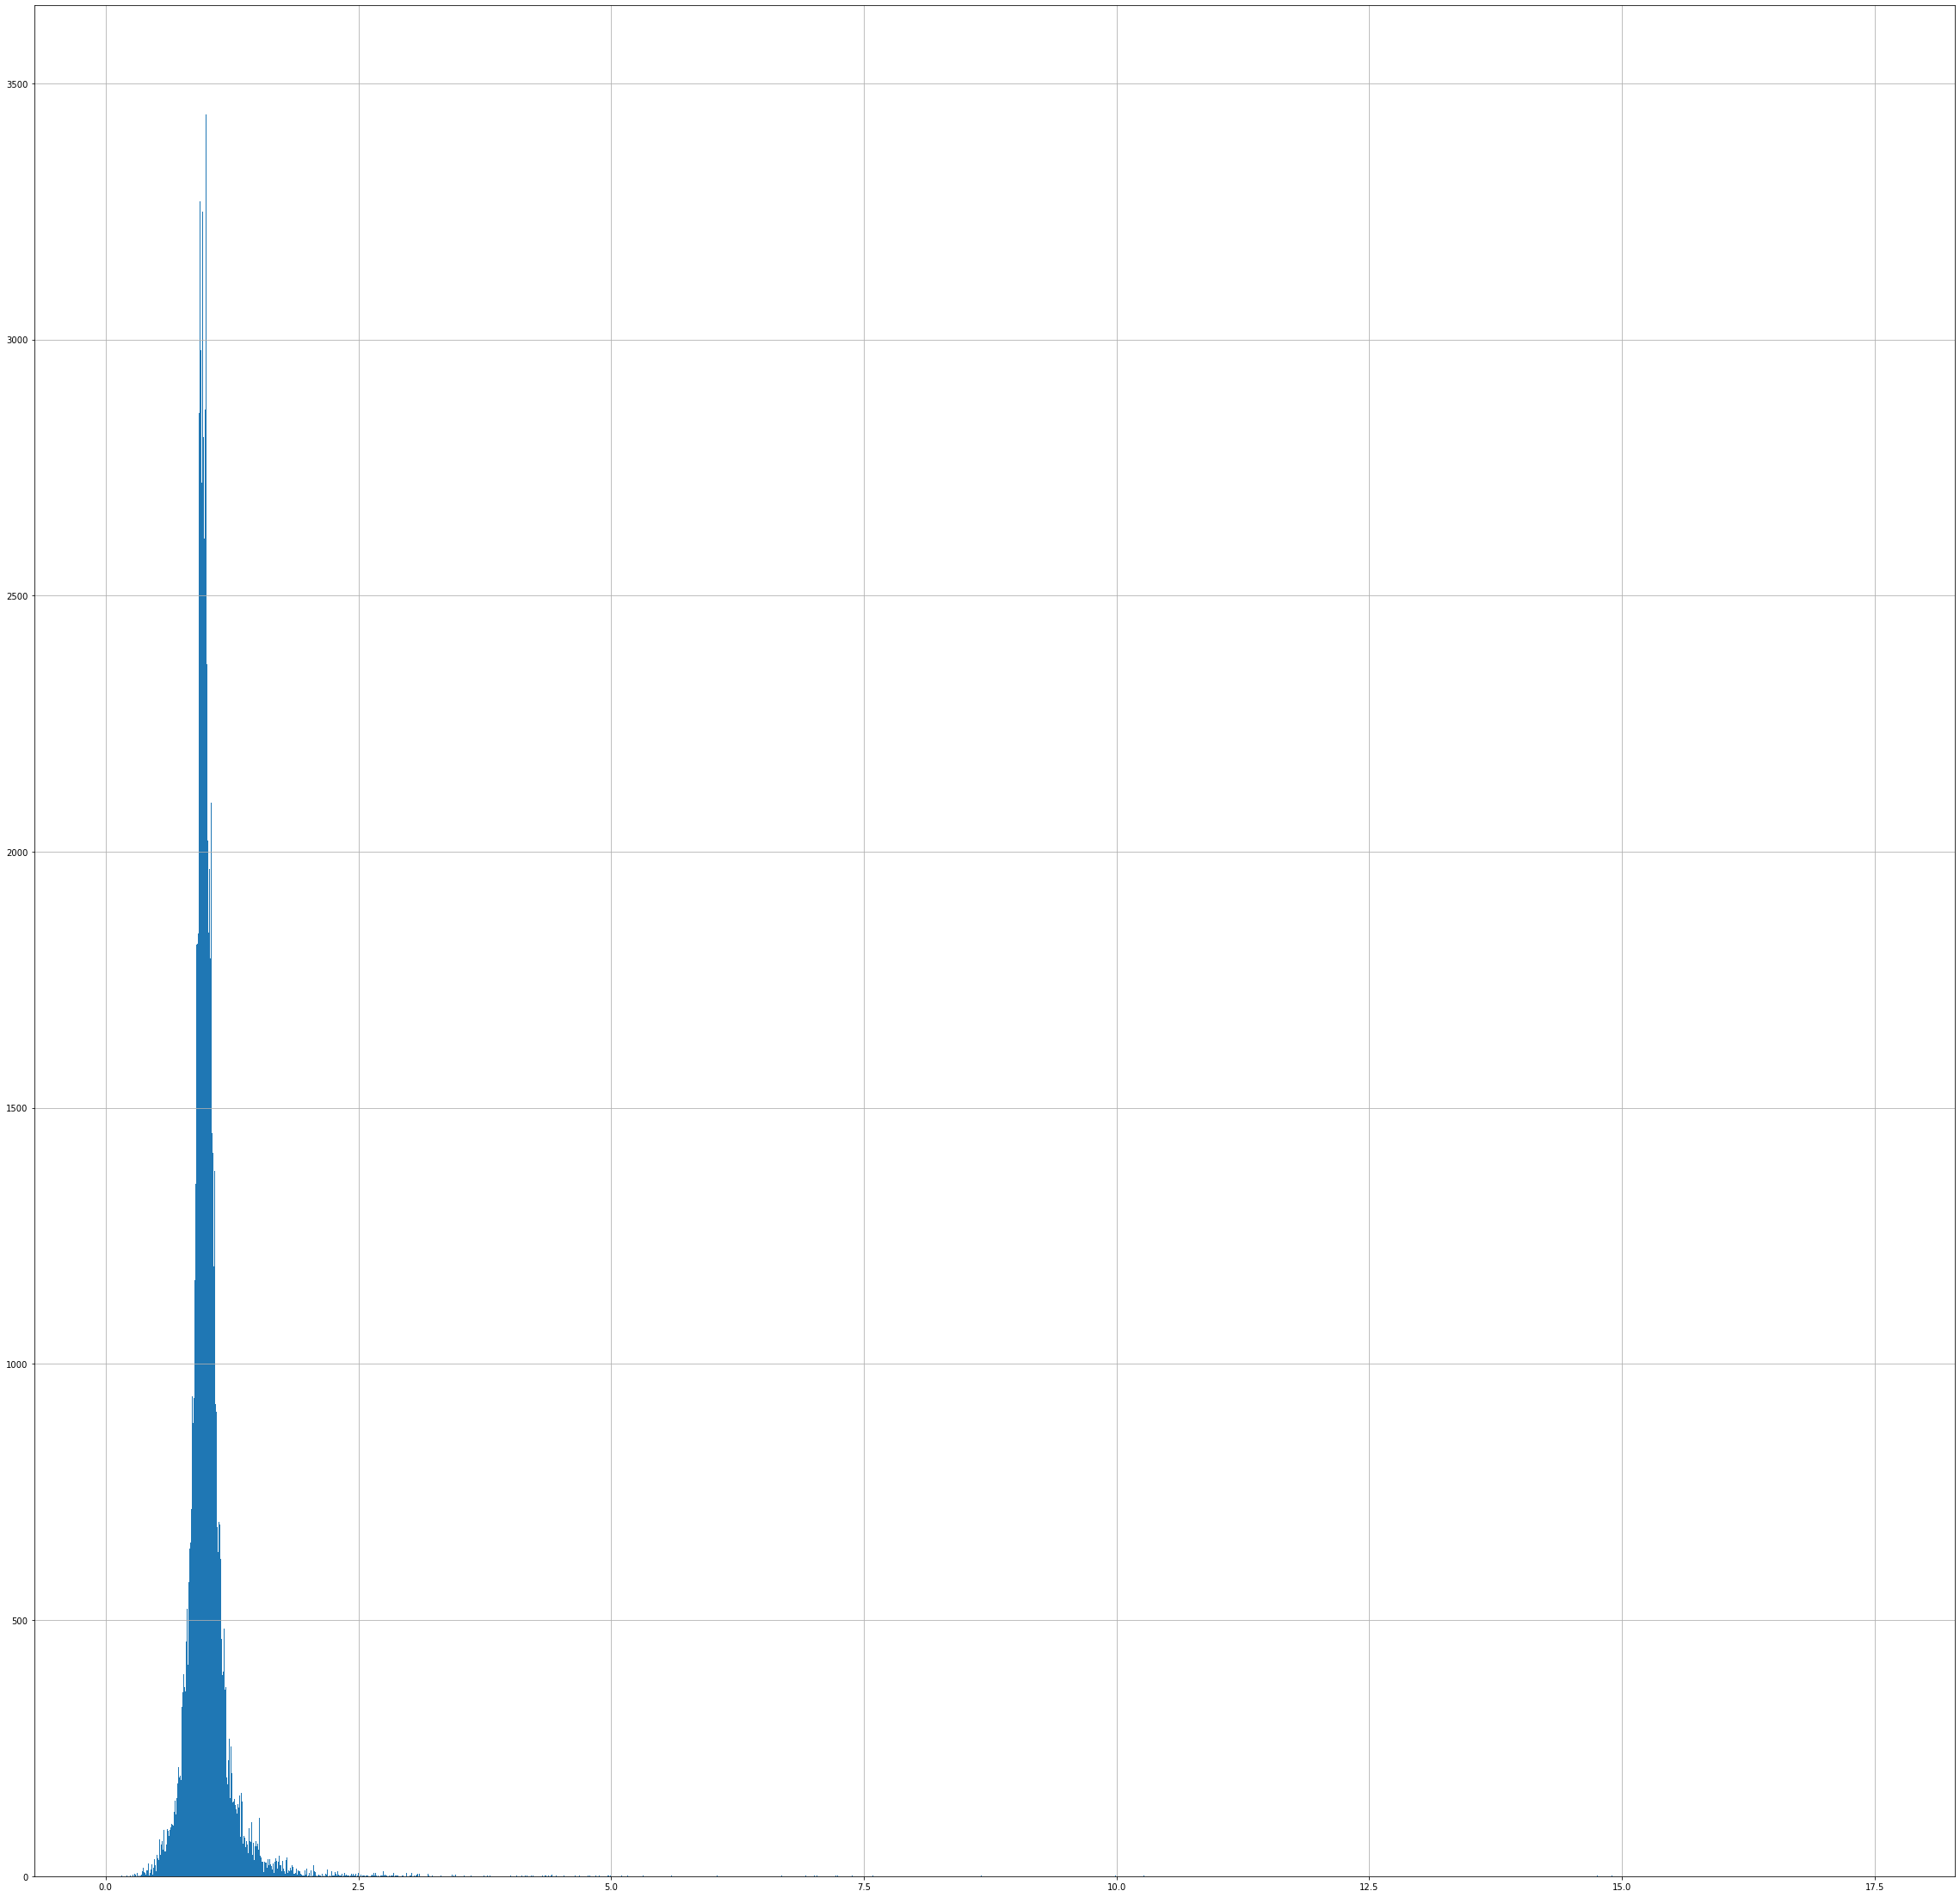

In [28]:
X['weight'].hist(figsize=(40,40), bins='auto');

In [30]:
X.sort_values(by='weight', ascending=False)['weight'][:50]

124563    17.428809
128076    15.219757
122416    14.904742
123664    14.754709
127009    14.539439
124025    13.348961
121079    10.271535
123978     9.987001
125638     9.967050
124077     9.492595
127971     8.666806
125871     8.340391
125103     7.645408
125084     7.645408
123995     7.590557
121169     7.384835
126071     7.278069
122951     7.243991
125086     7.220663
124549     7.096761
122420     7.038351
127288     7.010165
121180     6.923282
125943     6.916422
122810     6.687673
109578     6.049346
126925     5.969070
109714     5.662803
124069     5.636228
109757     5.602317
109813     5.319899
120765     5.210064
120754     5.210064
126016     5.168164
126017     5.104757
122048     4.990465
128109     4.977232
128097     4.967560
125035     4.884566
127048     4.846480
121911     4.786772
122875     4.771929
122061     4.684926
109568     4.644647
126911     4.537039
123877     4.461301
120759     4.415787
114552     4.413837
114422     4.413837
123633     4.406862


### Make pipeline to scale non binary features

In [29]:
col_transformer = ColumnTransformer(transformers=[
    ("scale", StandardScaler(), non_bin_list)], remainder='passthrough')

pipe = Pipeline(steps=[
    ("col_transformer", col_transformer)
])

Xtr_transformed = pd.DataFrame(pipe.fit_transform(Xc_train), columns=final_cols)
Xte_transformed = pd.DataFrame(pipe.transform(Xc_test), columns=final_cols)

Xtr_transformed['index']=ind_train_list
Xte_transformed['index']=ind_test_list

Xtr_transformed.set_index('index', inplace=True)
Xte_transformed.set_index('index', inplace=True)

In [30]:
Xtr_transformed

Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?  \
index                                                                                                                                              
87942                                           -0.139499                                                                                          
9407                                            -0.112922                                                                                          
81398                                           -0.192652                                                                                          
27485                                            0.166132                                                                                          
44622                                            0.431899                                                                                          
...                                                   ...                                                                                          
105386                                          -0.232517                                                                                          
34286                                           -0.179364                                                                                          
124811                                          -0.152787                                                                                          
92976                                           -0.219229                                                                                          
58504                                            2.651049                                                                                          

        If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?  \
index                                                                                                                                                            
87942                                           -0.582703                                                                                                        
9407                                             0.266701                                                                                                        
81398                                           -0.582703                                                                                                        
27485                                            0.266701                                                                                                        
44622                                            0.266701                                                                                                        
...                                                   ...                                                                                                        
105386                                           0.266701                                                                                                        
34286                                           -0.582703                                                                                                        
124811                                          -0.582703                                                                                                        
92976                                           -0.582703                                                                                                        
58504                                           -0.582703                                                                                  

### Make base model, evaluate and try different hyperparameters

In [31]:
model_with_scale = LogisticRegressionThreshold(random_state=42, C=0.01, solver='liblinear')
model_with_scale.fit(Xtr_transformed, y_train)

sc_pred_tr = model_with_scale.predict(Xtr_transformed)
sc_dec_tr = model_with_scale.decision_function(Xtr_transformed)

sc_pred_te = model_with_scale.predict(Xte_transformed)
sc_dec_te = model_with_scale.decision_function(Xte_transformed)

evaluation_metrics(sc_pred_tr, yc_train)

[[28215 17199]
 [13899 36774]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     45414
           1       0.68      0.73      0.70     50673

    accuracy                           0.68     96087
   macro avg       0.68      0.67      0.67     96087
weighted avg       0.68      0.68      0.68     96087



In [32]:
evaluation_metrics(sc_pred_te, yc_test)

[[ 9431  5708]
 [ 4673 12218]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65     15139
           1       0.68      0.72      0.70     16891

    accuracy                           0.68     32030
   macro avg       0.68      0.67      0.67     32030
weighted avg       0.68      0.68      0.67     32030



AUC: 0.7350551935157649


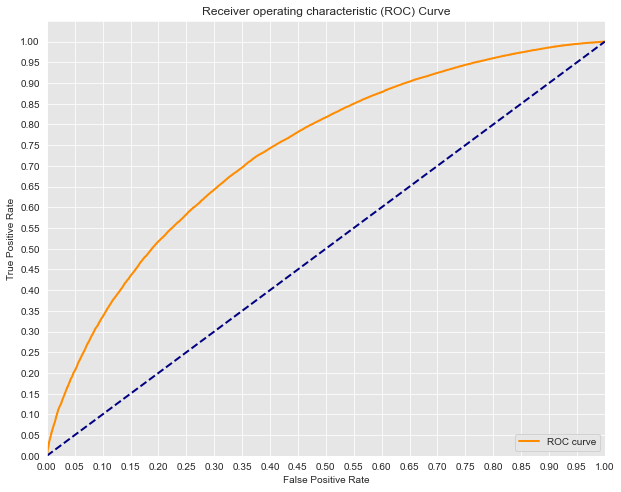

In [235]:
make_roc_curve(sc_dec_tr, y_train, model_type='logistic')

AUC: 0.7375750836830259


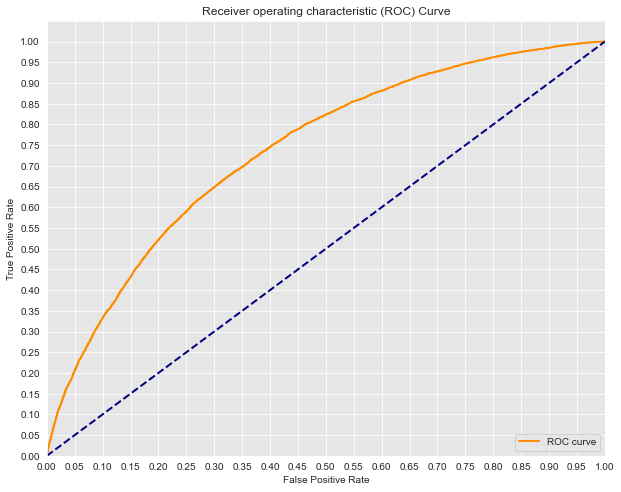

In [236]:
make_roc_curve(sc_dec_te, y_test, model_type='logistic')

In [ ]:
log_params = {
    'penalty': ['l1','l2'], 
    'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
    'solver' :['liblinear', 'lbfgs', 'sag'],
    'max_iter':[100, 1000]
}

In [61]:
make_grid(model_with_scale, log_params, Xtr_transformed, y_train, Xte_transformed, y_test)

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 433, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got logistic.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 433, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got logistic.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not con

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\james\anaconda3\envs\learn-env\lib\s

Grid Search found the following optimal parameters: 
C: 0.01
max_iter: 100
penalty: 'l2'
solver: 'lbfgs'

Training Accuracy: 67.63%
Validation accuracy: 67.61%


### make tuned model

In [33]:
tuned_log = LogisticRegressionThreshold(random_state=42, C=0.01, solver='lbfgs')
tuned_log.fit(Xtr_transformed, y_train)

tl_pred_tr = tuned_log.predict(Xtr_transformed)
tl_dec_tr = tuned_log.decision_function(Xtr_transformed)

tl_pred_te = tuned_log.predict(Xte_transformed)
tl_dec_te = tuned_log.decision_function(Xte_transformed)

evaluation_metrics(tl_pred_tr, y_train)

[[28249 17165]
 [13943 36730]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     45414
           1       0.68      0.72      0.70     50673

    accuracy                           0.68     96087
   macro avg       0.68      0.67      0.67     96087
weighted avg       0.68      0.68      0.68     96087



In [34]:
evaluation_metrics(tl_pred_te, y_test)

[[ 9445  5694]
 [ 4681 12210]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65     15139
           1       0.68      0.72      0.70     16891

    accuracy                           0.68     32030
   macro avg       0.68      0.67      0.67     32030
weighted avg       0.68      0.68      0.68     32030



### look at effects of using different thresholds

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


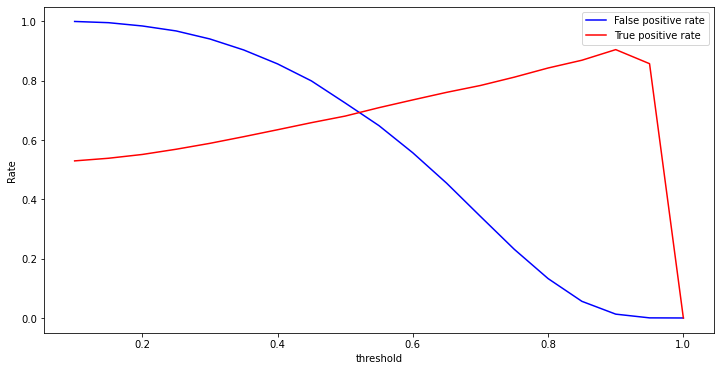

In [64]:
# fpr, tpr at different thresholds
thresh = np.linspace(0.1, 1, 19, endpoint=True)
test_params(thresh, Xtr_transformed, Xte_transformed, tuned_log, 'threshold', test_train='test', graph_type='tpr_v_fpr')


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
No handles with labels found to put in legend.


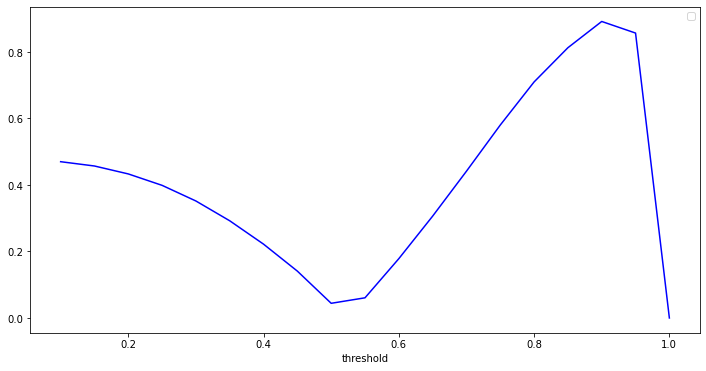

In [65]:
# differnce between fpr and tpr at different thresholds
test_params(thresh, Xtr_transformed, Xte_transformed, tuned_log, 'threshold', test_train='test', y_ax='diff_list', graph_type='tpr_v_fpr')
 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
No handles with labels found to put in legend.


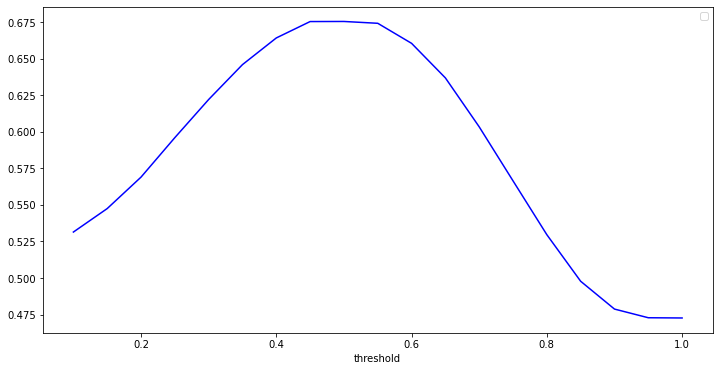

In [66]:
# accuracy at various thresholds
test_params(thresh, Xtr_transformed, Xte_transformed, tuned_log, 'threshold', test_train='test', y_ax='acc_list', graph_type='tpr_v_fpr')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
No handles with labels found to put in legend.


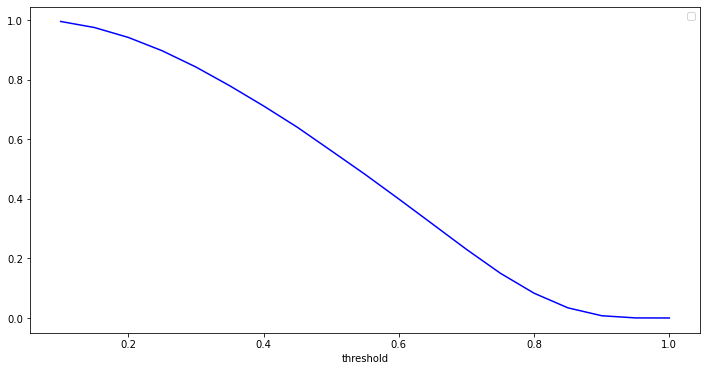

In [67]:
# proportion of predicted ones at various thresholds
test_params(thresh, Xtr_transformed, Xte_transformed, tuned_log, 'threshold', test_train='test', graph_type='tpr_v_fpr', ones=True)

In [35]:
# 0.4 seems good compromise to raise recall of 1s. Check class report
thresh_pred = tuned_log.predict(Xte_transformed, threshold=0.4) 
evaluation_metrics(thresh_pred, y_test)

[[ 6887  8252]
 [ 2478 14413]]
              precision    recall  f1-score   support

           0       0.74      0.45      0.56     15139
           1       0.64      0.85      0.73     16891

    accuracy                           0.67     32030
   macro avg       0.69      0.65      0.65     32030
weighted avg       0.68      0.67      0.65     32030



### use statsmodel to get pvalues and remove features >0.05

In [36]:
alpha=1/0.01

In [108]:
def sm_log(X_train, X_test, t=0.5):
    '''makes log model using statsmodel'''
    sm_preds=[]
    X_int = sm.add_constant(X_train)
    pred_int = sm.add_constant(X_test)

    # Fit model
    logit_model = sm.Logit(y_train, X_int)

    # Get results of the fit
    result = logit_model.fit_regularized(alpha=alpha)
    res_pred= result.predict(pred_int)
    for r in res_pred:
        if r>=t:
            pr=1
        else:
            pr=0
        sm_preds.append(pr)
    return result, sm_preds, 
    

In [87]:
sm_log_res = sm_log(Xtr_transformed, Xte_transformed)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6109256945437221
            Iterations: 143
            Function evaluations: 144
            Gradient evaluations: 143


In [88]:
evaluation_metrics(sm_log_res[1], y_test)

[[ 9332  5807]
 [ 4590 12301]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     15139
           1       0.68      0.73      0.70     16891

    accuracy                           0.68     32030
   macro avg       0.67      0.67      0.67     32030
weighted avg       0.68      0.68      0.67     32030



In [90]:
#w low thresh
sm_log_res_t=sm_log(Xtr_transformed, Xte_transformed, t=0.41)
evaluation_metrics(sm_log_res_t[1], y_test)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6109256945437221
            Iterations: 143
            Function evaluations: 144
            Gradient evaluations: 143
[[ 6965  8174]
 [ 2570 14321]]
              precision    recall  f1-score   support

           0       0.73      0.46      0.56     15139
           1       0.64      0.85      0.73     16891

    accuracy                           0.66     32030
   macro avg       0.68      0.65      0.65     32030
weighted avg       0.68      0.66      0.65     32030



In [52]:
p_df = pd.DataFrame(sm_log_res[0].pvalues)

In [53]:
sm_log_res[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 PHQ4_2   No. Observations:                96087
Model:                          Logit   Df Residuals:                    96038
Method:                           MLE   Df Model:                           48
Date:                Sat, 22 Jan 2022   Pseudo R-squ.:                  0.1264
Time:                        11:13:17   Log-Likelihood:                -58058.
converged:                       True   LL-Null:                       -66458.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================================================================================================
                                                                                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                                     -0.2518      0.017    -14.508      0.000      -0.286      -0.218
Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?                  -0.0400      0.007     -5.527      0.000      -0.054      -0.026
If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?     0.0843      0.008     10.336      0.000       0.068       0.100
Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)                                          -0.0173      0.009     -1.922      0.055      -0.035       0.000
Washed hands with soap and water                                                                                                                           0.0503      0.009      5.571      0.000       0.033       0.068
Used hand sanitiser                                                                                                                                        0.0139      0.009      1.578      0.114      -0.003       0.031
Covered your nose and mouth when sneezing or coughing                                                                                                      0.0393      0.009      4.529      0.000       0.022       0.056
Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus                                                        0.0542      0.009      5.796      0.000       0.036       0.073
Avoided going out in general                                                                                                                              -0.1963      0.010    -20.186      0.000      -0.215      -0.177
Avoided going to hospital or other healthcare settings                                                                                                     0.0365      0.009      4.133      0.000       0.019       0.054
Avoided taking public transport                                                                                                                            0.0349      0.009      3.997      0.000       0.018       0.052
Avoided having guests to your home                                                                                                                        -0.0394      0.011   

In [54]:
# make list of features with high p values
lp_df=p_df[p_df[0]<=0.05]
hp_df=p_df[p_df[0]>0.05]

lp_df.reset_index(drop=False, inplace=True)
hp_df.reset_index(drop=False, inplace=True)

good_feat_list=lp_df['index'].tolist()
bad_feat_list=hp_df['index'].tolist()

In [55]:
good_feat_list.remove('const')

In [257]:
#good_feat_list.append('Feeling down, depressed, or hopeless')

In [56]:
# filter train test sets using only low p features
X_new_train = Xtr_transformed[good_feat_list]
X_new_test = Xte_transformed[good_feat_list]

### Refit tuned model-sklearn

In [111]:
tuned_log.fit(X_new_train, y_train)
new_pred_test = tuned_log.predict(X_new_test)

In [78]:
evaluation_metrics(new_pred_test, y_test)

[[ 9418  5721]
 [ 4684 12207]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     15139
           1       0.68      0.72      0.70     16891

    accuracy                           0.68     32030
   macro avg       0.67      0.67      0.67     32030
weighted avg       0.67      0.68      0.67     32030



In [125]:
new_pred_test_t = tuned_log.predict(X_new_test, threshold=0.4)
evaluation_metrics(new_pred_test_t, y_test)

[[ 6853  8286]
 [ 2483 14408]]
              precision    recall  f1-score   support

           0       0.73      0.45      0.56     15139
           1       0.63      0.85      0.73     16891

    accuracy                           0.66     32030
   macro avg       0.68      0.65      0.64     32030
weighted avg       0.68      0.66      0.65     32030



### Refit sm model

In [91]:
sm_new=sm_log(X_new_train, X_new_test, t=0.41)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.611002560483105
            Iterations: 110
            Function evaluations: 111
            Gradient evaluations: 110


In [92]:
evaluation_metrics(sm_new[1], y_test)

[[ 6968  8171]
 [ 2573 14318]]
              precision    recall  f1-score   support

           0       0.73      0.46      0.56     15139
           1       0.64      0.85      0.73     16891

    accuracy                           0.66     32030
   macro avg       0.68      0.65      0.65     32030
weighted avg       0.68      0.66      0.65     32030



In [80]:
new_log_df=pd.DataFrame(sm_new[0].pvalues)
new_log_df.reset_index(inplace=True)

In [272]:
sm_new[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 PHQ4_2   No. Observations:                96087
Model:                          Logit   Df Residuals:                    96047
Method:                           MLE   Df Model:                           39
Date:                Wed, 12 Jan 2022   Pseudo R-squ.:                  0.1259
Time:                        14:12:45   Log-Likelihood:                -58094.
converged:                       True   LL-Null:                       -66458.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================================================================================================
                                                                                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                                     -0.2509      0.016    -16.142      0.000      -0.281      -0.220
Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?                  -0.0405      0.007     -5.626      0.000      -0.055      -0.026
If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?     0.0843      0.008     10.377      0.000       0.068       0.100
Washed hands with soap and water                                                                                                                           0.0533      0.009      6.193      0.000       0.036       0.070
Covered your nose and mouth when sneezing or coughing                                                                                                      0.0392      0.009      4.553      0.000       0.022       0.056
Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus                                                        0.0524      0.009      5.782      0.000       0.035       0.070
Avoided going out in general                                                                                                                              -0.1971      0.010    -20.361      0.000      -0.216      -0.178
Avoided going to hospital or other healthcare settings                                                                                                     0.0364      0.009      4.151      0.000       0.019       0.054
Avoided taking public transport                                                                                                                            0.0358      0.009      4.141      0.000       0.019       0.053
Avoided having guests to your home                                                                                                                        -0.0416      0.011     -3.955      0.000      -0.062      -0.021
Avoided small social gatherings (not more than 2 people)                                                                                                  -0.0301      0.011     -2.791      0.005      -0.051      -0.009
What is your age?                                                                                                                                         -0.4515      0.009   

### get coefficients and interpret

In [81]:
log_mod=sm_new[0]
coeff_list = list(log_mod.params[1:])
feature_list = list(X_new_train.columns)
coeff_dict = dict(zip(feature_list, coeff_list))
coeff_sl = sorted(coeff_dict.items(), key=lambda x:x[1], reverse=True)


In [82]:
for k in coeff_sl:
    try:
        feature=code_dict[k[0]] 
    except: 
        feature=k[0]
    print(f'coeff for {feature} is {[k[1]]}')

coeff for country_italy is [0.5304626480035127]
coeff for emp_Unemployed is [0.45268959410269843]
coeff for My life has been greatly affected by coronavirus (COVID-19) is [0.36227135759143547]
coeff for Gender is [0.2968444017122877]
coeff for emp_Not working is [0.2635493594863684]
coeff for Arthritis is [0.24656444673023184]
coeff for High blood pressure is [0.17074744763022315]
coeff for emp_Full time student is [0.16713875859580932]
coeff for Asthma is [0.16611934188821473]
coeff for High cholesterol is [0.165849861244816]
coeff for country_france is [0.1238751312274186]
coeff for Chronic obstructive pulmonary disease (COPD) is [0.1235040778484618]
coeff for emp_Part time employment is [0.11897526712226689]
coeff for And how much confidence do you have in the NHS to respond to a Coronavirus (COVID-19) outbreak in the UK? is [0.09217561173353858]
coeff for Coronavirus (COVID-19) is very dangerous for me is [0.08862556317016884]
coeff for If you were advised to do so by a healthcare 

In [83]:
# unscale the continuous values so we can interpret coefficient.
# Need to reduce coefficient by same factor we will end up increasing the value
# that factor is calculated by adding mean and std of column before it was scaled
for nb in non_bin_list:
    if nb in feature_list:
        mean=np.mean(two_df_c[nb])
        std=np.std(two_df_c[nb])
        old_co=coeff_dict[nb]
        new_co= old_co/(mean+std)
        coeff_dict   
        coeff_dict[nb]=new_co

coeff_sl = sorted(coeff_dict.items(), key=lambda x:x[1], reverse=True)
for k in coeff_sl:
    try:
        feature=code_dict[k[0]] 
    except: 
        feature=k[0]
    print(f'coeff for {feature} is {[k[1]]}')  

coeff for country_italy is [0.5304626480035127]
coeff for emp_Unemployed is [0.45268959410269843]
coeff for Gender is [0.2968444017122877]
coeff for emp_Not working is [0.2635493594863684]
coeff for Arthritis is [0.24656444673023184]
coeff for High blood pressure is [0.17074744763022315]
coeff for emp_Full time student is [0.16713875859580932]
coeff for Asthma is [0.16611934188821473]
coeff for High cholesterol is [0.165849861244816]
coeff for country_france is [0.1238751312274186]
coeff for Chronic obstructive pulmonary disease (COPD) is [0.1235040778484618]
coeff for emp_Part time employment is [0.11897526712226689]
coeff for Heart disease is [0.07648578655893226]
coeff for country_spain is [0.07153620197661001]
coeff for Diabetes is [0.07056272305423567]
coeff for My life has been greatly affected by coronavirus (COVID-19) is [0.05751741900577322]
coeff for If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to s

In [134]:
graph_dic={k:v for k, v in coeff_sl}
graph_dic

{'country_italy': 0.5304626480035127,
 'emp_Unemployed': 0.45268959410269843,
 'Gender': 0.2968444017122877,
 'emp_Not working': 0.2635493594863684,
 'Arthritis': 0.24656444673023184,
 'High blood pressure': 0.17074744763022315,
 'emp_Full time student': 0.16713875859580932,
 'Asthma': 0.16611934188821473,
 'High cholesterol': 0.165849861244816,
 'country_france': 0.1238751312274186,
 'Chronic obstructive pulmonary disease (COPD)': 0.1235040778484618,
 'emp_Part time employment': 0.11897526712226689,
 'Heart disease': 0.07648578655893226,
 'country_spain': 0.07153620197661001,
 'Diabetes': 0.07056272305423567,
 'My life has been greatly affected by coronavirus (COVID-19)': 0.05751741900577322,
 'If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?': 0.04529629188776845,
 'Washed hands with soap and water': 0.042166928755406605,
 'And how much confidence do you have in the NHS to respond to

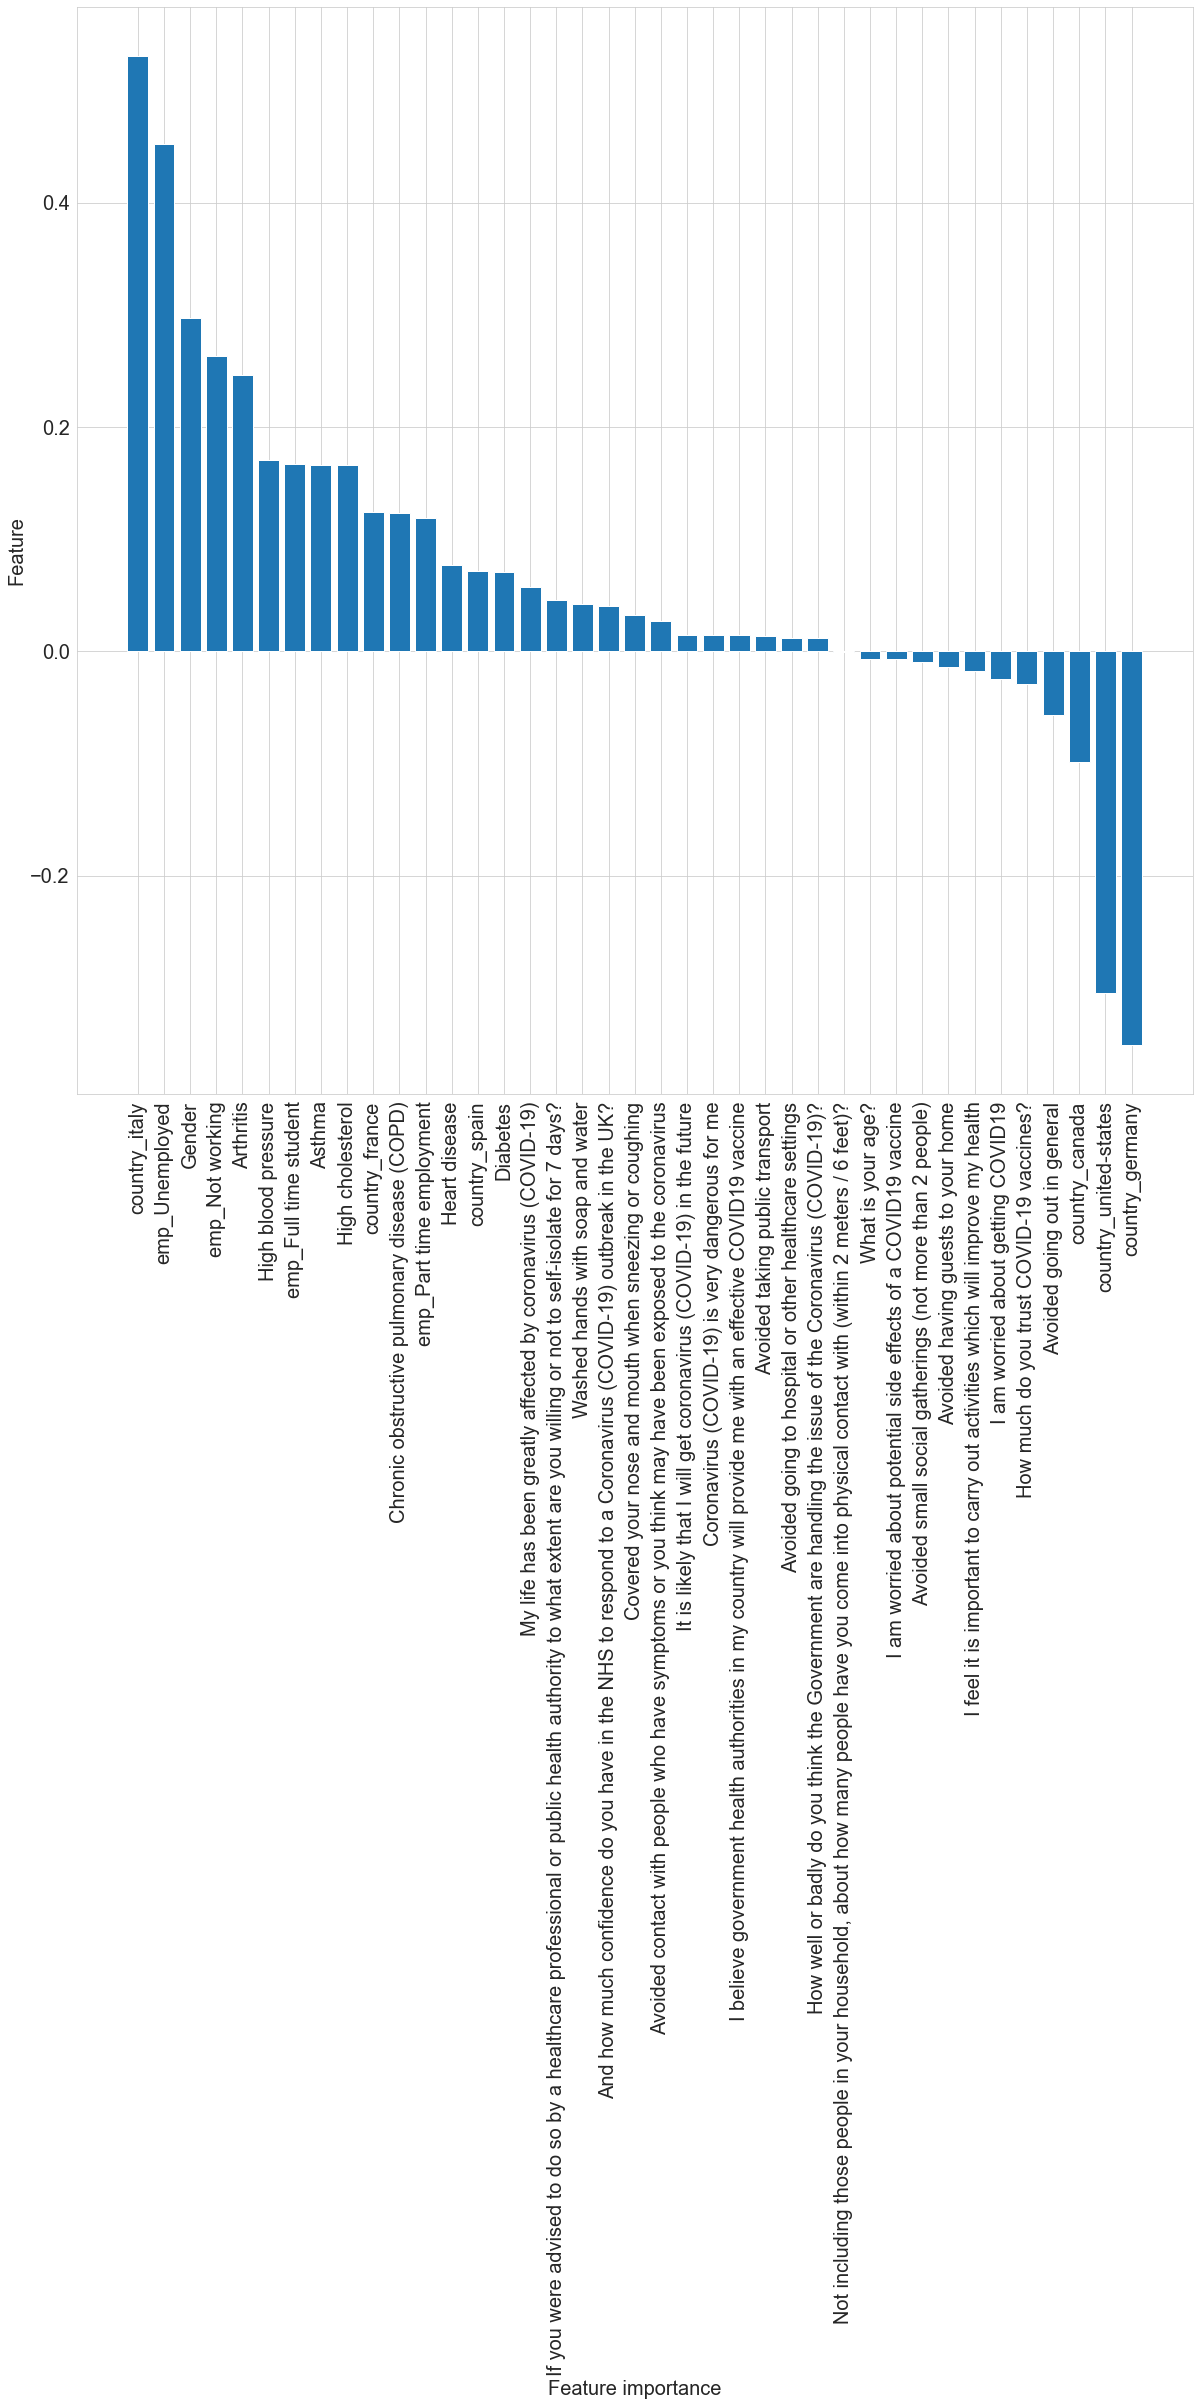

In [131]:
# make graph of percetage increase in odds of reporting mental health issues for one unit increase in each feature
plt.figure(figsize=(20,20))
plt.bar(list(graph_dic.keys()), list(graph_dic.values()), align='center') 
#plt.yticks(np.arange(n_features), feat_list)
plt.xticks(rotation=90) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [139]:
# do same but just for binary features, better to show like vs like
bin_dic = {k:v for (k,v) in coeff_sl if k in bin_list}
bin_dic

{'country_italy': 0.5304626480035127,
 'emp_Unemployed': 0.45268959410269843,
 'Gender': 0.2968444017122877,
 'emp_Not working': 0.2635493594863684,
 'Arthritis': 0.24656444673023184,
 'High blood pressure': 0.17074744763022315,
 'emp_Full time student': 0.16713875859580932,
 'Asthma': 0.16611934188821473,
 'High cholesterol': 0.165849861244816,
 'country_france': 0.1238751312274186,
 'Chronic obstructive pulmonary disease (COPD)': 0.1235040778484618,
 'emp_Part time employment': 0.11897526712226689,
 'Heart disease': 0.07648578655893226,
 'country_spain': 0.07153620197661001,
 'Diabetes': 0.07056272305423567,
 'country_canada': -0.09849739395127027,
 'country_united-states': -0.3046626365399704,
 'country_germany': -0.3506769370392536}

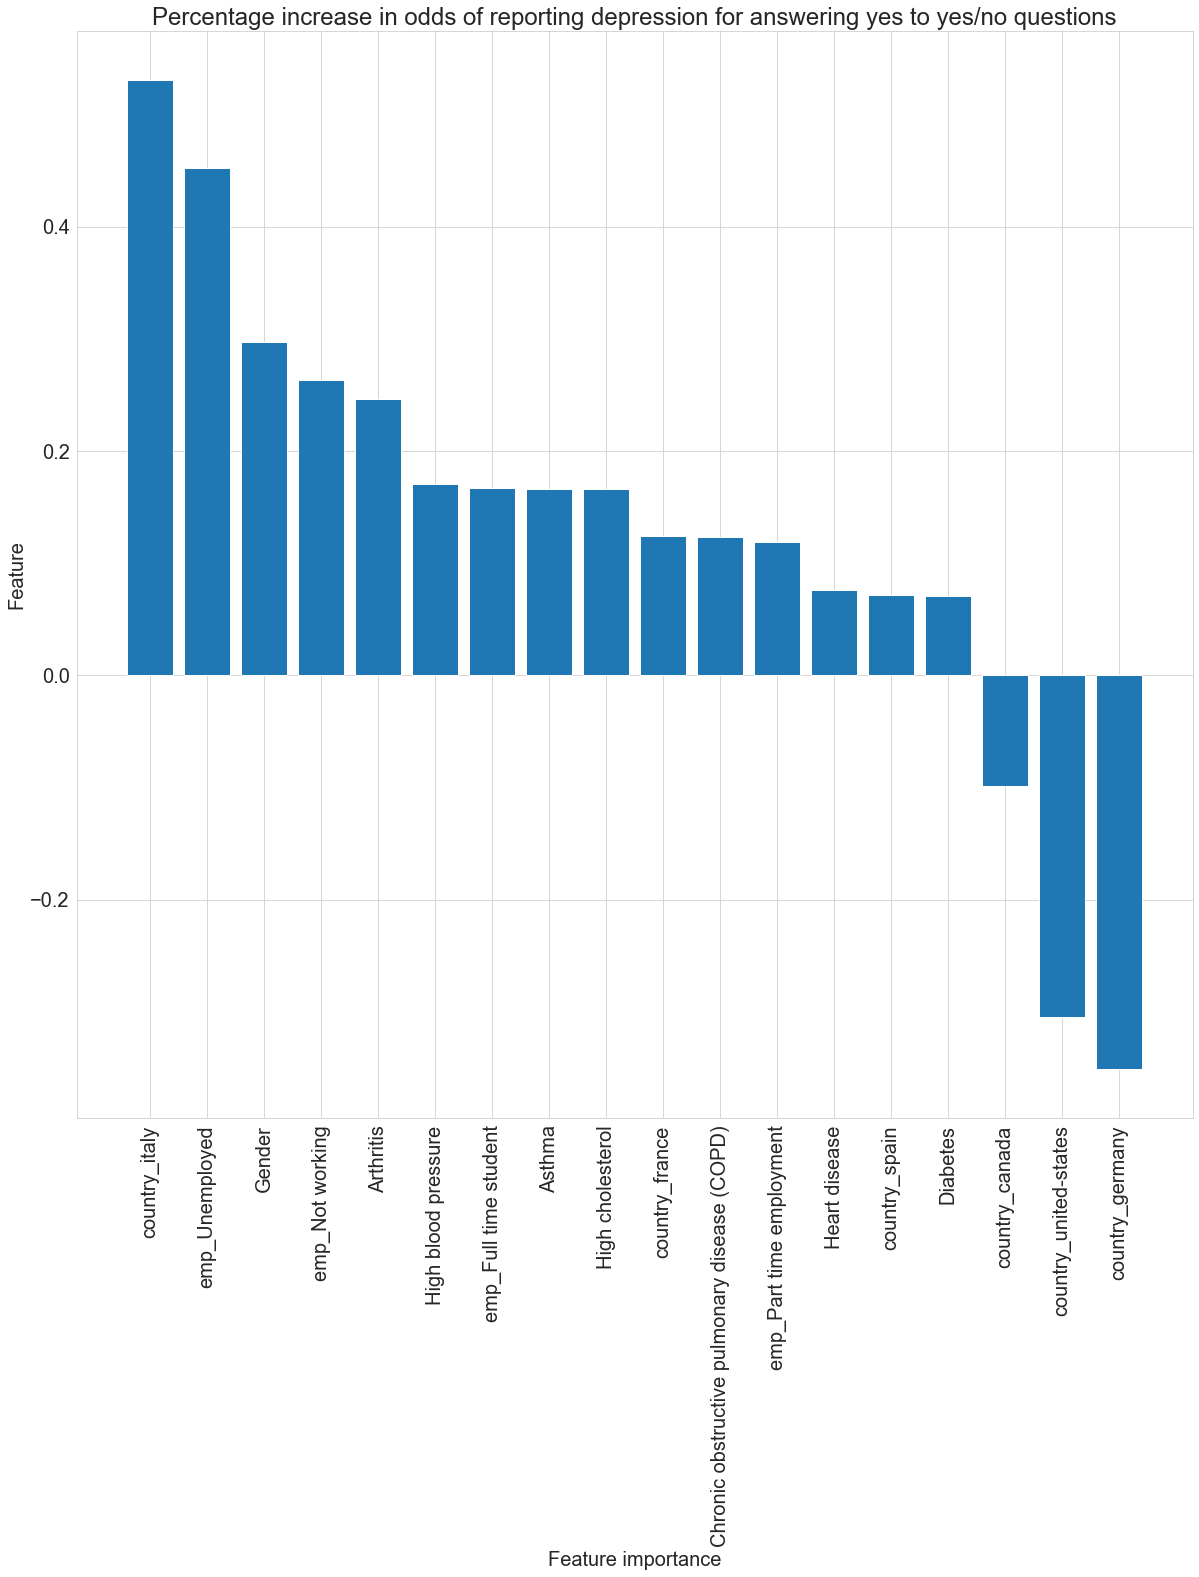

In [140]:
plt.figure(figsize=(20,20))
plt.bar(list(bin_dic.keys()), list(bin_dic.values()), align='center') 
#plt.yticks(np.arange(n_features), feat_list)
plt.xticks(rotation=90) 
plt.title('Percentage increase in odds of reporting depression for answering yes to yes/no questions')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [55]:
for feat in graph_dic:
  #  print(f'increasing {feat} by one unit increases the odds of reporting depression by {int(10*(1-(np.exp(graph_dic[feat]))))} percent')
    print(f'increasing {feat} by one unit increases the odds of reporting depression by {round(100*(np.exp(graph_dic[feat])-1), 1)} percent')

increasing country_italy by one unit increases the odds of reporting depression by 70.0 percent
increasing emp_Unemployed by one unit increases the odds of reporting depression by 57.3 percent
increasing Gender by one unit increases the odds of reporting depression by 34.6 percent
increasing emp_Not working by one unit increases the odds of reporting depression by 30.2 percent
increasing Arthritis by one unit increases the odds of reporting depression by 28.0 percent
increasing High blood pressure by one unit increases the odds of reporting depression by 18.6 percent
increasing emp_Full time student by one unit increases the odds of reporting depression by 18.2 percent
increasing Asthma by one unit increases the odds of reporting depression by 18.1 percent
increasing High cholesterol by one unit increases the odds of reporting depression by 18.0 percent
increasing country_france by one unit increases the odds of reporting depression by 13.2 percent
increasing Chronic obstructive pulmon

### use shap values to find most important features, see if they agree

In [112]:
masker_log = shap.maskers.Independent(data = X_new_train)

explainer_log = shap.LinearExplainer(tuned_log, masker = masker_log)
shap_val = explainer_log(X_new_test)

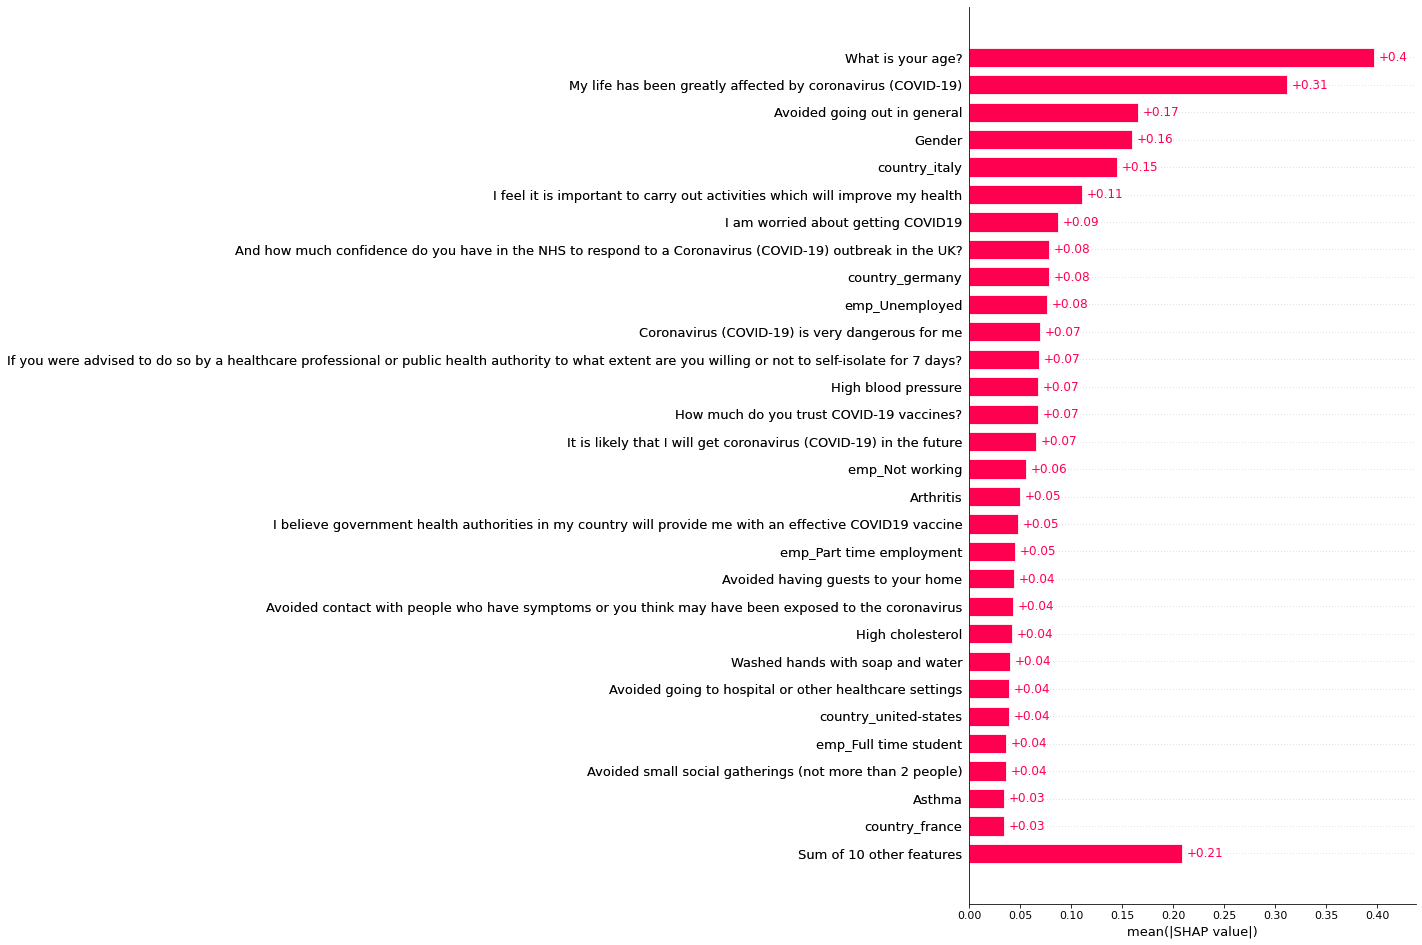

In [93]:
shap.plots.bar(shap_val, max_display=30, show=False)
plt.savefig("log_imp.png",dpi=150, bbox_inches='tight')

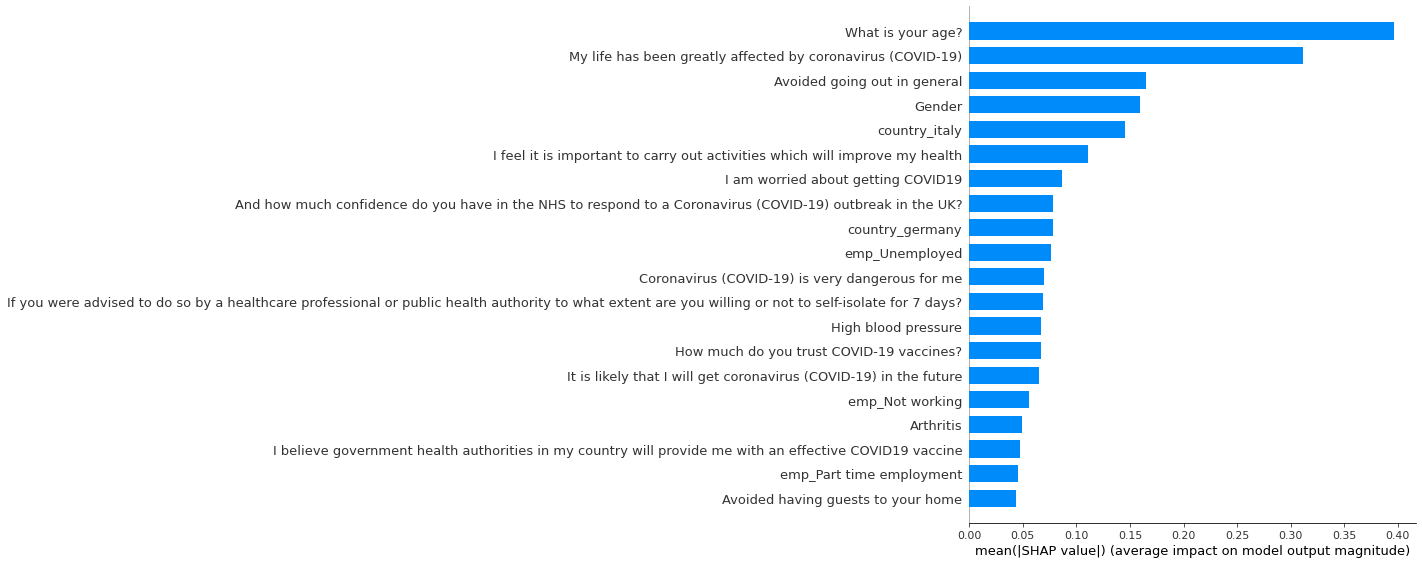

In [114]:
shap.summary_plot(shap_val, X_new_test, plot_type="bar", title='Feature Importances of MODEL A', show=False)                 
plt.savefig("log_imp1.png",dpi=150, bbox_inches='tight')

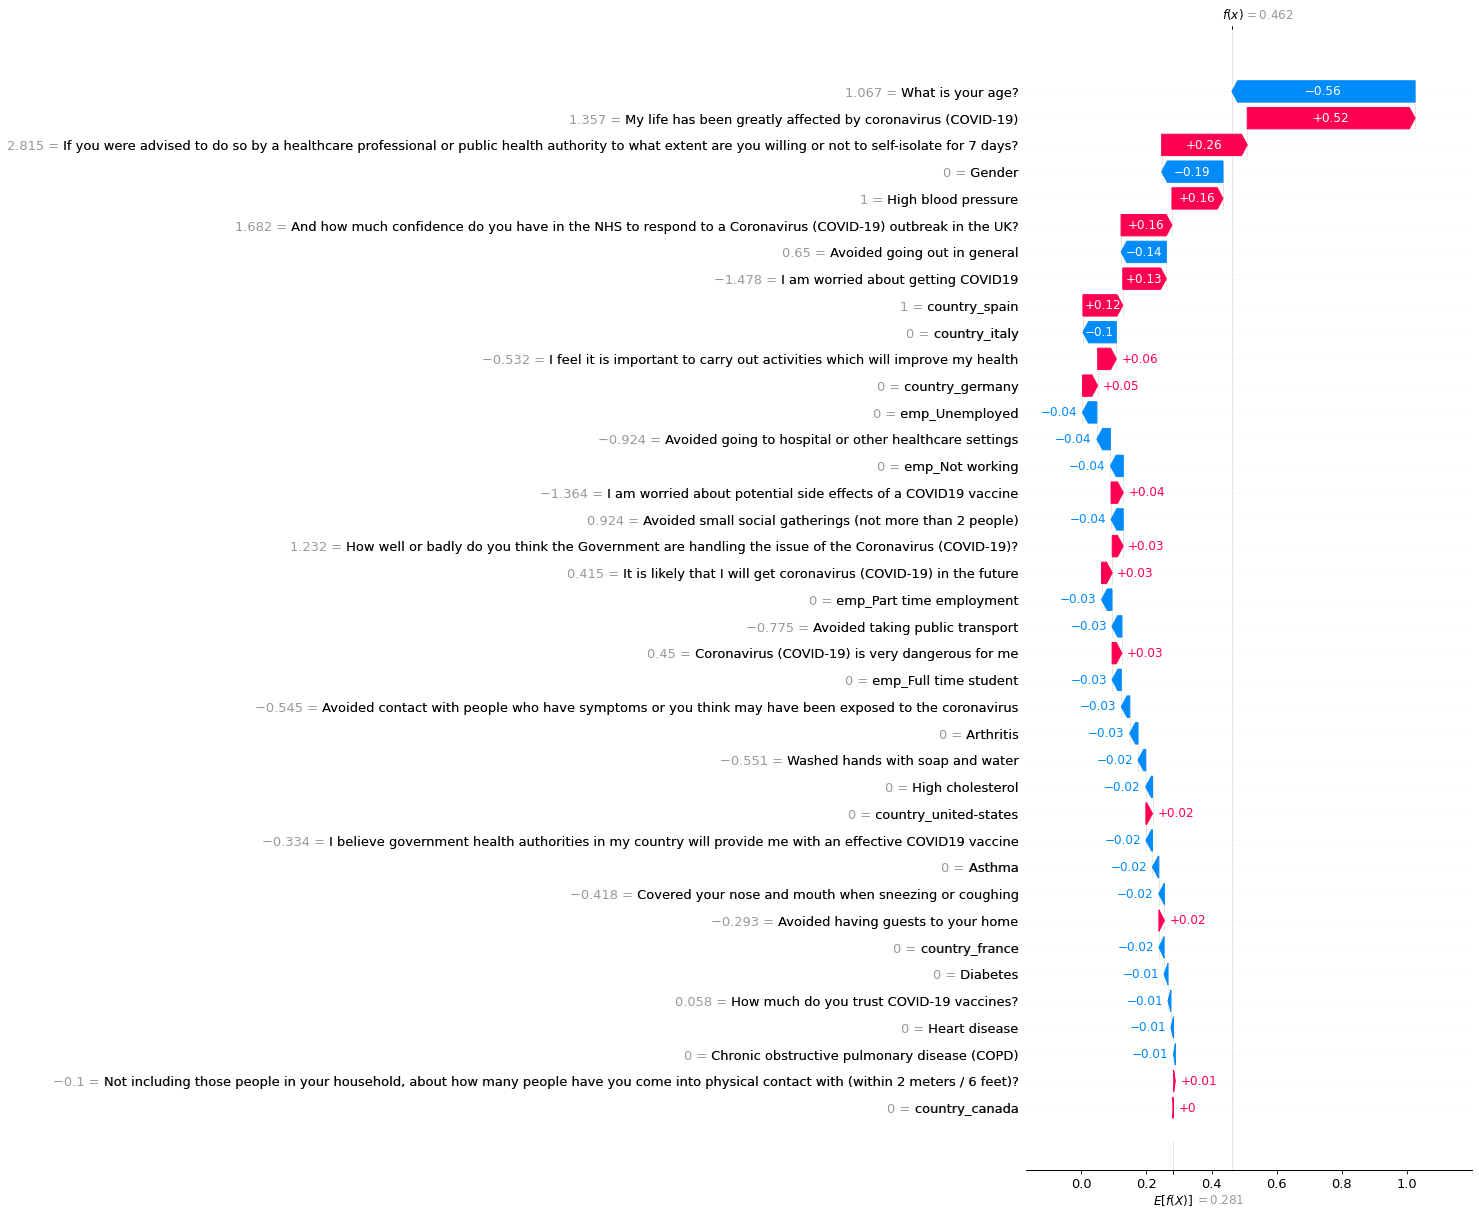

In [58]:
sample_ind = 25
shap.plots.waterfall(shap_val[sample_ind], max_display=400)

## Decision tree

### make base and tune

In [59]:
clf_base = DecisionTreeClassifier(criterion='entropy')

clf_base.fit(Xc_train, yc_train)



DecisionTreeClassifier(criterion='entropy')

In [60]:
clf_pred_train = clf_base.predict(Xc_train)
evaluation_metrics(clf_pred_train, y_train)

[[45414     0]
 [    0 50673]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45414
           1       1.00      1.00      1.00     50673

    accuracy                           1.00     96087
   macro avg       1.00      1.00      1.00     96087
weighted avg       1.00      1.00      1.00     96087



In [61]:
clf_pred_test = clf_base.predict(Xc_test)
evaluation_metrics(clf_pred_test, y_test)

[[ 8733  6406]
 [ 6548 10343]]
              precision    recall  f1-score   support

           0       0.57      0.58      0.57     15139
           1       0.62      0.61      0.61     16891

    accuracy                           0.60     32030
   macro avg       0.59      0.59      0.59     32030
weighted avg       0.60      0.60      0.60     32030



coeff for I am worried about getting COVID19 is [0.11089403835608688]
coeff for Avoided small social gatherings (not more than 2 people) is [0.047184320602042126]
coeff for Number of people in household is [0.0380460730248363]
coeff for Avoided having guests to your home is [0.03306267806267806]
coeff for country_italy is [0.02915309292930021]
coeff for emp_Part time employment is [0.028612070717333883]
coeff for It is likely that I will get coronavirus (COVID-19) in the future is [0.027278981827272192]
coeff for country_spain is [0.024284934923232797]
coeff for I feel it is important to carry out activities which will improve my health is [0.019077563954531467]
coeff for Arthritis is [0.01654367840326094]
coeff for A vaccine for coronavirus (COVID-19) will protect me against any variants, strains or mutations of coronavirus is [0.011338701694538073]
coeff for Getting a vaccine will protect others against coronavirus (COVID-19) is [0.006935763514710885]
coeff for I believe government h

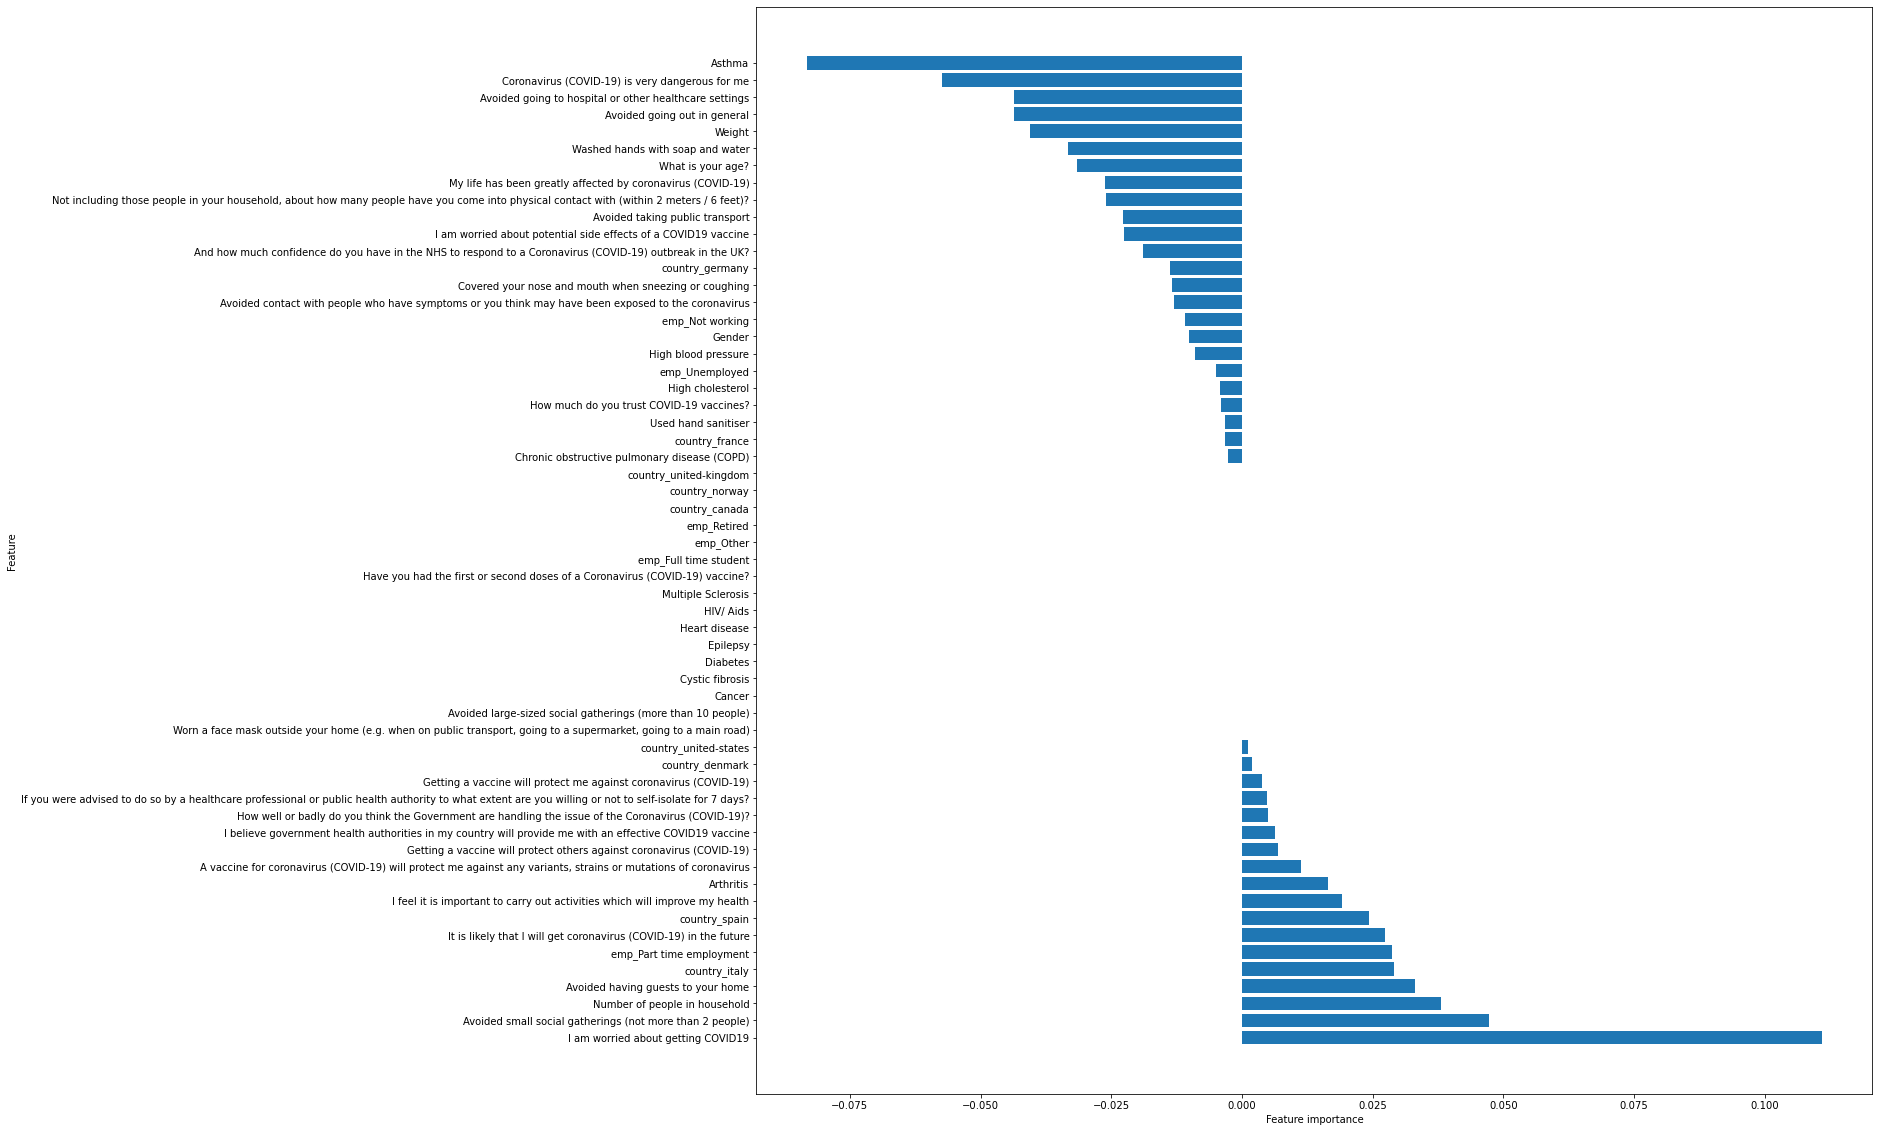

[('vac2_1', 0.11089403835608688),
 ('i12_health_12', 0.047184320602042126),
 ('household_size', 0.0380460730248363),
 ('i12_health_11', 0.03306267806267806),
 ('country_italy', 0.02915309292930021),
 ('emp_Part time employment', 0.028612070717333883),
 ('r1_2', 0.027278981827272192),
 ('country_spain', 0.024284934923232797),
 ('r1_6', 0.019077563954531467),
 ('d1_health_1', 0.01654367840326094),
 ('vac2_7', 0.011338701694538073),
 ('r1_9', 0.006935763514710885),
 ('vac2_3', 0.006392354868940758),
 ('WCRex1', 0.004957408183214634),
 ('i11_health', 0.004843856849783451),
 ('r1_8', 0.003862207641271473),
 ('country_denmark', 0.0018355293048614274),
 ('country_united-states', 0.0011531358319712027),
 ('i12_health_1', 0.0),
 ('i12_health_14', 0.0),
 ('d1_health_3', 0.0),
 ('d1_health_4', 0.0),
 ('d1_health_6', 0.0),
 ('d1_health_7', 0.0),
 ('d1_health_8', 0.0),
 ('d1_health_11', 0.0),
 ('d1_health_13', 0.0),
 ('vac', 0.0),
 ('emp_Full time student', 0.0),
 ('emp_Other', 0.0),
 ('emp_Retired

In [62]:
prediction_t, bias_t, contributions_t = ti.predict(clf_base, Xc_test)
important_cols(contributions_t)

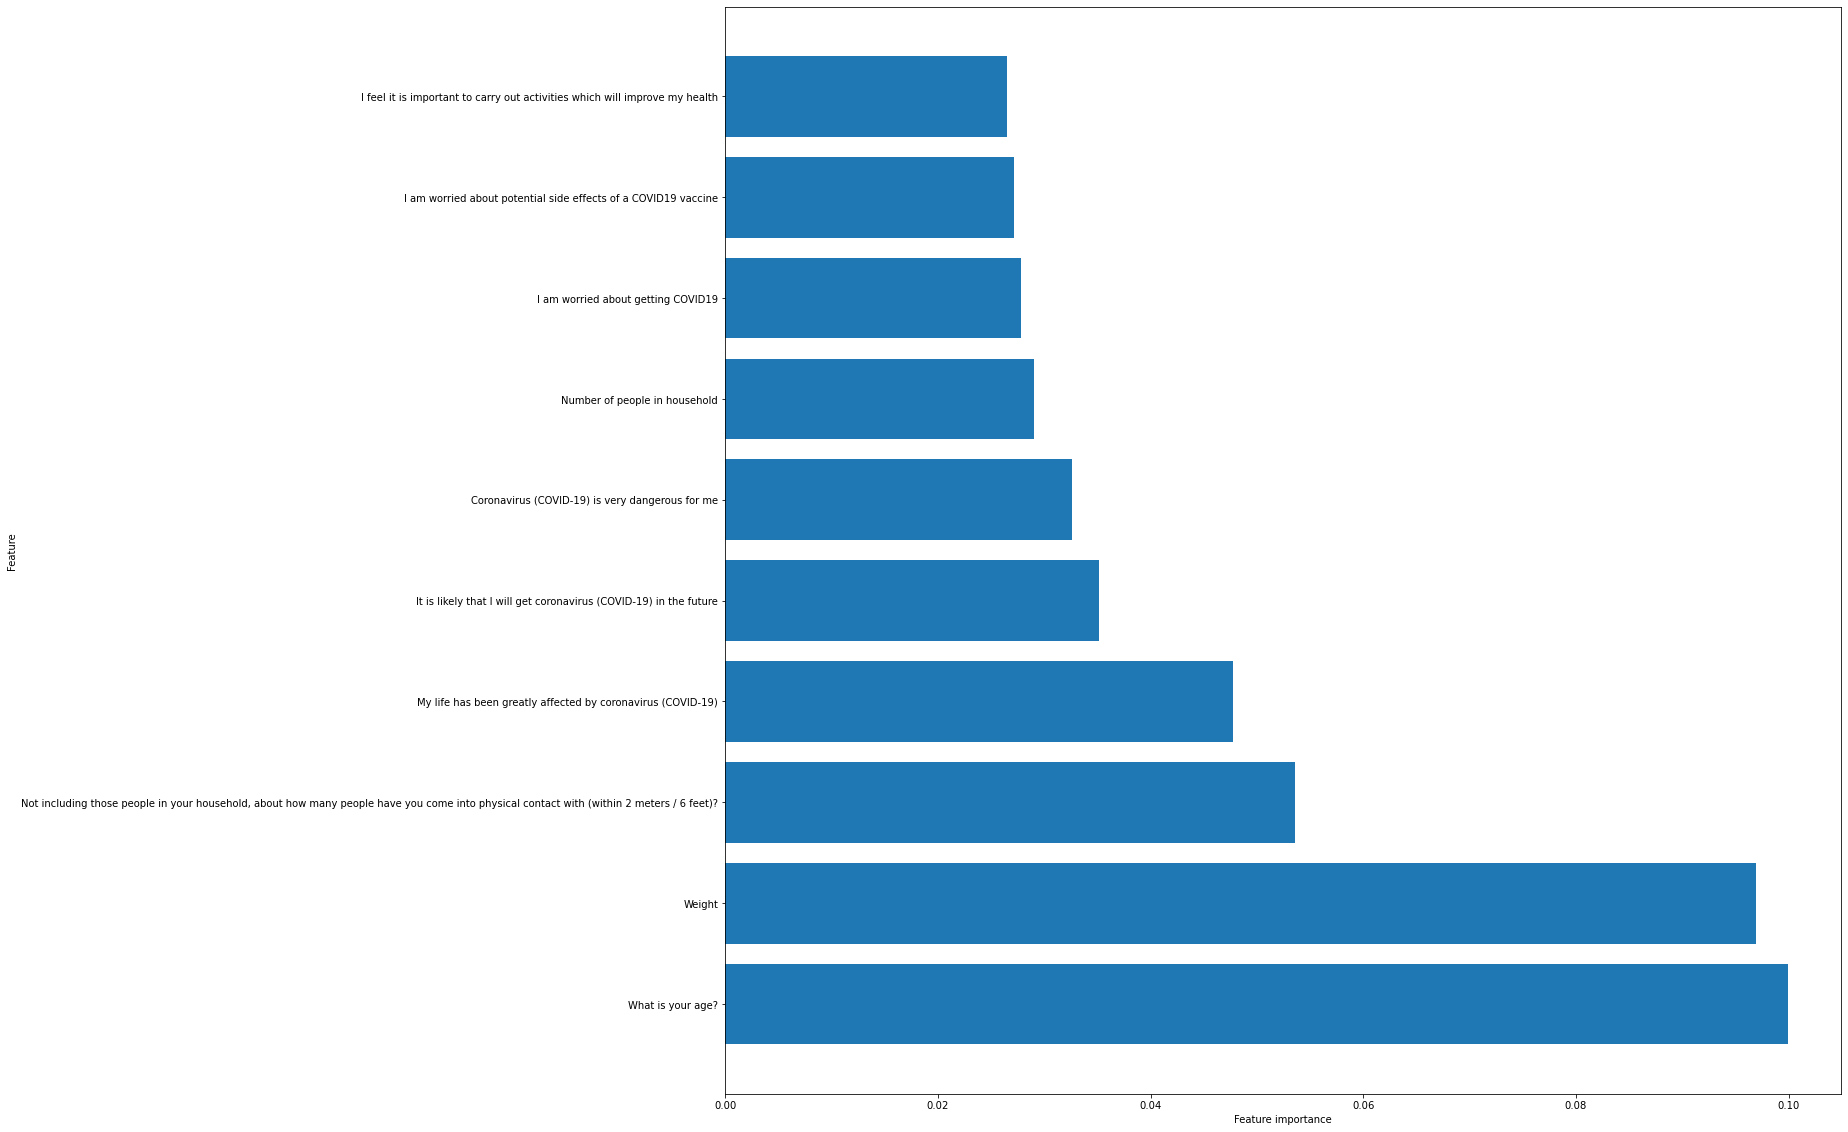

In [63]:
plot_feature_importances(clf_base, Xc_train, feat_lim=10)

### test parameters individually

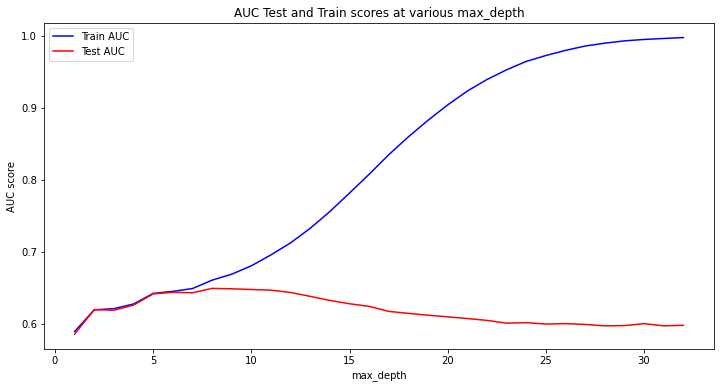

In [68]:
clf_depth_test = clone(clf_base)
clf_depth_test.fit(X_train, y_train)

test_params(max_depths, Xc_train, Xc_test, clf_depth_test, 'max_depth', model_type='tree')


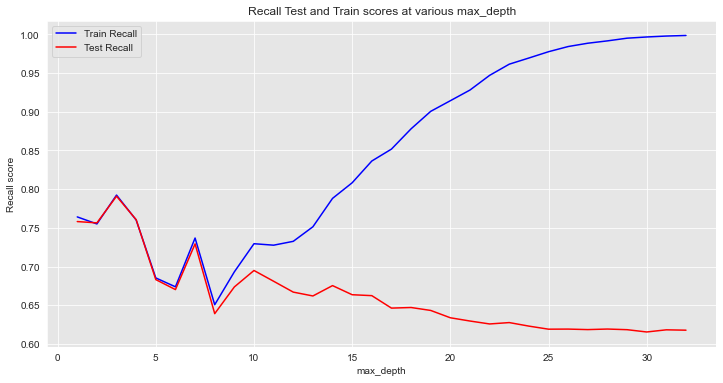

In [360]:
test_params(max_depths, Xc_train, Xc_test, clf_depth_test, 'max_depth', model_type='tree', rec='yes')

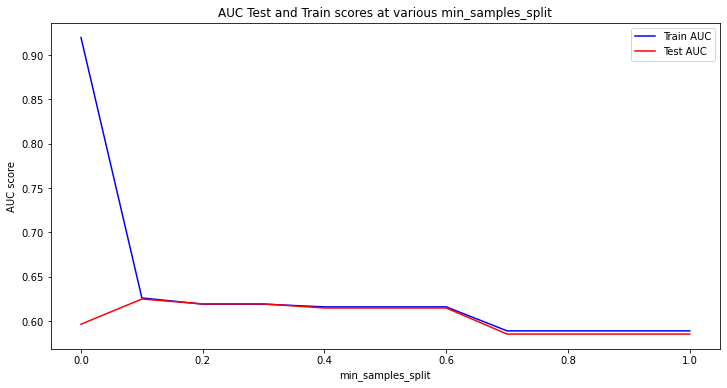

In [69]:
clf_min_samp_test = clone(clf_base)

test_params(min_samples_splits, Xc_train, Xc_test, clf_min_samp_test, 'min_samples_split', model_type='tree')

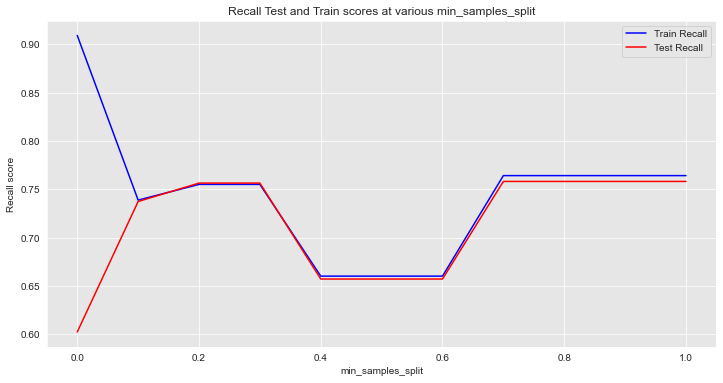

In [362]:
test_params(min_samples_splits, Xc_train, Xc_test, clf_min_samp_test, 'min_samples_split', model_type='tree', rec='yes')

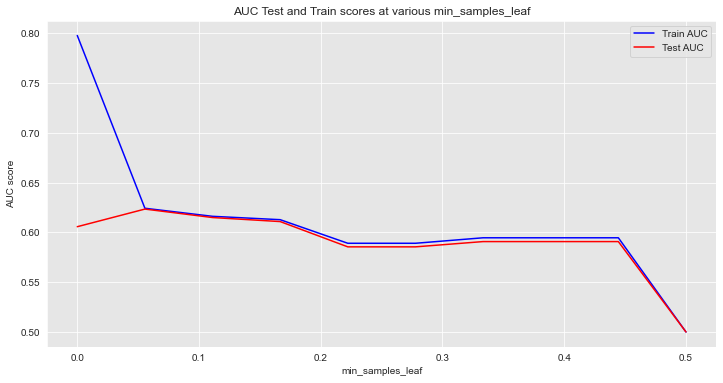

In [363]:
clf_min_samp_leaf_test = clone(clf_base)

test_params(min_samples_leafs, Xc_train, Xc_test, clf_min_samp_leaf_test, 'min_samples_leaf', model_type='tree')


No handles with labels found to put in legend.


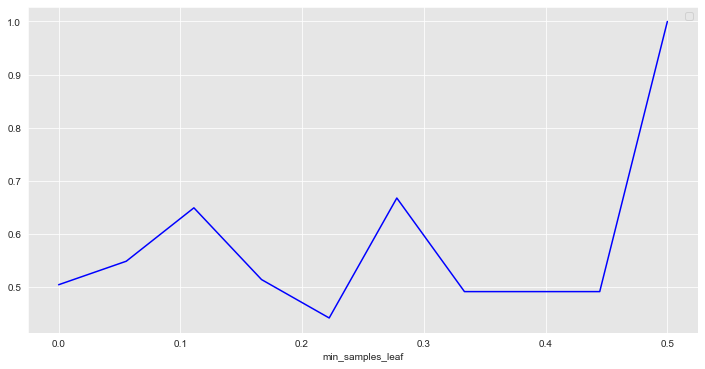

In [364]:
test_params(min_samples_leafs, Xc_train, Xc_test, clf_min_samp_leaf_test, 'min_samples_leaf', 
            model_type='tree', ones='yes', graph_type= 'tpr_v_fpr')

No handles with labels found to put in legend.


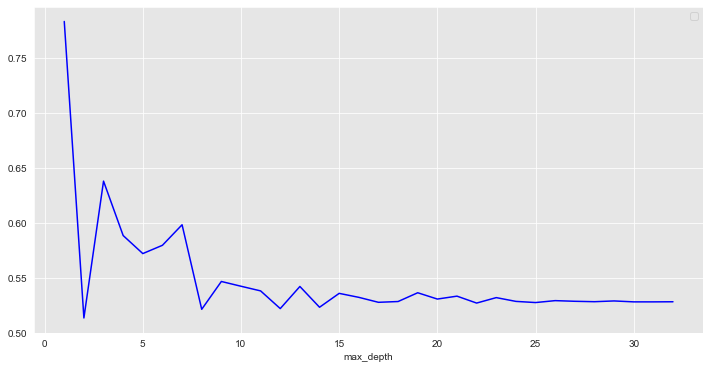

In [365]:
test_params(max_depths, Xc_train, Xc_test, clf_depth_test, 'max_depth', model_type='tree', ones='yes', graph_type= 'tpr_v_fpr')

No handles with labels found to put in legend.


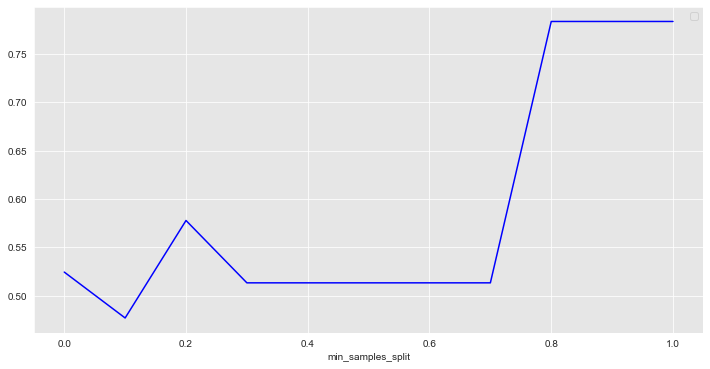

In [367]:
test_params(min_samples_splits, Xc_train, Xc_test, clf_min_samp_test, 'min_samples_split', model_type='tree', ones='yes', graph_type= 'tpr_v_fpr')

In [31]:
param_grid_tr = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [0.1, 0.2, 0.3],
    'min_samples_leaf': [1, 2, 3],
}

In [32]:
grid_tree = GridSearchCV(clf_base, param_grid_tr, scoring='accuracy', cv=None, n_jobs=1)
grid_tree.fit(Xc_train, y_train)

best_parameters = grid_tree.best_params_

In [33]:
best_parameters 

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 0.1}

### make tuned model


In [70]:
clf_tuned=DecisionTreeClassifier(criterion='entropy', max_depth =10, min_samples_split=0.1, 
                                 min_samples_leaf = 1)


In [71]:
clf_tuned.fit(Xc_train, y_train)

clftun_pred_train = clf_tuned.predict(Xc_train)
evaluation_metrics(clftun_pred_train, y_train)

[[23319 22095]
 [13233 37440]]
              precision    recall  f1-score   support

           0       0.64      0.51      0.57     45414
           1       0.63      0.74      0.68     50673

    accuracy                           0.63     96087
   macro avg       0.63      0.63      0.62     96087
weighted avg       0.63      0.63      0.63     96087



In [72]:
clftun_pred_test = clf_tuned.predict(X_test)
evaluation_metrics(clftun_pred_test, y_test)

[[ 7759  7380]
 [ 4436 12455]]
              precision    recall  f1-score   support

           0       0.64      0.51      0.57     15139
           1       0.63      0.74      0.68     16891

    accuracy                           0.63     32030
   macro avg       0.63      0.62      0.62     32030
weighted avg       0.63      0.63      0.63     32030



In [73]:
predictiont1, biast1, contributionst1 = ti.predict(clf_tuned, Xc_test)

coeff for What is your age? is [0.023735374303614488]
coeff for And how much confidence do you have in the NHS to respond to a Coronavirus (COVID-19) outbreak in the UK? is [0.005948202739717312]
coeff for Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)? is [0.0]
coeff for If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days? is [0.0]
coeff for Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road) is [0.0]
coeff for Washed hands with soap and water is [0.0]
coeff for Used hand sanitiser is [0.0]
coeff for Covered your nose and mouth when sneezing or coughing is [0.0]
coeff for Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus is [0.0]
coeff for Avoided going to hospital or other healthcare setting

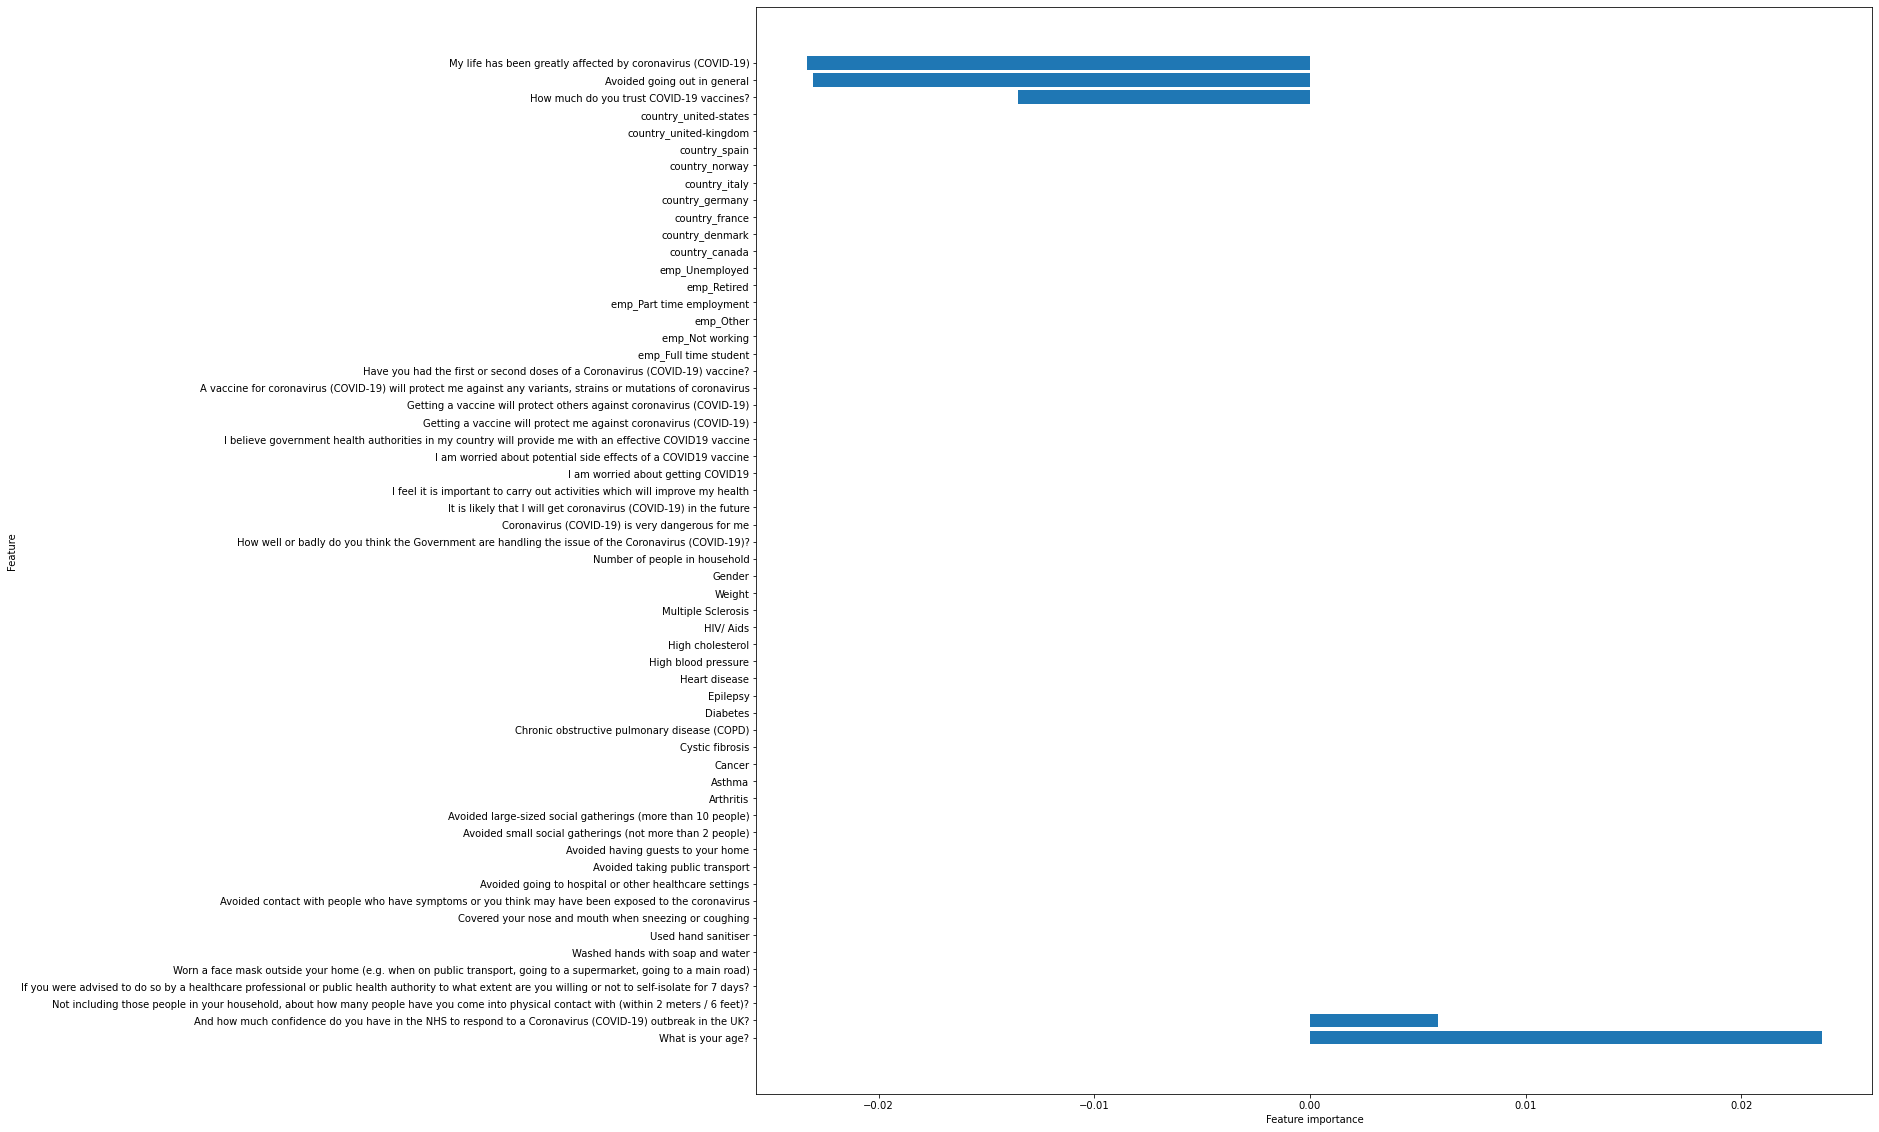

[('age', 0.023735374303614488),
 ('WCRex2', 0.005948202739717312),
 ('i2_health', 0.0),
 ('i11_health', 0.0),
 ('i12_health_1', 0.0),
 ('i12_health_2', 0.0),
 ('i12_health_3', 0.0),
 ('i12_health_4', 0.0),
 ('i12_health_5', 0.0),
 ('i12_health_7', 0.0),
 ('i12_health_8', 0.0),
 ('i12_health_11', 0.0),
 ('i12_health_12', 0.0),
 ('i12_health_14', 0.0),
 ('d1_health_1', 0.0),
 ('d1_health_2', 0.0),
 ('d1_health_3', 0.0),
 ('d1_health_4', 0.0),
 ('d1_health_5', 0.0),
 ('d1_health_6', 0.0),
 ('d1_health_7', 0.0),
 ('d1_health_8', 0.0),
 ('d1_health_9', 0.0),
 ('d1_health_10', 0.0),
 ('d1_health_11', 0.0),
 ('d1_health_13', 0.0),
 ('weight', 0.0),
 ('gender', 0.0),
 ('household_size', 0.0),
 ('WCRex1', 0.0),
 ('r1_1', 0.0),
 ('r1_2', 0.0),
 ('r1_6', 0.0),
 ('vac2_1', 0.0),
 ('vac2_2', 0.0),
 ('vac2_3', 0.0),
 ('r1_8', 0.0),
 ('r1_9', 0.0),
 ('vac2_7', 0.0),
 ('vac', 0.0),
 ('emp_Full time student', 0.0),
 ('emp_Not working', 0.0),
 ('emp_Other', 0.0),
 ('emp_Part time employment', 0.0),
 ('e

In [74]:
important_cols(contributionst1)

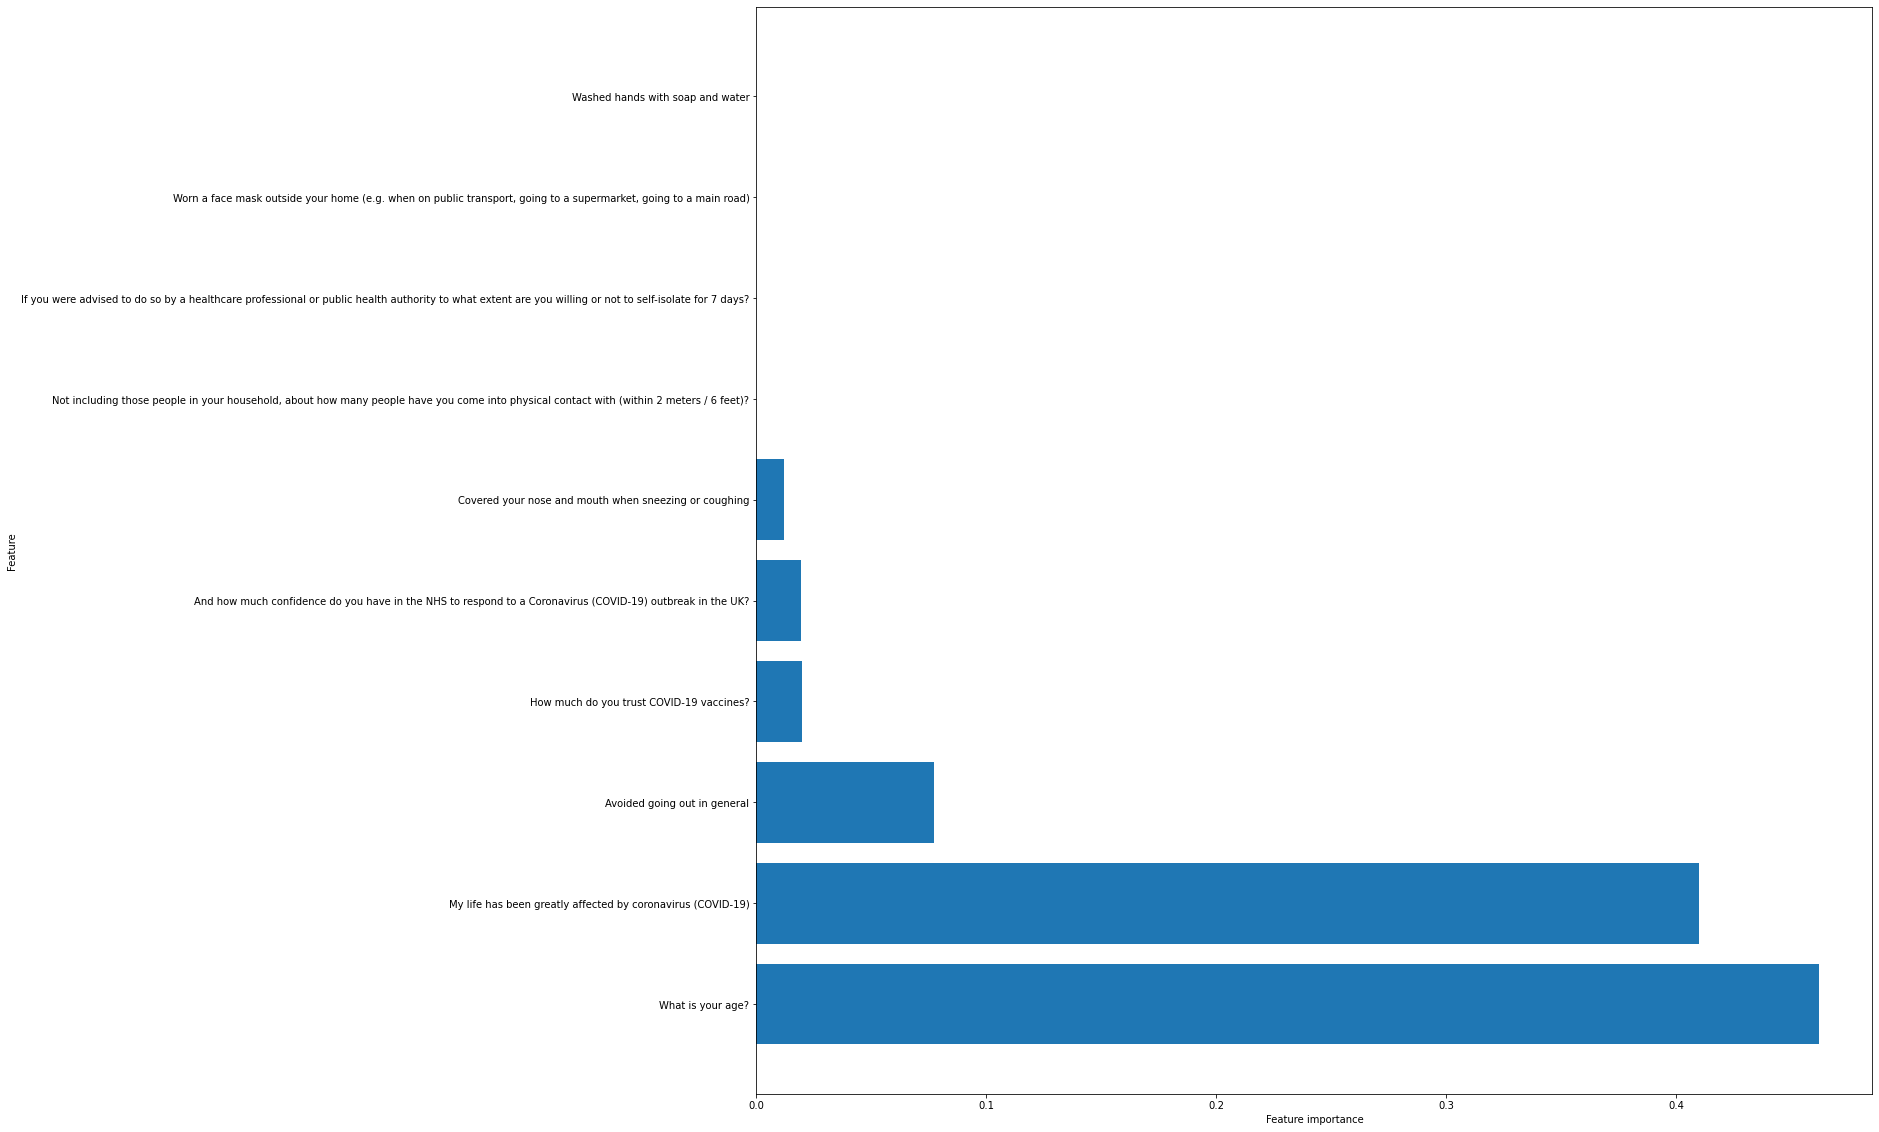

In [75]:
plot_feature_importances(clf_tuned, Xc_train, feat_lim=10)

## Random forest

### bag

In [76]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [77]:
bagged_tree.fit(Xc_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [78]:
bt_pred_test = bagged_tree.predict(Xc_test)
evaluation_metrics(bt_pred_test, y_test)

[[ 8220  6919]
 [ 4305 12586]]
              precision    recall  f1-score   support

           0       0.66      0.54      0.59     15139
           1       0.65      0.75      0.69     16891

    accuracy                           0.65     32030
   macro avg       0.65      0.64      0.64     32030
weighted avg       0.65      0.65      0.65     32030



In [79]:
bt_pred_train = bagged_tree.predict(Xc_train)
evaluation_metrics(bt_pred_train, y_train)

[[24795 20619]
 [12725 37948]]
              precision    recall  f1-score   support

           0       0.66      0.55      0.60     45414
           1       0.65      0.75      0.69     50673

    accuracy                           0.65     96087
   macro avg       0.65      0.65      0.65     96087
weighted avg       0.65      0.65      0.65     96087



In [195]:
param_grid_bag = {
    'max_features': [0.2, 0.4, 0.6, 1.0],
    'max_samples': [0.2, 0.4, 0.6, 1.0],
    'n_estimators': [10, 50, 70],
}

In [196]:
grid_bag = GridSearchCV(bagged_tree, param_grid_bag, scoring='accuracy', cv=None, n_jobs=1)
grid_bag.fit(Xc_train, y_train)

best_parameters_tree = grid_bag.best_params_

In [197]:
best_parameters_tree

{'max_features': 0.6, 'max_samples': 6, 'n_estimators': 70}

### tuned bag

In [80]:
tuned_bagged = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=10),
                                 max_features= 0.6, max_samples= 0.6, n_estimators= 70)

In [81]:
tuned_bagged.fit(Xc_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_features=0.6, max_samples=0.6, n_estimators=70)

In [82]:
tb_pred_test = tuned_bagged.predict(Xc_test)
evaluation_metrics(tb_pred_test, y_test)

[[ 9064  6075]
 [ 4265 12626]]
              precision    recall  f1-score   support

           0       0.68      0.60      0.64     15139
           1       0.68      0.75      0.71     16891

    accuracy                           0.68     32030
   macro avg       0.68      0.67      0.67     32030
weighted avg       0.68      0.68      0.68     32030



In [83]:
tb_pred_train = tuned_bagged.predict(Xc_train)
evaluation_metrics(tb_pred_train, y_train)

[[29296 16118]
 [10499 40174]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69     45414
           1       0.71      0.79      0.75     50673

    accuracy                           0.72     96087
   macro avg       0.72      0.72      0.72     96087
weighted avg       0.72      0.72      0.72     96087



## forest

In [37]:
class RandomForestClassifierThreshold(RandomForestClassifier):
    '''extend predict method for thresholds'''
    def predict(self, X, threshold=None):
        if threshold == None: 
            return RandomForestClassifier.predict(self, X)
        else:
            y_scores = RandomForestClassifier.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold

In [85]:
forest = RandomForestClassifier()
forest.fit(Xc_train, y_train)

RandomForestClassifier()

In [86]:
forest_pred_train = forest.predict(Xc_train)
evaluation_metrics(forest_pred_train, y_train)

[[45414     0]
 [    0 50673]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45414
           1       1.00      1.00      1.00     50673

    accuracy                           1.00     96087
   macro avg       1.00      1.00      1.00     96087
weighted avg       1.00      1.00      1.00     96087



In [87]:
forest_pred_test = forest.predict(Xc_test)
evaluation_metrics(forest_pred_test, y_test)

[[ 9733  5406]
 [ 4651 12240]]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66     15139
           1       0.69      0.72      0.71     16891

    accuracy                           0.69     32030
   macro avg       0.69      0.68      0.68     32030
weighted avg       0.69      0.69      0.69     32030



In [238]:
param_grid_for = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [0.3, 0.6],
    'n_estimators': [20, 50, 100],
}

In [239]:
make_grid(forest, param_grid_for, Xc_train, y_train, Xc_test, y_test)

Grid Search found the following optimal parameters: 
max_depth: 10
min_samples_split: 0.3
n_estimators: 100

Training Accuracy: 64.39%
Validation accuracy: 64.51%


### tuned model

In [88]:
forest_tuned = RandomForestClassifierThreshold(max_depth=10, min_samples_split= 0.3, n_estimators= 100)
forest_tuned.fit(Xc_train, y_train)

RandomForestClassifierThreshold(max_depth=10, min_samples_split=0.3)

In [89]:
forest_tun_pred_train = forest_tuned.predict(Xc_train)
evaluation_metrics(forest_tun_pred_train, y_train)

[[22036 23378]
 [10943 39730]]
              precision    recall  f1-score   support

           0       0.67      0.49      0.56     45414
           1       0.63      0.78      0.70     50673

    accuracy                           0.64     96087
   macro avg       0.65      0.63      0.63     96087
weighted avg       0.65      0.64      0.63     96087



In [90]:
forest_tun_pred_test = forest_tuned.predict(Xc_test)
evaluation_metrics(forest_tun_pred_test, y_test)

[[ 7352  7787]
 [ 3631 13260]]
              precision    recall  f1-score   support

           0       0.67      0.49      0.56     15139
           1       0.63      0.79      0.70     16891

    accuracy                           0.64     32030
   macro avg       0.65      0.64      0.63     32030
weighted avg       0.65      0.64      0.63     32030



### test thresholds

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


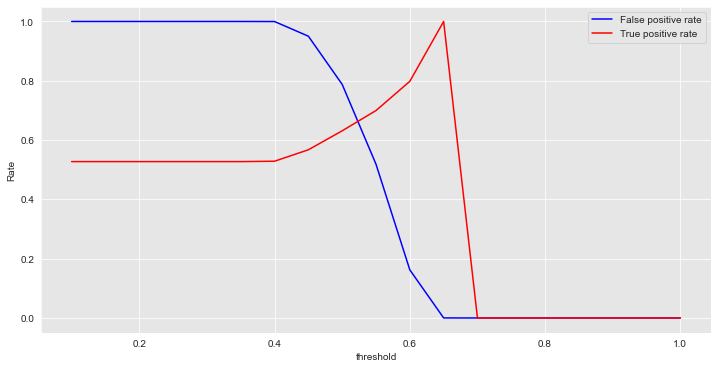

In [262]:
thresh = np.linspace(0.1, 1, 19, endpoint=True)
test_params(thresh, Xc_train, Xc_test, forest_tuned, 'threshold', test_train='test', graph_type='tpr_v_fpr')


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
No handles with labels found to put in legend.


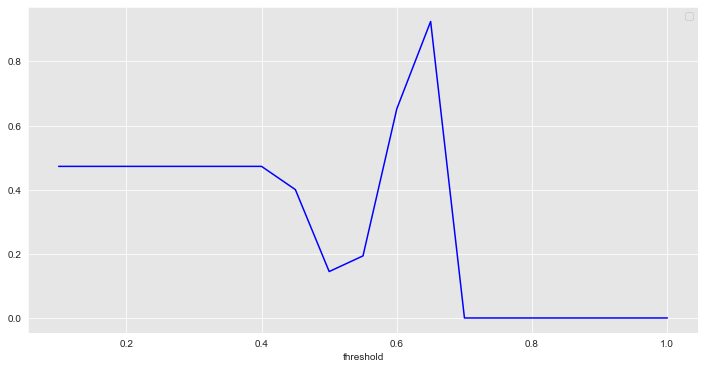

In [264]:
test_params(thresh, Xc_train, Xc_test, forest_tuned, 'threshold', test_train='test', y_ax='diff_list', graph_type='tpr_v_fpr')
 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
No handles with labels found to put in legend.


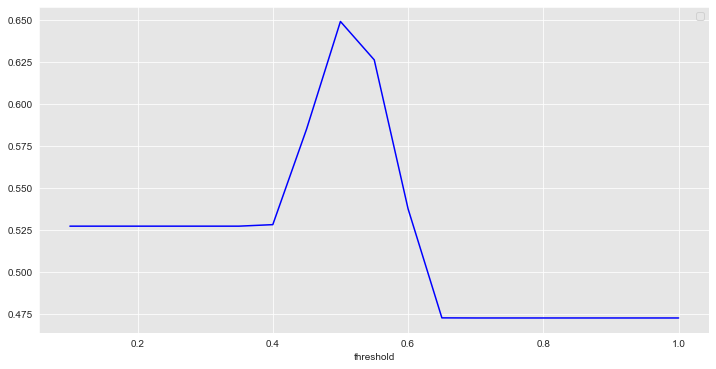

In [265]:
test_params(thresh, Xc_train, Xc_test, forest_tuned, 'threshold', test_train='test', y_ax='acc_list', graph_type='tpr_v_fpr')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

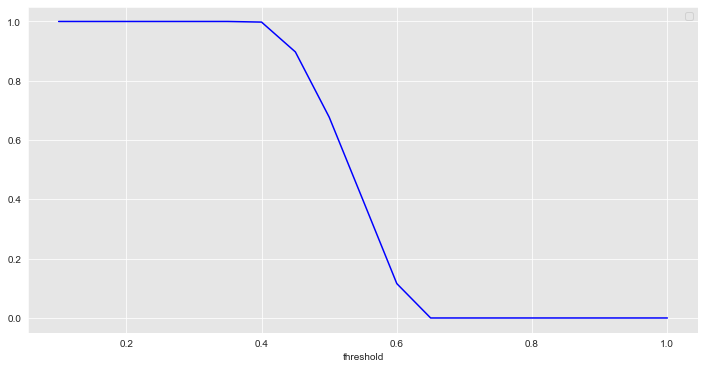

In [266]:
test_params(thresh, Xc_train, Xc_test, forest_tuned, 'threshold', test_train='test', graph_type='tpr_v_fpr', ones=True)

In [91]:
forest_tun_pred_test = forest_tuned.predict(Xc_test, threshold=0.48)
evaluation_metrics(forest_tun_pred_test, y_test)

[[ 5533  9606]
 [ 2171 14720]]
              precision    recall  f1-score   support

           0       0.72      0.37      0.48     15139
           1       0.61      0.87      0.71     16891

    accuracy                           0.63     32030
   macro avg       0.66      0.62      0.60     32030
weighted avg       0.66      0.63      0.61     32030



In [251]:
yc_train_score = forest_tuned.predict_proba(X_train)[:, 1]

yc_test_score = forest_tuned.predict_proba(X_test)[:, 1]


AUC: 0.6947430225792705


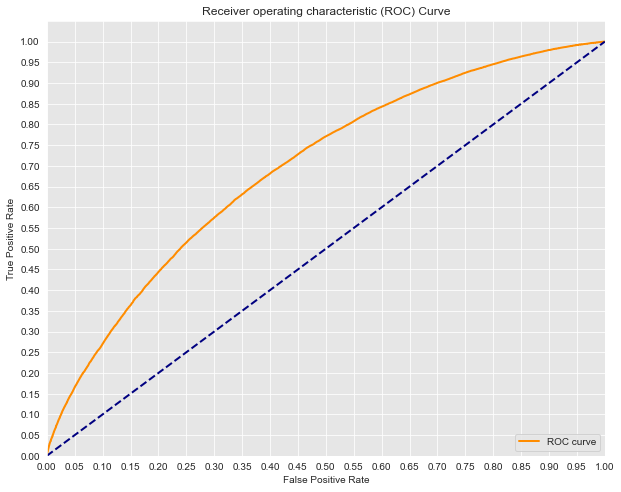

In [252]:
make_roc_curve(yc_train_score, y_train, model_type='forest')

AUC: 0.6952215353871405


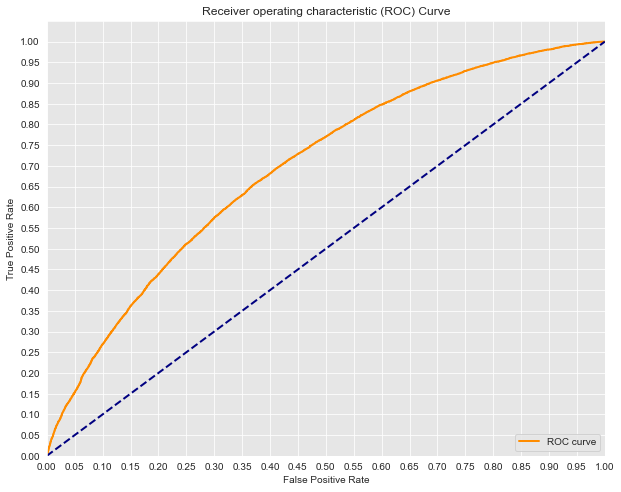

In [254]:
make_roc_curve(yc_test_score, y_test, model_type='forest')

### important features

In [92]:
prediction_for, bias_for, contributions_for = ti.predict(forest_tuned, Xc_test)

coeff for It is likely that I will get coronavirus (COVID-19) in the future is [0.006833947736965109]
coeff for What is your age? is [0.004760649541694801]
coeff for country_italy is [0.00348804255085904]
coeff for emp_Retired is [0.0009619283307781629]
coeff for I am worried about getting COVID19 is [0.0008837514204590041]
coeff for Number of people in household is [0.0008218250142578715]
coeff for Have you had the first or second doses of a Coronavirus (COVID-19) vaccine? is [0.00042988110219457313]
coeff for Avoided large-sized social gatherings (more than 10 people) is [0.0002154491099566989]
coeff for Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road) is [9.514931241467114e-05]
coeff for country_germany is [3.28930751791599e-05]
coeff for Asthma is [1.9388062209611246e-05]
coeff for If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate 

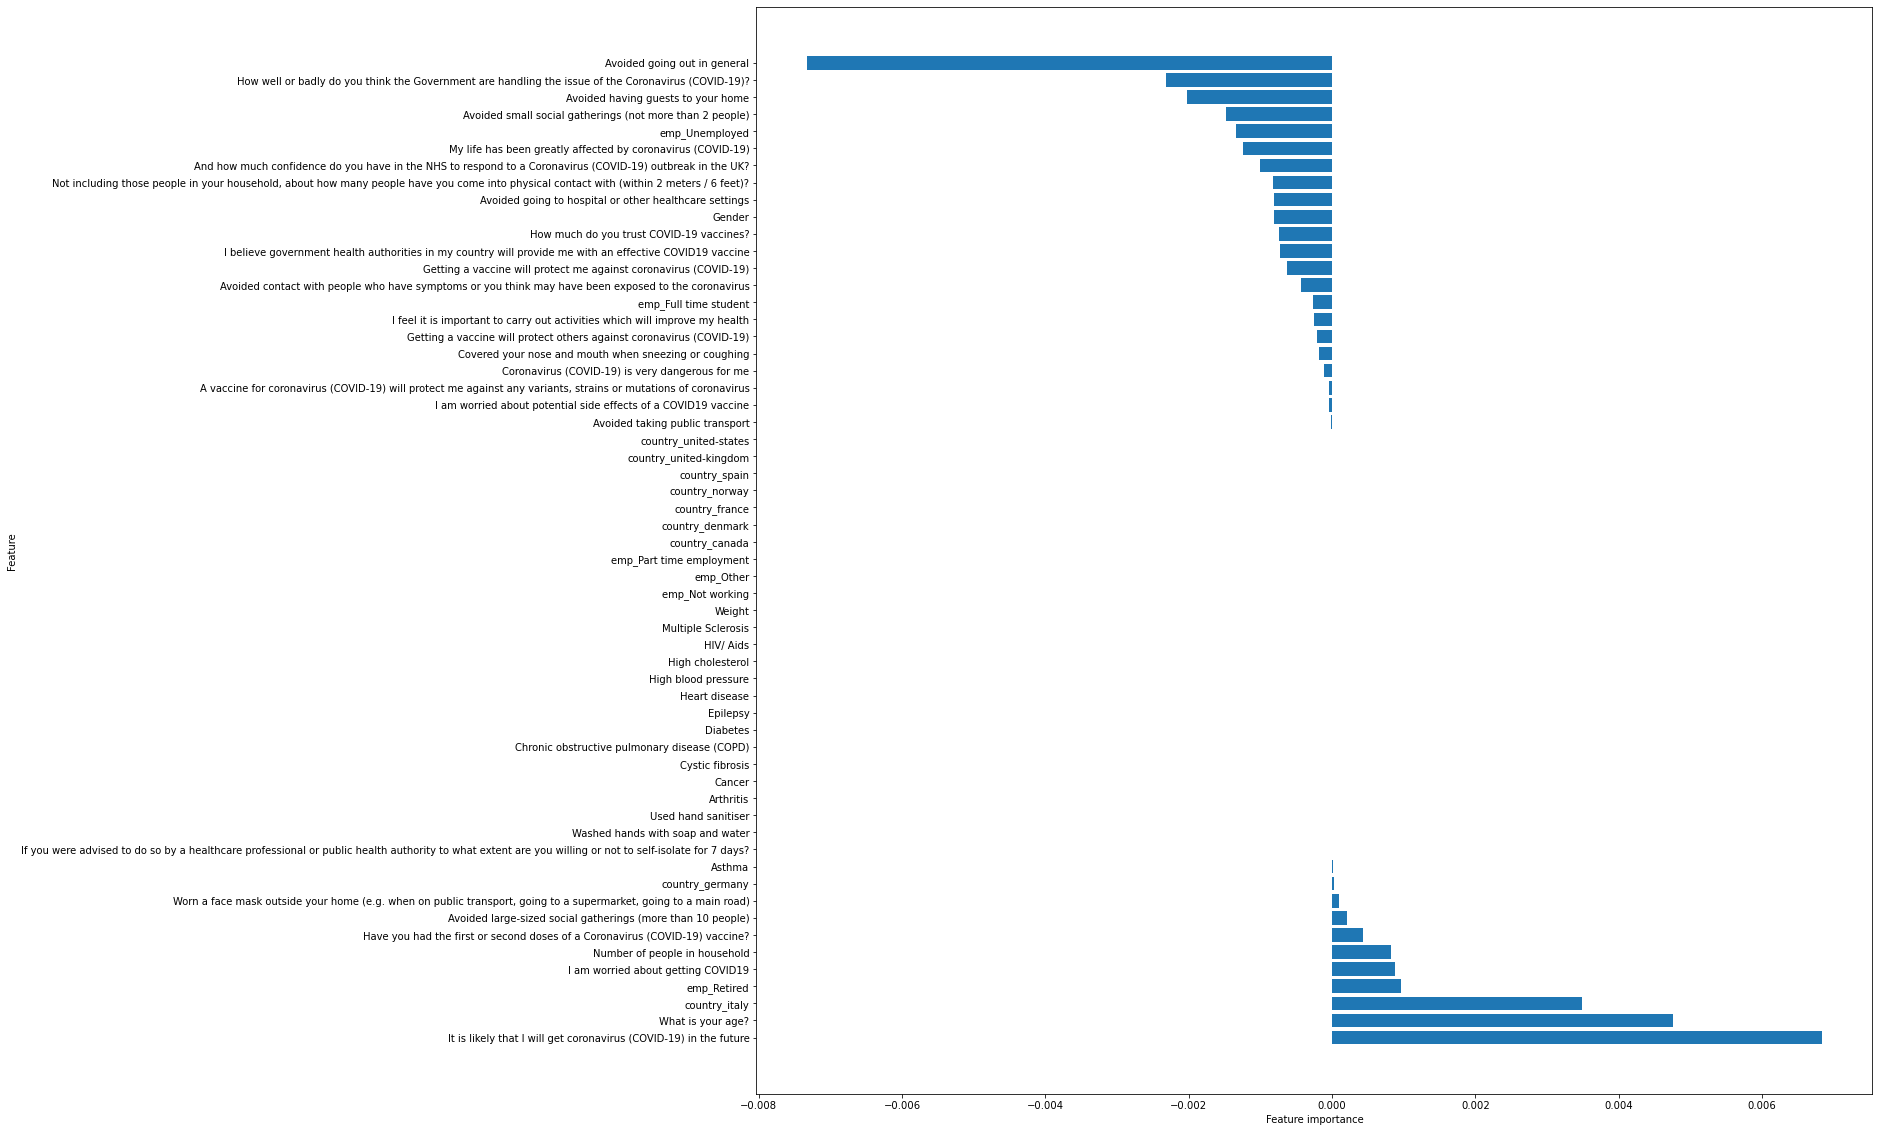

In [93]:
for_imp=important_cols(contributions_for)


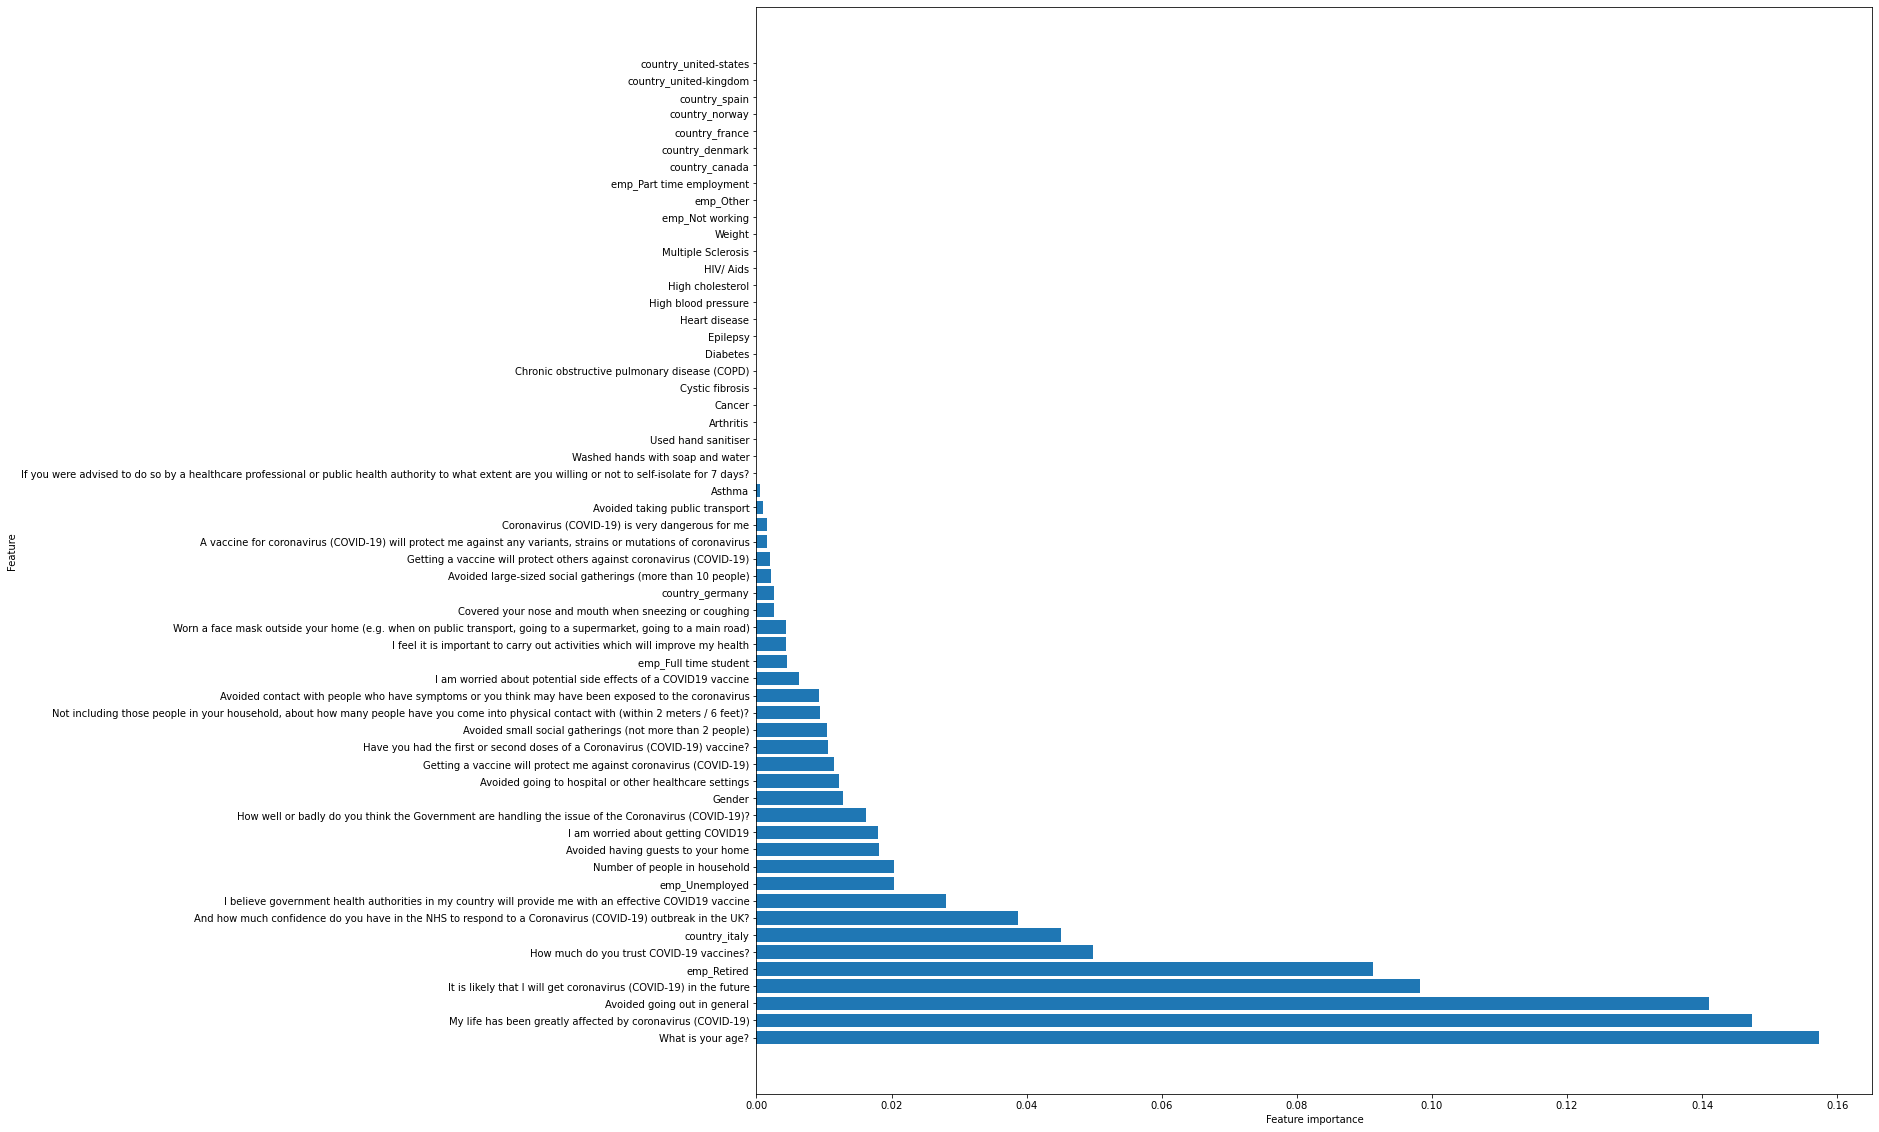

In [94]:
plot_feature_importances(forest_tuned, Xc_train, feat_lim=None)

In [95]:
explainer_for = shap.TreeExplainer(forest_tuned)
shap_val_for = explainer_for.shap_values(Xc_train)
shap_obj_for = explainer_for(Xc_train)


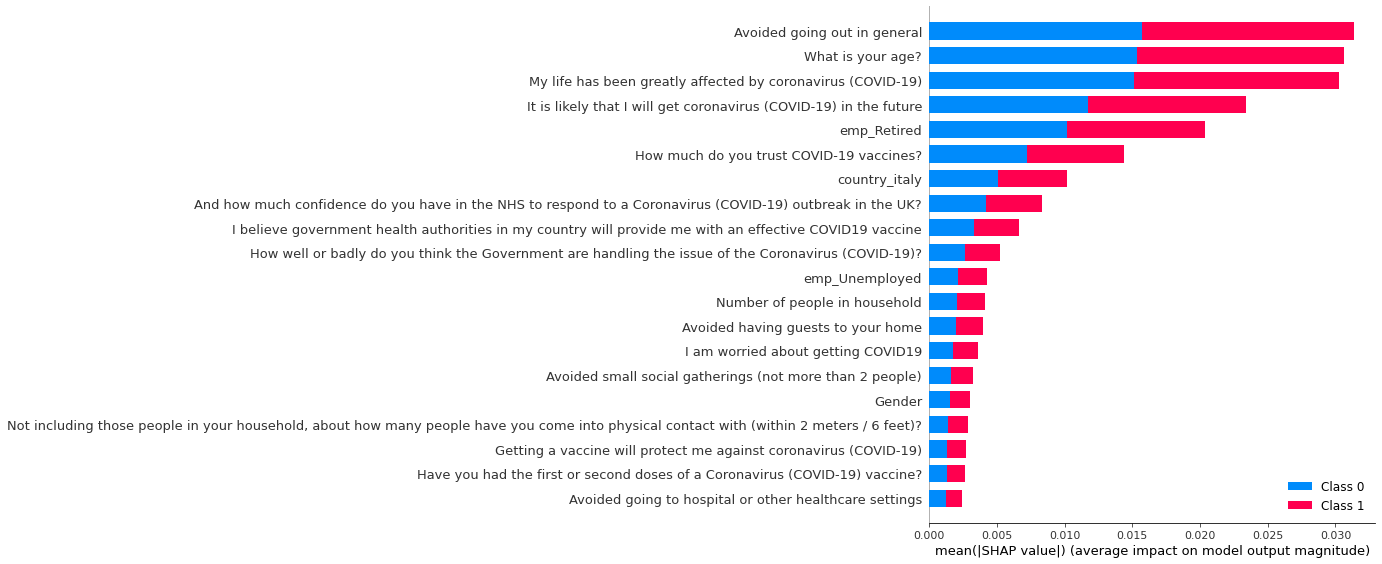

In [96]:
shap.summary_plot(shap_val_for, Xc_train, plot_type="bar")

In [97]:
shap_obj_y = shap_obj_for[:,:,0]
shap_obj_z = shap_obj_for[:,:,1]

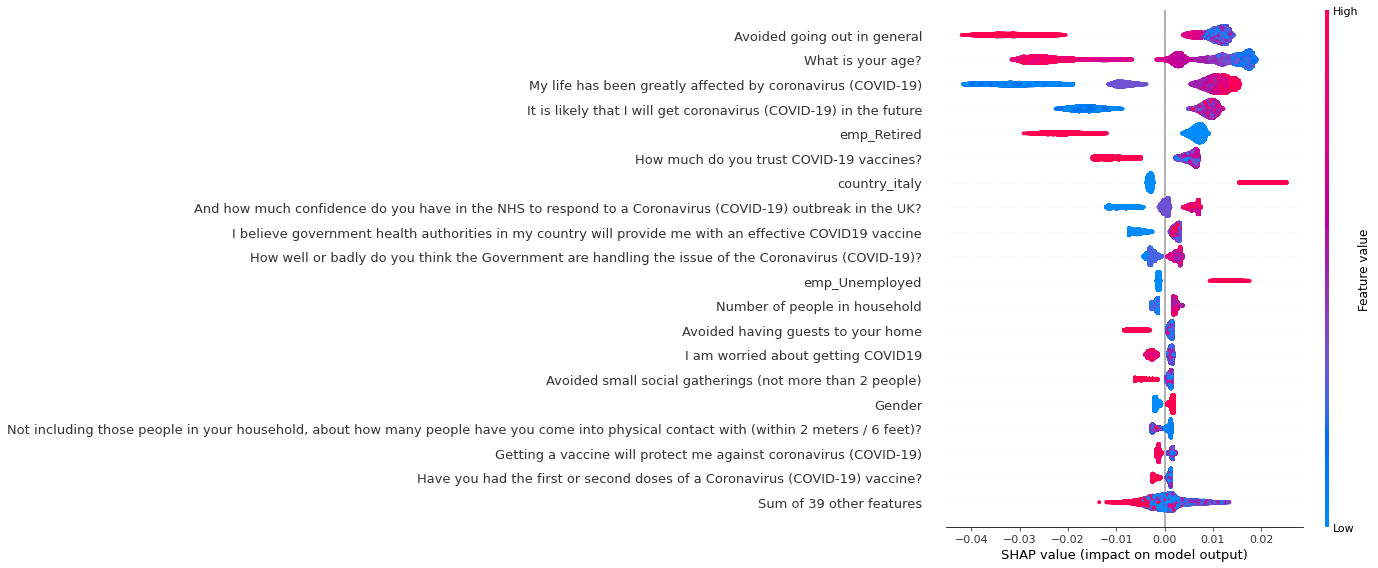

In [98]:
shap.plots.beeswarm(shap_obj_z, max_display=20)

## GBoost

In [78]:
class XGBClassifierThreshold(XGBClassifier):
    def predict(self, X, threshold=None):
        if threshold == None: 
            return XGBClassifier.predict(self, X)
        else:
            y_scores = XGBClassifier.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold

### base model


In [79]:
xgb = XGBClassifierThreshold(base_score=0.4)

xgb.fit(Xc_train, y_train)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:23:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifierThreshold(base_score=0.4, booster='gbtree', colsample_bylevel=1,
                       colsample_bynode=1, colsample_bytree=1,
                       enable_categorical=False, gamma=0, gpu_id=-1,
                       importance_type=None, interaction_constraints='',
                       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                       min_child_weight=1, missing=nan,
                       monotone_constraints='()', n_estimators=100, n_jobs=6,
                       num_parallel_tree=1, predictor='auto', random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                       subsample=1, tree_method='exact', validate_parameters=1,
                       verbosity=None)

In [101]:
xgb_pred_tr = xgb.predict(Xc_train)
xgb_pred_te = xgb.predict(Xc_test)
xgb_pred_te_pr = xgb.predict_proba(Xc_test)

In [102]:
evaluation_metrics(xgb_pred_tr, y_train)

[[32393 13021]
 [11018 39655]]
              precision    recall  f1-score   support

           0       0.75      0.71      0.73     45414
           1       0.75      0.78      0.77     50673

    accuracy                           0.75     96087
   macro avg       0.75      0.75      0.75     96087
weighted avg       0.75      0.75      0.75     96087



In [103]:
evaluation_metrics(xgb_pred_te, y_test)

[[ 9669  5470]
 [ 4604 12287]]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66     15139
           1       0.69      0.73      0.71     16891

    accuracy                           0.69     32030
   macro avg       0.68      0.68      0.68     32030
weighted avg       0.69      0.69      0.68     32030



AUC: 0.7510565591485002


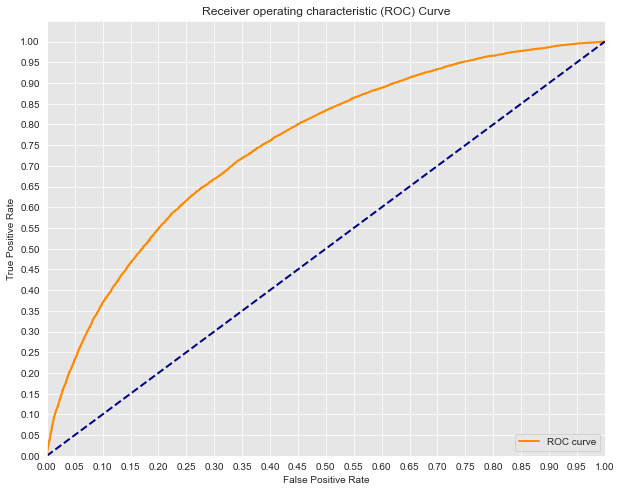

In [73]:
make_roc_curve(xgb_pred_te_pr[:,1], y_test, model_type='xgb')

In [79]:
x_th = xgb.predict(Xc_test, threshold=0.38)
evaluation_metrics(x_th, y_test)

[[ 7045  8094]
 [ 2466 14425]]
              precision    recall  f1-score   support

           0       0.74      0.47      0.57     15139
           1       0.64      0.85      0.73     16891

    accuracy                           0.67     32030
   macro avg       0.69      0.66      0.65     32030
weighted avg       0.69      0.67      0.66     32030



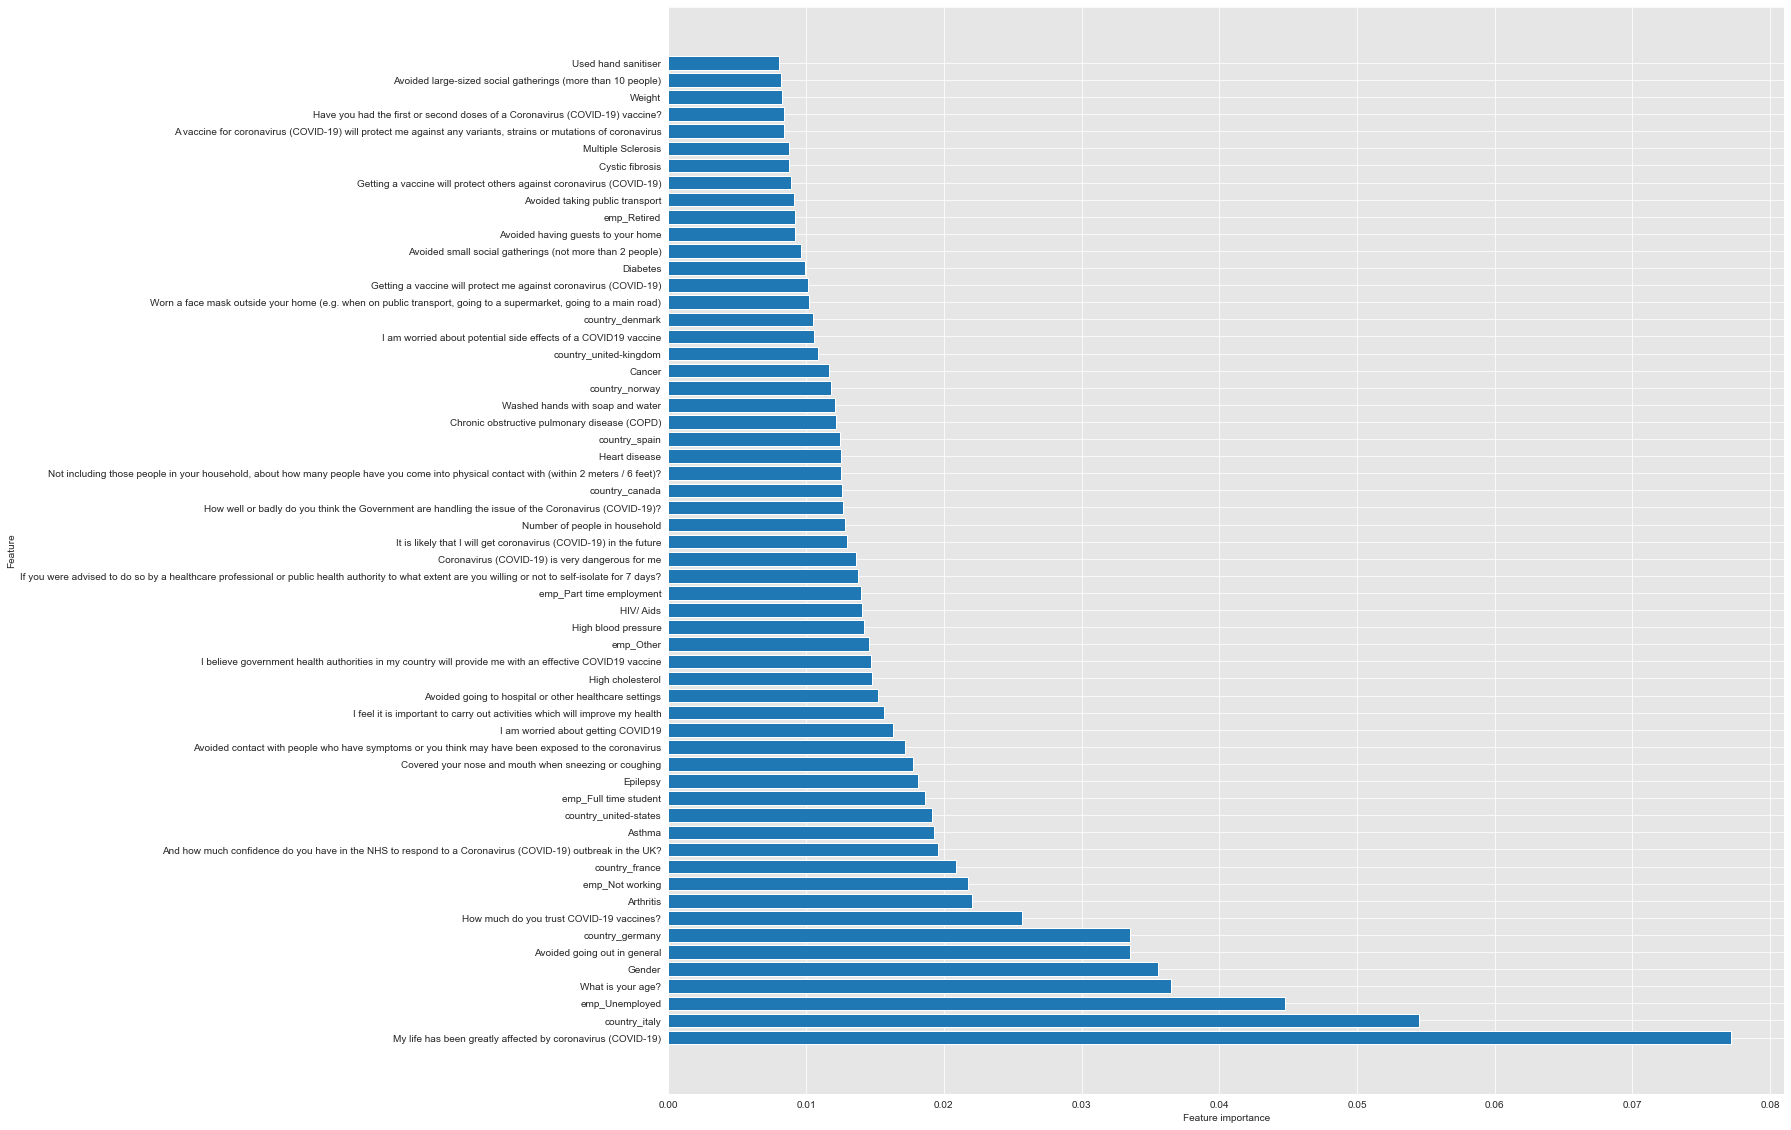

In [80]:
plot_feature_importances(xgb, Xc_test)

### tune model

In [ ]:
(base_score=0.4, booster='gbtree', colsample_bylevel=1,
                       colsample_bynode=1, colsample_bytree=1,
                       enable_categorical=False, gamma=0, gpu_id=-1,
                       importance_type=None, interaction_constraints='',
                       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                       min_child_weight=1, missing=nan,
                       monotone_constraints='()', n_estimators=100, n_jobs=6,
                       num_parallel_tree=1, predictor='auto', random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                       subsample=1, tree_method='exact', validate_parameters=1,
                       verbosity=None)

In [84]:
param_grid_xgb = {
    'gamma': [0, 5, 10],
    'learning_rate': [0.001, 0.1, 0.2],
    'max_depth': [5, 10 ,20],
    'subsample': [0.5, 0.7],
    'n_estimators': [25, 50, 100]
}

In [86]:
# takes a long time
grid_xgb= make_grid(xgb, param_grid_xgb, Xc_train, y_train, Xc_test, y_test)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:56:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[12:58:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:02:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:09:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:11:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:15:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:21:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:21:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:21:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:21:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:24:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:24:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:24:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:24:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:30:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:34:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:38:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:46:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:46:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:46:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:46:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:48:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:52:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:59:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:59:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:59:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:00:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:02:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:07:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:07:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:07:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:12:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:12:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:12:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:13:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:15:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:23:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:25:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:25:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:25:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:25:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:29:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:36:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:38:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:42:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [80]:
xgb_tuned = XGBClassifierThreshold(max_depth=20, learning_rate=0.1, n_estimators=100, subsample=0.7, gamma=10)

xgb_tuned.fit(Xc_train, y_train)


[11:23:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifierThreshold(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bynode=1, colsample_bytree=1,
                       enable_categorical=False, gamma=10, gpu_id=-1,
                       importance_type=None, interaction_constraints='',
                       learning_rate=0.1, max_delta_step=0, max_depth=20,
                       min_child_weight=1, missing=nan,
                       monotone_constraints='()', n_estimators=100, n_jobs=6,
                       num_parallel_tree=1, predictor='auto', random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                       subsample=0.7, tree_method='exact',
                       validate_parameters=1, verbosity=None)

In [81]:
xgb_tun_pred_test = xgb_tuned.predict(Xc_test)
evaluation_metrics(xgb_tun_pred_test, y_test)

[[ 9754  5385]
 [ 4531 12360]]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66     15139
           1       0.70      0.73      0.71     16891

    accuracy                           0.69     32030
   macro avg       0.69      0.69      0.69     32030
weighted avg       0.69      0.69      0.69     32030



In [82]:
xgb_tun_pred1_test = xgb_tuned.predict(Xc_test, threshold=0.4)
evaluation_metrics(xgb_tun_pred1_test, y_test)

[[ 7544  7595]
 [ 2691 14200]]
              precision    recall  f1-score   support

           0       0.74      0.50      0.59     15139
           1       0.65      0.84      0.73     16891

    accuracy                           0.68     32030
   macro avg       0.69      0.67      0.66     32030
weighted avg       0.69      0.68      0.67     32030



In [106]:
d_train = xgboost.DMatrix(Xc_train, label=y_train)
d_test = xgboost.DMatrix(Xc_test, label=y_test)

### feature importance 

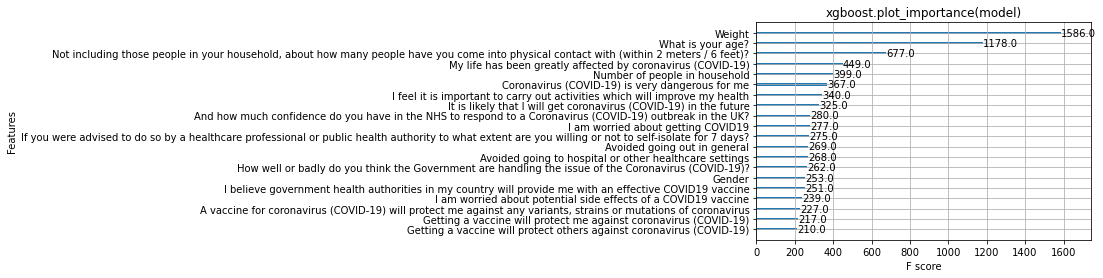

In [107]:
xgboost.plot_importance(xgb_tuned, max_num_features=20)
plt.title("xgboost.plot_importance(model)")
plt.show()

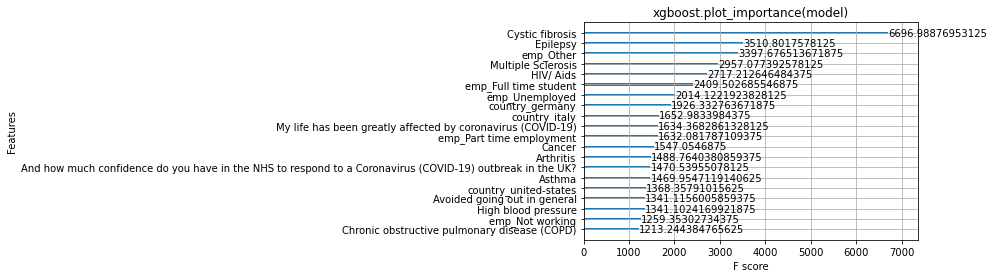

In [108]:
xgboost.plot_importance(xgb_tuned, importance_type="cover", max_num_features=20)
plt.title("xgboost.plot_importance(model)")
plt.show()

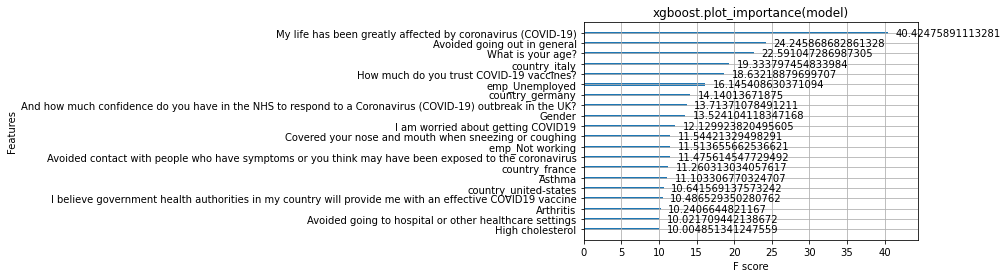

In [109]:
xgboost.plot_importance(xgb_tuned, importance_type="gain", max_num_features=20)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [101]:
explainer_xgb = shap.TreeExplainer(xgb_tuned)
shap_val_xgb = explainer_xgb.shap_values(Xc)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [107]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])


NameError: name 'explainer' is not defined

100%|===================| 32020/32030 [06:01<00:00]        

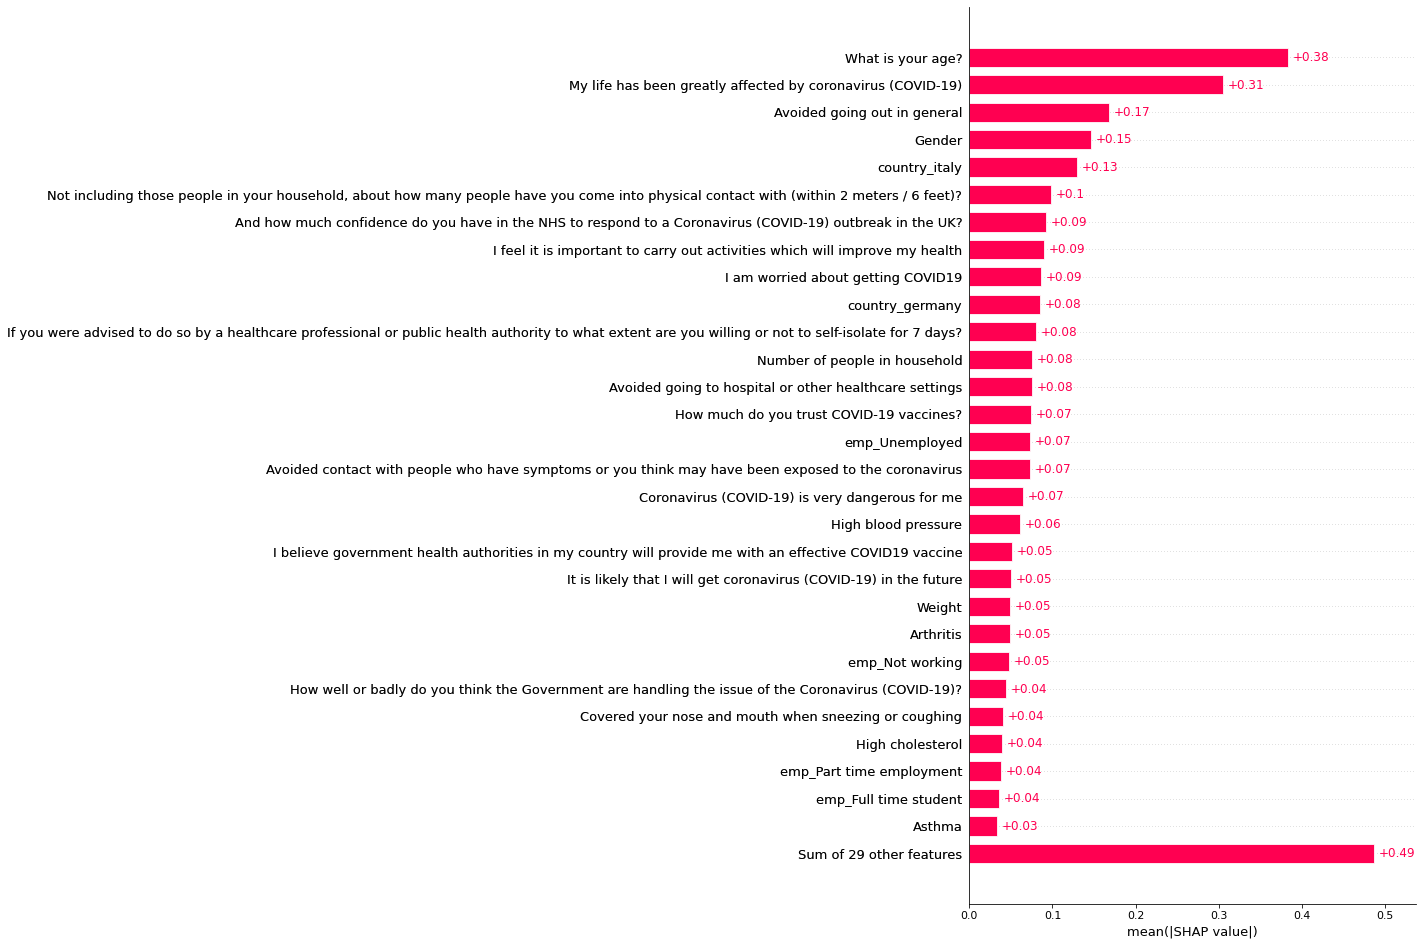

In [99]:

masker_xgb = shap.maskers.Independent(data = Xc_train)

explainer_xgb = shap.Explainer(xgb_tuned, masker = masker_xgb)
shap_val_x = explainer_xgb(Xc_test)

shap.plots.bar(shap_val_x, max_display=30, show=False)
plt.savefig("xgb_imp.png",dpi=150, bbox_inches='tight')

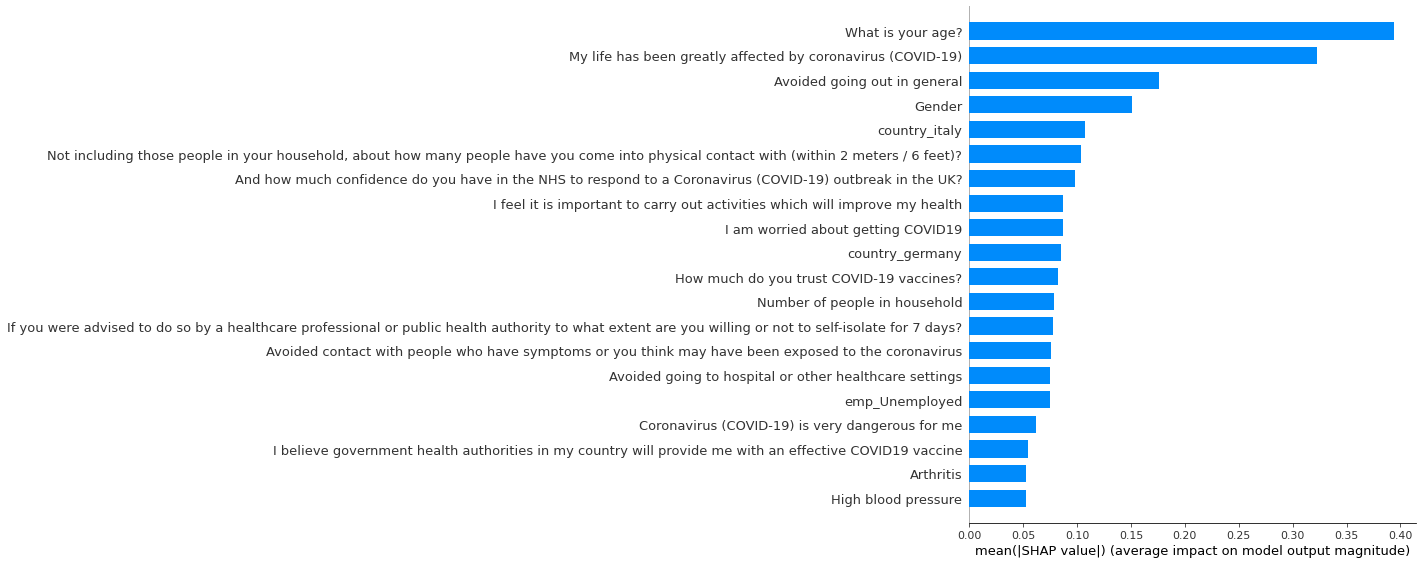

In [105]:
shap.summary_plot(shap_val_xgb, Xc, plot_type="bar", title='Feature Importances of MODEL B', show=False)                 
plt.savefig("xgb_imp1.png",dpi=150, bbox_inches='tight')

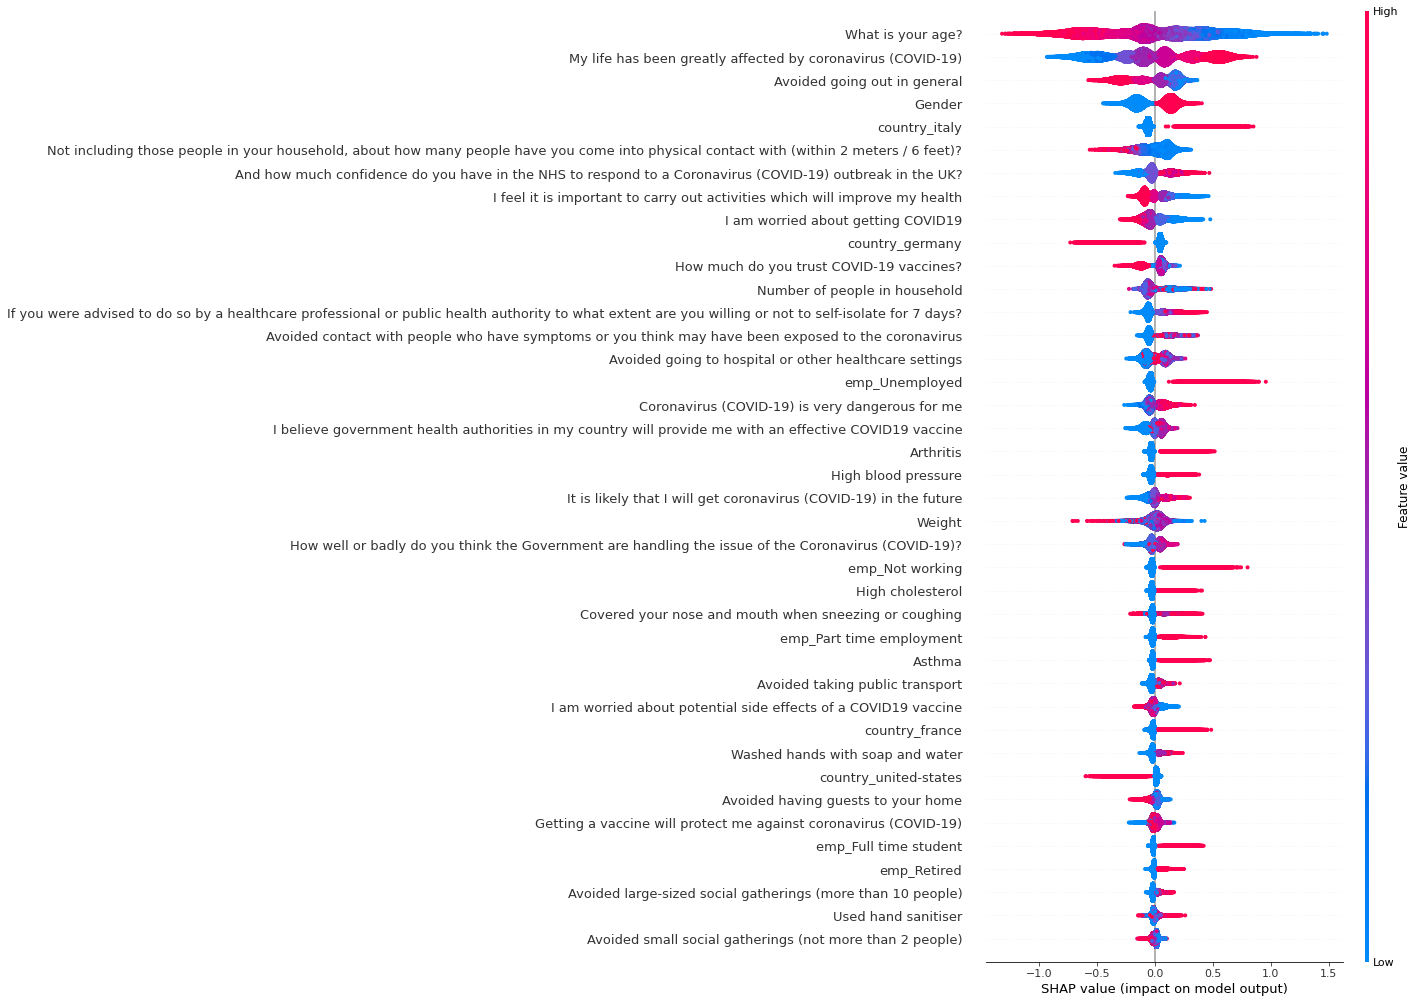

In [112]:
shap.summary_plot(shap_val_xgb, Xc, max_display=40)

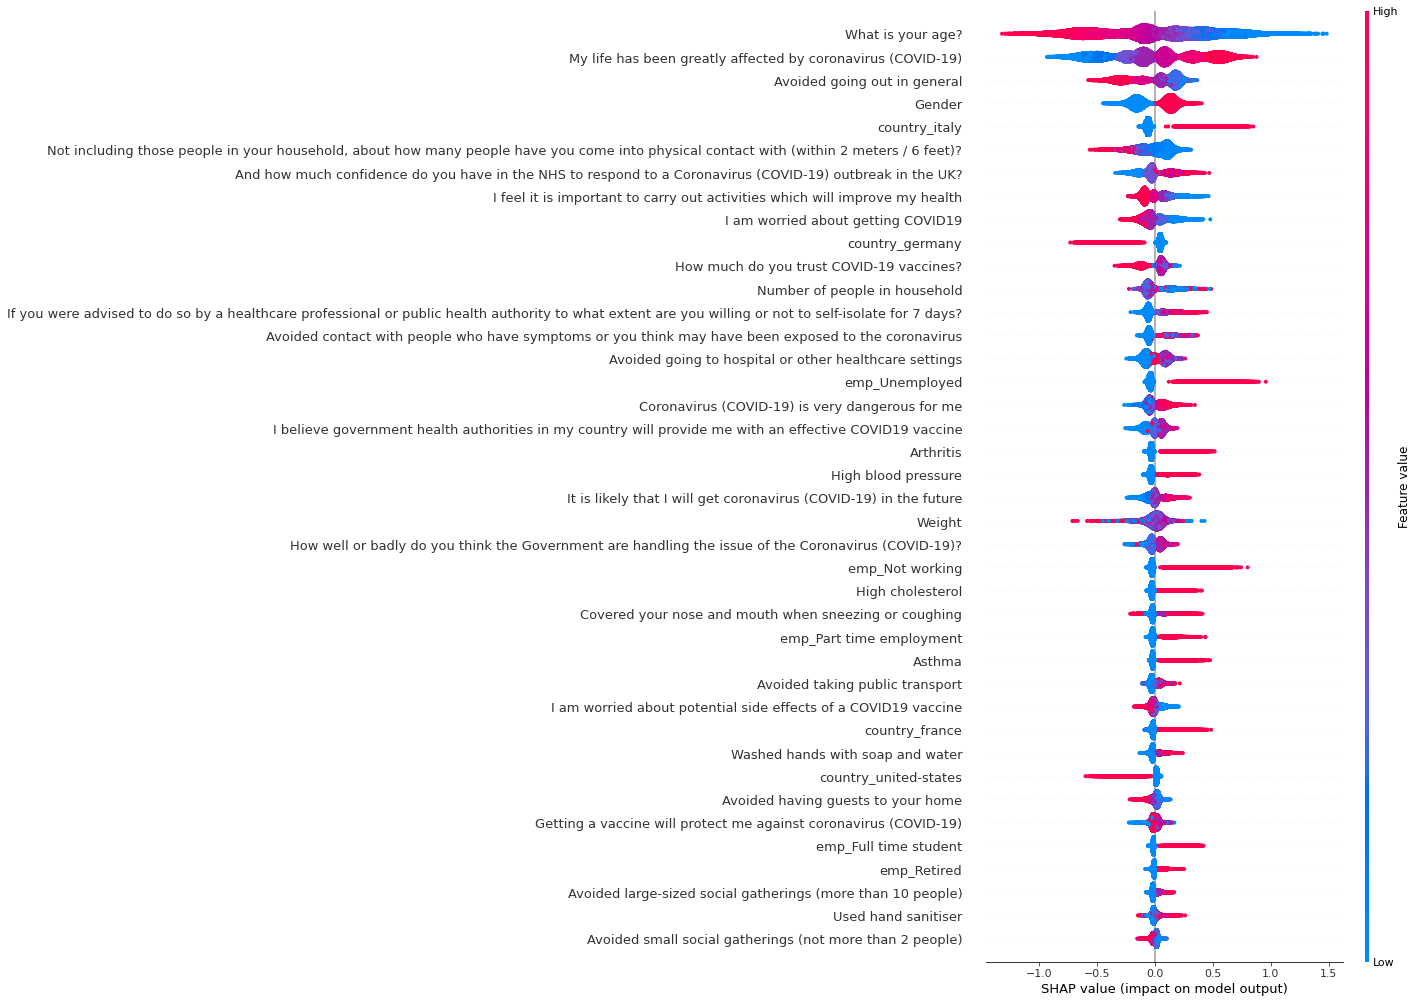

In [117]:
shap.summary_plot(shap_val_xgb, Xc, max_display=40, show=False)
plt.savefig("bs1.png",dpi=150, bbox_inches='tight')

# Visualisations

In [120]:
def split_bar_plot(df_o, column, exp_dict, title, file, xls=20, rotation=0, ha='right'): 
    '''bar chart of responses within a non-binary feature vs proportion within each response reporting 
    issues'''
    x_l= 'Response Value'
    y_l = 'Percentage Reporting Feeling Down or Depressed'
    
    
    df=df_o.copy()
    total_mean=df['Feeling down, depressed, or hopeless'].mean()
    df.sort_values(column, inplace=True)
    df[column].replace(exp_dict, inplace=True)
    df['Gender'].replace({0:'Male', 1:'Female'}, inplace=True)
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 10))
    
    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='x')
    

    
    ax = sns.barplot(x=column, y="Feeling down, depressed, or hopeless", hue="Gender", data=df)
    pc_list = [int(x*100) for x in ax.get_yticks()]
    ax.set_yticklabels(pc_list)
    plt.rc('font', size=20)
    plt.title(title, y=1.05, fontsize=22)
    plt.xlabel(x_l)
    plt.xticks(rotation=rotation, ha=ha, fontsize=xls)
    plt.ylabel(y_l, fontsize=20)   
    plt.axhline(y=total_mean, color='red', linestyle='--', label='Mean over full dataset')
    plt.legend()
    plt.savefig(file, bbox_inches = "tight")
    plt.show();
    

FixedFormatter should only be used together with FixedLocator


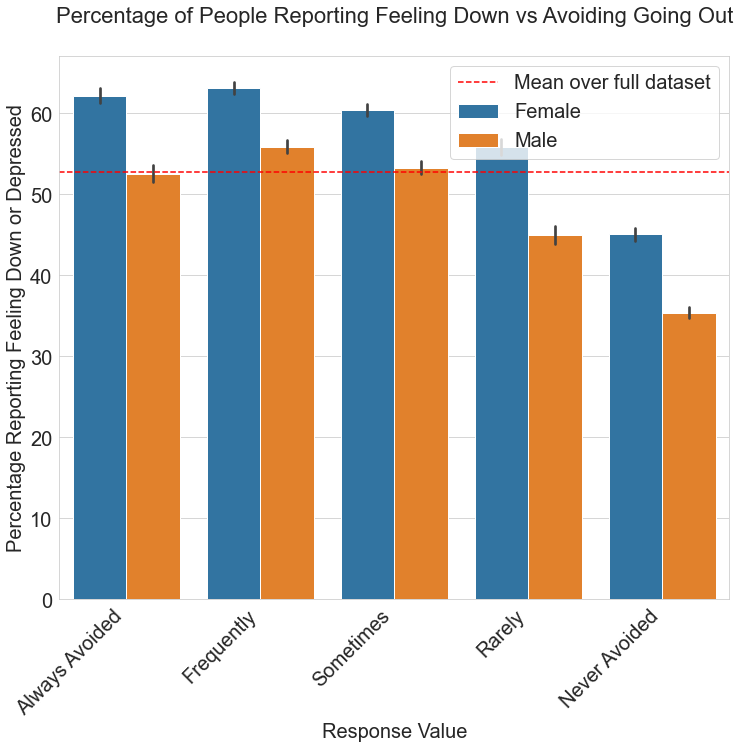

In [121]:
# graph of leaving house question
out_dict = {0: 'Always Avoided', 1: 'Frequently', 2: 'Sometimes', 3: 'Rarely', 4:'Never Avoided'}
split_bar_plot(two_df_c, 'Avoided going out in general', out_dict, 
               'Percentage of People Reporting Feeling Down vs Avoiding Going Out', 
               'images/out_bar.png', xls=20, rotation=45, ha='right')

FixedFormatter should only be used together with FixedLocator


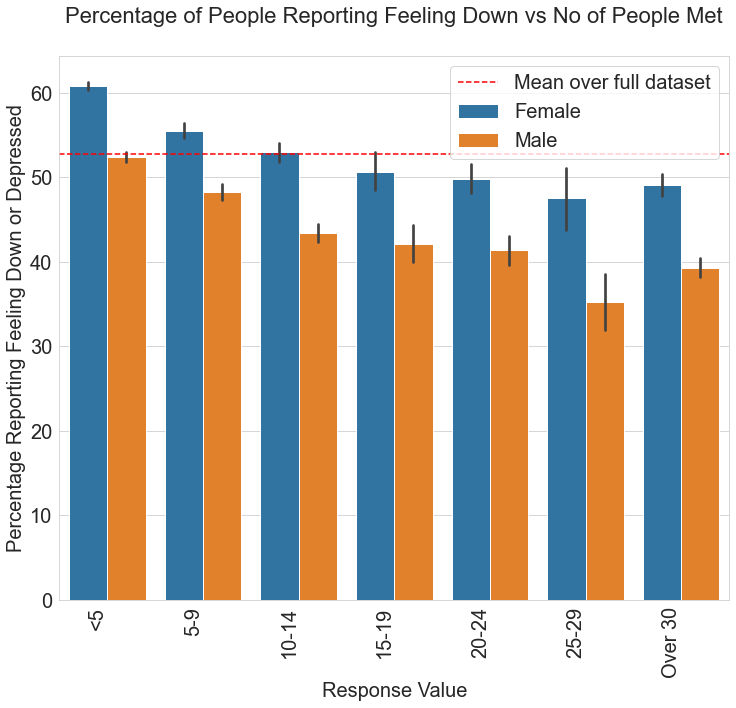

In [123]:
# graph of how many contacts outside household question
contact_df=two_df_c.copy()
conditions_contact = [
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] < 5),
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] >= 5) & 
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] < 10),
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] >= 10) & 
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] < 15),
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] >= 15) &
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] < 20), 
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] >= 20) &
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] < 25), 
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] >= 25) &
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] < 30), 
    (contact_df['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?'] >= 30)
]

values_contact = [0, 1, 2, 3, 4, 5, 6]
contact_dict={0:'<5', 1:'5-9', 2:'10-14', 3:'15-19', 4:'20-24', 5:'25-29', 6:'Over 30'}

contact_df['Binned Values'] = np.select(conditions_contact, values_contact)
split_bar_plot(contact_df, 'Binned Values', contact_dict, 
               'Percentage of People Reporting Feeling Down vs No of People Met', 
               'images/contact_bar.png', xls=20, rotation=90, ha='right')

FixedFormatter should only be used together with FixedLocator


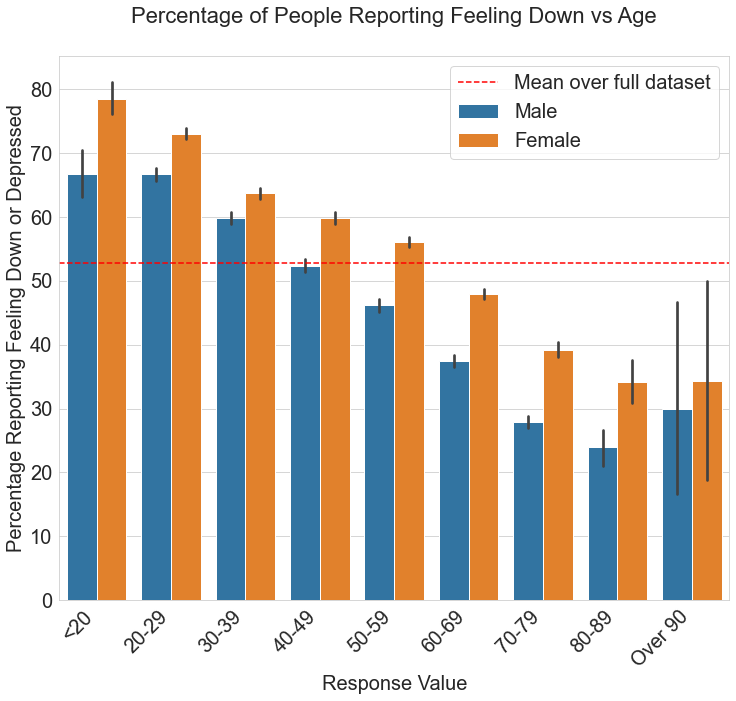

In [124]:
# graph of age 

age_df=two_df_c.copy()
conditions_age = [
    (age_df['What is your age?'] < 20),
    (age_df['What is your age?'] >= 20) & 
    (age_df['What is your age?'] < 30),
    (age_df['What is your age?'] >= 30) & 
    (age_df['What is your age?'] < 40),
    (age_df['What is your age?'] >= 40) &
    (age_df['What is your age?'] < 50), 
    (age_df['What is your age?'] >= 50) &
    (age_df['What is your age?'] < 60), 
    (age_df['What is your age?'] >= 60) &
    (age_df['What is your age?'] < 70), 
    (age_df['What is your age?'] >= 70) &
    (age_df['What is your age?'] < 80), 
    (age_df['What is your age?'] >= 80) &
    (age_df['What is your age?'] < 90),
    (age_df['What is your age?'] >= 90)
]

values_age = [0, 1, 2, 3, 4, 5, 6, 7, 8]
age_dict={0:'<20', 1:'20-29', 2:'30-39', 3:'40-49', 4:'50-59', 5:'60-69', 6:'70-79', 7:'80-89', 8:'Over 90'}

age_df['Binned Values'] = np.select(conditions_age, values_age)
split_bar_plot(age_df, 'Binned Values', age_dict, 
               'Percentage of People Reporting Feeling Down vs Age', 
               'images/age_bar.png', xls=20, rotation=45, ha='right')

FixedFormatter should only be used together with FixedLocator


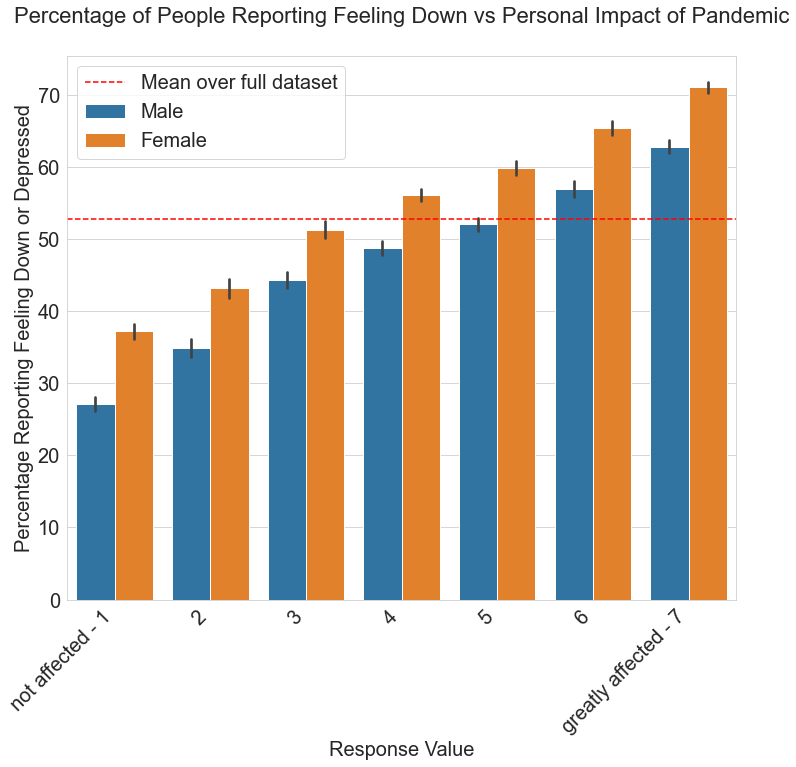

In [125]:
# graph of effect of pandemic vs feeling down
effect_dict={1:'not affected - 1', 7: 'greatly affected - 7'}
split_bar_plot(two_df_c, 'My life has been greatly affected by coronavirus (COVID-19)', effect_dict, 
               'Percentage of People Reporting Feeling Down vs Personal Impact of Pandemic', 
               'images/effect_bar.png', xls=20, rotation=45, ha='right')

In [126]:
def like_v_like_bar(col_list, title, file, xls=20, rotation=0, ha='right'): 
    '''graph of like binary features''' 
    x_l= 'Response Value'
    y_l ='Percentage Reporting Feeling Down or Depressed'
    
    col_list1=['Gender', 'Feeling down, depressed, or hopeless']
    col_list1.extend(col_list)
    
    male_df=two_df_c.copy()
    female_df=two_df_c.copy()

    male_df=male_df[col_list1]
    female_df=female_df[col_list1]

    male_df=male_df[male_df['Gender']==0]
    female_df=female_df[female_df['Gender']==1]
    
    if 'country_denmark' in col_list:
        default='australia'
    elif 'emp_Unemployed' in col_list:
        default='full_time work'
    else:
        default='No Preconditions'
    

    male_df['feature'] =default
    female_df['feature'] =default

    for n in col_list:
        if '_' in n:
            str_list=n.split('_')
            tag= str_list[1]
        else:
            tag=n
        new_col = f'{n}_a'
        male_m=male_df.groupby(n).mean().loc[1, 'Feeling down, depressed, or hopeless']
        female_m=female_df.groupby(n).mean().loc[1, 'Feeling down, depressed, or hopeless']
    
        male_df[new_col]=male_m
        female_df[new_col]=female_m
        
        male_df.loc[male_df[n] == 1, 'feature'] = tag
        female_df.loc[female_df[n] == 1, 'feature'] = tag

    df_f=pd.concat([male_df, female_df])   
    
    total_mean=df_f['Feeling down, depressed, or hopeless'].mean()
    df_f['Gender'].replace({0:'Male', 1:'Female'}, inplace=True)
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 10))
    
    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='x')
    

    
    ax = sns.barplot(x='feature', y="Feeling down, depressed, or hopeless", hue="Gender", data=df_f)
    pc_list = [int(x*100) for x in ax.get_yticks()]
    ax.set_yticklabels(pc_list)
    plt.rc('font', size=20)
    plt.title(title, y=1.05, fontsize=22)
    plt.xlabel(x_l)
    plt.xticks(rotation=rotation, ha=ha, fontsize=xls)
    plt.ylabel(y_l, fontsize=20)   
    plt.axhline(y=total_mean, color='red', linestyle='--', label='Mean over full dataset')
    plt.legend()
    plt.savefig(file, bbox_inches = "tight")
    plt.show();
    

In [127]:
def lvl_list_maker(string):
    '''helper func to make list to pass into graph maker'''
    col_list=[]
    for col in two_df_c.columns:
        if col[:3]==string:
            col_list.append(col)
    return col_list

FixedFormatter should only be used together with FixedLocator


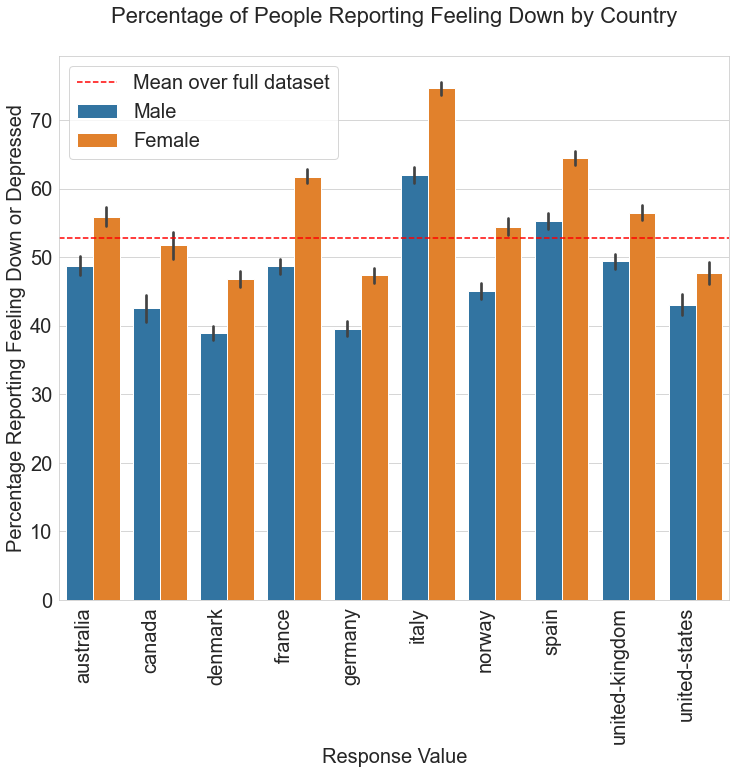

In [130]:
# affect of country
country_list=lvl_list_maker('cou')
like_v_like_bar(country_list, 'Percentage of People Reporting Feeling Down by Country', 
                'images/country_bar.png', xls=20, rotation=90, ha='right')

FixedFormatter should only be used together with FixedLocator


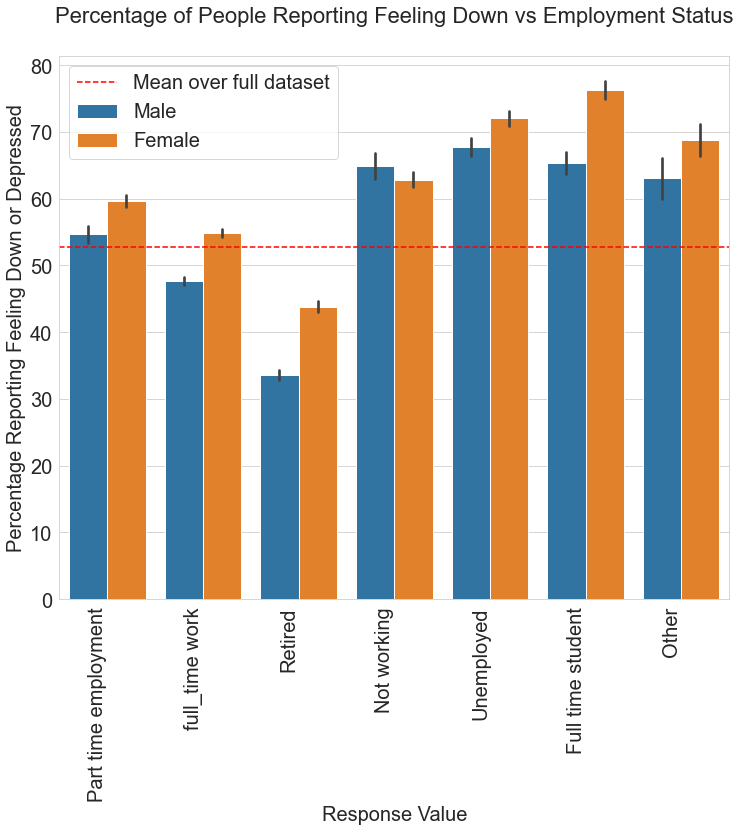

In [131]:
# affect of emp_type
emp_list=lvl_list_maker('emp')
like_v_like_bar(emp_list, 'Percentage of People Reporting Feeling Down vs Employment Status', 
                'images/emp_bar.png', xls=20, rotation=90, ha='right')

FixedFormatter should only be used together with FixedLocator


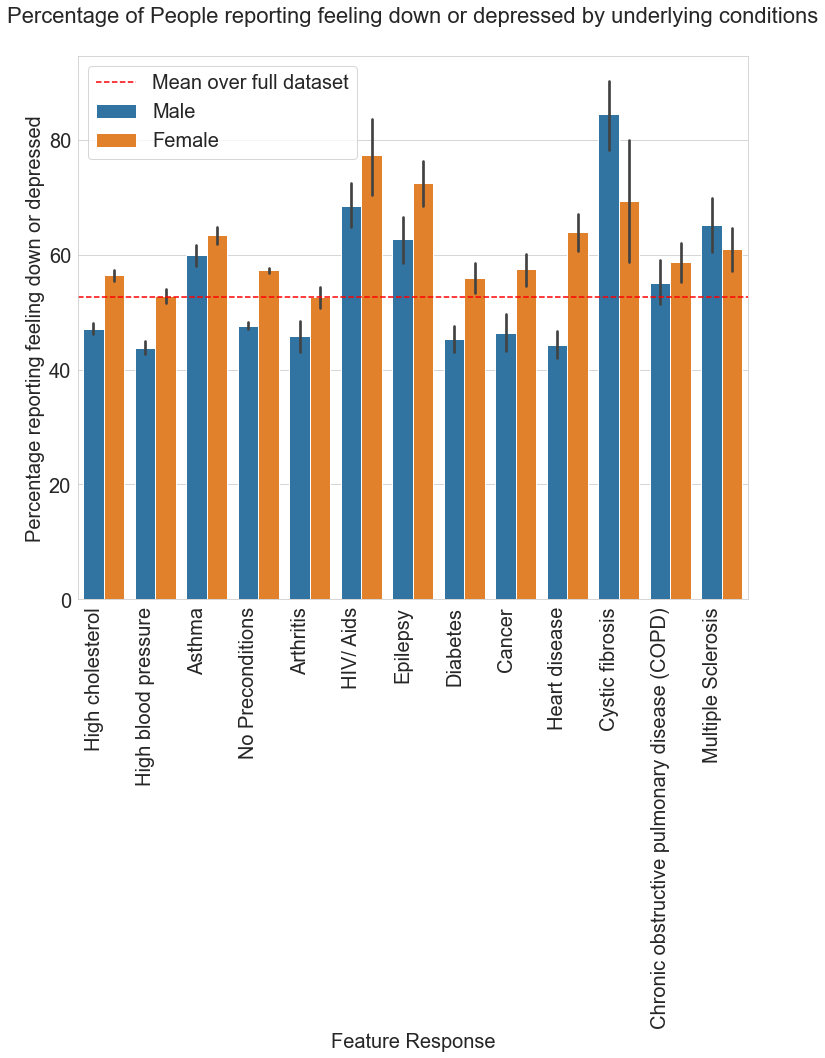

In [120]:
# affect of pre-existing conditions
health_list= ['Arthritis', 'Asthma', 'Cancer', 'Cystic fibrosis', 'Chronic obstructive pulmonary disease (COPD)',
              'Diabetes', 'Epilepsy', 'Heart disease', 'High blood pressure', 'High cholesterol',
              'HIV/ Aids', 'Multiple Sclerosis']
like_v_like_bar(health_list, 'Percentage of People reporting feeling down or depressed by underlying conditions', 
                'images/health_bar.png', xls=20, rotation=90, ha='right')

## confusion matrices

In [96]:
def plot_conf(y_test, pred, file_name, model):
    '''plots and saves confusion matrices given pred results and real results'''
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Matrix Showing Predictive Performance of MODEL {model}')
    plt.savefig(file_name, bbox_inches = "tight")
    plt.show()

In [93]:
# logistic .5 thresh
plot_conf(y_test, new_pred_test, 'images/log_cfm.png', 'A')

NameError: name 'new_pred_test' is not defined

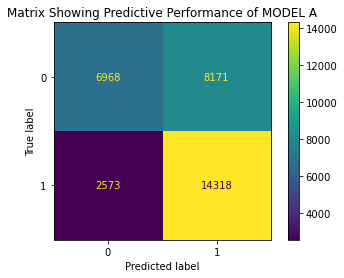

In [97]:
# logistic low thresh
plot_conf(y_test, sm_new[1], 'images/log_t_cfm.png', 'A')

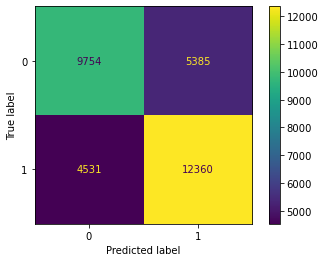

In [83]:
# xgb .5 thresh
plot_conf(y_test, xgb_tun_pred_test, 'images/xgb_cfm.png')

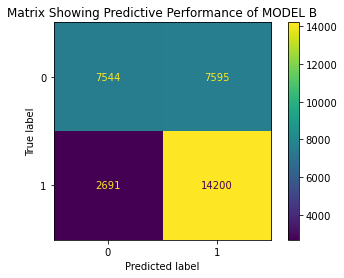

In [98]:
# xgb low thresh
plot_conf(y_test, xgb_tun_pred1_test, 'images/xgb_t_cfm.png', 'B')